In [336]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew
import scipy.stats as stats
import pylab
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans

In [222]:
df = pd.read_csv(r"D:\Data Science & AI\Projects\Main Projects\Medical Inventery Management\Medical Inventory Optimaization Dataset.csv", parse_dates=['Dateofbill'])
df['Month'] = df['Dateofbill'].dt.to_period('M')

In [223]:
df.head(10)

Typeofsales   Patient_ID    Specialisation         Dept Dateofbill  \
0        Sale  12018098765   Specialisation6  Department1 2022-06-01   
1        Sale  12018103897   Specialisation7  Department1 2022-07-23   
2        Sale  12018101123   Specialisation2  Department3 2022-06-23   
3        Sale  12018079281  Specialisation40  Department1 2022-03-17   
4        Sale  12018117928   Specialisation5  Department1 2022-12-21   
5      Return  12018103662   Specialisation2  Department1 2022-07-15   
6        Sale  12018097585   Specialisation2  Department1 2022-05-22   
7        Sale  12018077721   Specialisation4  Department1 2022-01-12   
8        Sale  12018096500   Specialisation4  Department2 2022-08-24   
9        Sale  12018071649   Specialisation4  Department1 2022-08-31   

   Quantity  ReturnQuantity  Final_Cost  Final_Sales   RtnMRP Formulation  \
0         1               0      55.406       59.260    0.000       Form1   
1         1               0     768.638      950.800    0.000       Form1   
2         1               0     774.266     4004.214    0.000       Form2   
3         2               0      40.798       81.044    0.000       Form1   
4         1               0      40.434       40.504    0.000       Form1   
5         0               8      47.902        0.000  330.288       Form1   
6         1               0      41.862       42.218    0.000       Form1   
7         3               0      60.026      142.752    0.000       Form1   
8         2               0      49.856       94.000    0.000       Form2   
9         1               0     258.860      319.800    0.000       Form1   

                            DrugName                        SubCat  \
0          ZINC ACETATE 20MG/5ML SYP            SYRUP & SUSPENSION   
1    CEFTAZIDIME 2GM+AVIBACTAM 500MG                    INJECTIONS   
2             EPTIFIBATIDE 0.75MG/ML                    INJECTIONS   
3  WATER FOR INJECTION 10ML SOLUTION                    INJECTIONS   
4                      LORAZEPAM 1MG            TABLETS & CAPSULES   
5                   SALBUTAMOL 2.5MG           INHALERS & RESPULES   
6                 FUROSEMIDE 10MG/ML                    INJECTIONS   
7          SODIUM CHLORIDE IVF 100ML  IV FLUIDS, ELECTROLYTES, TPN   
8        SODIUM BICARBONATE 8.5% INJ                    INJECTIONS   
9          PEPTIDE BASED DIET POWDER       NUTRITIONAL SUPPLEMENTS   

                                 SubCat1    Month  
0                    VITAMINS & MINERALS  2022-06  
1                        ANTI-INFECTIVES  2022-07  
2  CARDIOVASCULAR & HEMATOPOIETIC SYSTEM  2022-06  
3  INTRAVENOUS & OTHER STERILE SOLUTIONS  2022-03  
4                 CENTRAL NERVOUS SYSTEM  2022-12  
5                     RESPIRATORY SYSTEM  2022-07  
6  CARDIOVASCULAR & HEMATOPOIETIC SYSTEM  2022-05  
7  INTRAVENOUS & OTHER STERILE SOLUTIONS  2022-01  
8  INTRAVENOUS & OTHER STERILE SOLUTIONS  2022-08  
9                              NUTRITION  2022-08

In [224]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [225]:
df.dtypes

Typeofsales               object
Patient_ID                 int64
Specialisation            object
Dept                      object
Dateofbill        datetime64[ns]
Quantity                   int64
ReturnQuantity             int64
Final_Cost               float64
Final_Sales              float64
RtnMRP                   float64
Formulation               object
DrugName                  object
SubCat                    object
SubCat1                   object
Month                  period[M]
dtype: object

In [226]:
df["Patient_ID"] = df["Patient_ID"].astype('str')
df["Final_Sales"] = df["Final_Sales"].astype('float32')
df["Final_Cost"] = df["Final_Cost"].astype('float32')

In [227]:
df.dtypes

Typeofsales               object
Patient_ID                object
Specialisation            object
Dept                      object
Dateofbill        datetime64[ns]
Quantity                   int64
ReturnQuantity             int64
Final_Cost               float32
Final_Sales              float32
RtnMRP                   float64
Formulation               object
DrugName                  object
SubCat                    object
SubCat1                   object
Month                  period[M]
dtype: object

# Handling Duplicates and Missing Values

In [228]:
# Duplicates
duplicate = df.duplicated()  
sum(duplicate)

26

In [229]:
# Remove duplicates
df = df.drop_duplicates() 
duplicate = df.duplicated()
sum(duplicate)

0

In [230]:
# Handling Missing Values
df.replace('', pd.NA, inplace=True)

In [231]:
df.isnull().sum()

Typeofsales          0
Patient_ID           0
Specialisation       0
Dept                 0
Dateofbill           0
Quantity             0
ReturnQuantity       0
Final_Cost           0
Final_Sales          0
RtnMRP               0
Formulation        650
DrugName          1659
SubCat            1659
SubCat1           1682
Month                0
dtype: int64

In [232]:
group_cols = ['Typeofsales', 'Specialisation', 'Dept']

In [233]:
# Impute missing values in Formulation column based on the mode of the group
def fill_missing_with_mode(df, group_cols, target_col):
    grouped = df.groupby(group_cols)[target_col]
    modes = grouped.transform(lambda x: x.mode().iloc[0] if not x.mode().empty else x)
    df[target_col] = df[target_col].fillna(modes)

In [234]:
mode_impute_cols = ['Formulation','DrugName','SubCat','SubCat1']

In [235]:
for col in mode_impute_cols:
    fill_missing_with_mode(df,group_cols,col)

In [236]:
df.isnull().sum()

Typeofsales       0
Patient_ID        0
Specialisation    0
Dept              0
Dateofbill        0
Quantity          0
ReturnQuantity    0
Final_Cost        0
Final_Sales       0
RtnMRP            0
Formulation       3
DrugName          6
SubCat            6
SubCat1           6
Month             0
dtype: int64

In [237]:
# Still there are some missing values that need to be dropped
df.dropna(inplace=True)
df= df.reset_index(drop=True)
df.isnull().sum()

Typeofsales       0
Patient_ID        0
Specialisation    0
Dept              0
Dateofbill        0
Quantity          0
ReturnQuantity    0
Final_Cost        0
Final_Sales       0
RtnMRP            0
Formulation       0
DrugName          0
SubCat            0
SubCat1           0
Month             0
dtype: int64

# Data Manipulation

In [238]:
date_column = 'Dateofbill'
df[date_column] = pd.to_datetime(df[date_column])

# Sort dataset by date column in ascending order
df = df.sort_values(by=date_column, ascending=True)

In [239]:
# Specify Final Cost column to round
column_name = 'Final_Cost'

# Specify number of decimal places to round to 0
decimal_places = 0

# Round the values in the column to 0
df[column_name] = df[column_name].apply(
    lambda x: round(x, decimal_places))

# Specify Final Sales column to round
column_name1 = 'Final_Sales'

# Specify number of decimal places to round to 0
decimal_places1 = 0

# Round values in the column to 0
df[column_name1] = df[column_name1].apply(
    lambda x: round(x, decimal_places1))


In [240]:
df.drop(columns=["ReturnQuantity"], axis=1, inplace=True)

In [241]:
df.head(10)

Typeofsales   Patient_ID    Specialisation         Dept Dateofbill  \
13062        Sale  12018072643  Specialisation11  Department1 2022-01-01   
2433         Sale  12018080296  Specialisation27  Department1 2022-01-01   
9895         Sale  12018080633  Specialisation14  Department1 2022-01-01   
14140        Sale  12018075045   Specialisation4  Department1 2022-01-01   
3749         Sale  12018081111  Specialisation11  Department2 2022-01-01   
11030        Sale  12018076250   Specialisation5  Department1 2022-01-01   
12583        Sale  12018081448  Specialisation14  Department2 2022-01-01   
9755         Sale  12018081582   Specialisation3  Department1 2022-01-01   
6999         Sale  12018071876   Specialisation3  Department1 2022-01-01   
10879      Return  12018081506   Specialisation2  Department1 2022-01-01   

       Quantity  Final_Cost  Final_Sales  RtnMRP Formulation  \
13062         5        87.0        304.0    0.00       Form1   
2433          3        66.0        449.0    0.00       Form1   
9895          1        78.0        126.0    0.00       Form2   
14140         1        48.0         50.0    0.00       Form1   
3749          1        45.0         47.0    0.00       Form1   
11030         1        42.0         43.0    0.00       Form1   
12583         5        87.0        304.0    0.00       Form1   
9755          3        66.0        449.0    0.00       Form1   
6999          1        65.0         75.0    0.00       Form1   
10879         0       132.0          0.0  336.76       Form1   

                         DrugName              SubCat  \
13062       PANTOPRAZOLE 40MG INJ          INJECTIONS   
2433       PARACETAMOL 1GM IV INJ          INJECTIONS   
9895              ENOXAPARIN 40MG          INJECTIONS   
14140        FLUCONAZOLE 50MG TAB  TABLETS & CAPSULES   
3749               EPHEDRINE 30MG          INJECTIONS   
11030              GLYCOPYRROLATE          INJECTIONS   
12583        SODIUM CHLORIDE 0.9%          INJECTIONS   
9755       PARACETAMOL 1GM IV INJ          INJECTIONS   
6999   THYROXINE SODIUM 25MCG TAB  TABLETS & CAPSULES   
10879             ENOXAPARIN 60MG          INJECTIONS   

                                     SubCat1    Month  
13062  INTRAVENOUS & OTHER STERILE SOLUTIONS  2022-01  
2433                  CENTRAL NERVOUS SYSTEM  2022-01  
9895   CARDIOVASCULAR & HEMATOPOIETIC SYSTEM  2022-01  
14140                        ANTI-INFECTIVES  2022-01  
3749   CARDIOVASCULAR & HEMATOPOIETIC SYSTEM  2022-01  
11030                MUSCULO-SKELETAL SYSTEM  2022-01  
12583  INTRAVENOUS & OTHER STERILE SOLUTIONS  2022-01  
9755                  CENTRAL NERVOUS SYSTEM  2022-01  
6999            ENDOCRINE & METABOLIC SYSTEM  2022-01  
10879  CARDIOVASCULAR & HEMATOPOIETIC SYSTEM  2022-01

# Describe data

In [242]:
df.describe()

Dateofbill      Quantity    Final_Cost  \
count                          14184  14184.000000  14184.000000   
mean   2022-07-07 13:57:45.989847552      2.234490    124.692400   
min              2022-01-01 00:00:00      0.000000     40.000000   
25%              2022-04-10 00:00:00      1.000000     45.000000   
50%              2022-07-11 00:00:00      1.000000     54.000000   
75%              2022-10-04 06:00:00      2.000000     78.000000   
max              2022-12-31 00:00:00    150.000000  33178.000000   
std                              NaN      5.137742    465.096326   

        Final_Sales        RtnMRP  
count  14184.000000  14184.000000  
mean     233.871898     29.144288  
min        0.000000      0.000000  
25%       48.000000      0.000000  
50%       86.000000      0.000000  
75%      181.000000      0.000000  
max    39490.000000   8014.000000  
std      671.491922    182.462466

In [243]:
print(df.dtypes)

Typeofsales               object
Patient_ID                object
Specialisation            object
Dept                      object
Dateofbill        datetime64[ns]
Quantity                   int64
Final_Cost               float64
Final_Sales              float64
RtnMRP                   float64
Formulation               object
DrugName                  object
SubCat                    object
SubCat1                   object
Month                  period[M]
dtype: object


In [244]:
# No mode calculation for non-numeric columns (use value counts instead)
for col in df.columns:
  if col not in numeric_cols:
    print(f"Column: {col}")
    print(f"  Most frequent value: {df[col].mode().iloc[0]}")

Column: Typeofsales
  Most frequent value: Sale
Column: Patient_ID
  Most frequent value: 12018071649
Column: Specialisation
  Most frequent value: Specialisation4
Column: Dept
  Most frequent value: Department1
Column: Dateofbill
  Most frequent value: 2022-07-09 00:00:00
Column: Formulation
  Most frequent value: Form1
Column: DrugName
  Most frequent value: MULTIPLE ELECTROLYTES 500ML IVF
Column: SubCat
  Most frequent value: INJECTIONS
Column: SubCat1
  Most frequent value: INTRAVENOUS & OTHER STERILE SOLUTIONS
Column: Month
  Most frequent value: 2022-12


In [245]:
numeric_cols = df.select_dtypes(include=['int64', 'float32', 'float64']).columns

In [246]:
for col in numeric_cols:
  print(f"Column: {col}")
  print(f"  Mean: {df[col].mean()}")
  print(f"  Median: {df[col].median()}")
  print(f"  Mode: {df[col].mode().iloc[0]}")  # Assuming single mode for simplicity
  print(f"  Variance: {df[col].var()}")
  print(f"  Standard Deviation: {df[col].std()}")
  print(f"  Skewness: {skew(df[col])}")  # Using scipy.stats for skewness
  print(f"  Kurtosis: {df[col].kurt()}")  # Kurtosis using pandas
  print("-" * 20)  # Separator between columns

Column: Quantity
  Mean: 2.2344895657078396
  Median: 1.0
  Mode: 1
  Variance: 26.396396228188014
  Standard Deviation: 5.1377423279284855
  Skewness: 11.327695459040598
  Kurtosis: 179.75556416220294
--------------------
Column: Final_Cost
  Mean: 124.69239988719684
  Median: 54.0
  Mode: 42.0
  Variance: 216314.59218365306
  Standard Deviation: 465.0963257043137
  Skewness: 34.515912412455165
  Kurtosis: 2025.2834209195448
--------------------
Column: Final_Sales
  Mean: 233.87189791314157
  Median: 86.0
  Mode: 0.0
  Variance: 450901.4009898075
  Standard Deviation: 671.4919217606474
  Skewness: 21.030715596060183
  Kurtosis: 949.5135104970497
--------------------
Column: RtnMRP
  Mean: 29.14428807106599
  Median: 0.0
  Mode: 0.0
  Variance: 33292.551495890766
  Standard Deviation: 182.46246599202468
  Skewness: 15.781549349226616
  Kurtosis: 402.70868618837704
--------------------


# EDA

In [247]:
df.Quantity.max()

150

In [248]:
df.Final_Cost.max()

33178.0

In [249]:
df.Final_Sales.max()

39490.0

In [250]:
df.RtnMRP.max()

8014.0

In [251]:
# Convert 'Dateofbill' to datetime using the correct format
df['Dateofbill'] = pd.to_datetime(df['Dateofbill'], format='%m/%d/%Y')

In [252]:
df['Week_Number'] = df['Dateofbill'].dt.isocalendar().week
weekly_top_selling = df.groupby(['Week_Number', 'DrugName']).size().reset_index(name='Count')

In [253]:
# Find the top-selling drug for each week
top_selling_by_week = weekly_top_selling.groupby('Week_Number').apply(lambda x: x.nlargest(1, 'Count')).reset_index(drop=True)

In [254]:
# Merge with complete drug names
complete_drug_names = df.groupby('Week_Number')['DrugName'].apply(list).reset_index()
complete_drug_names.columns = ['Week_Number', 'Drugs_Sold']

In [255]:
# Merge to get complete information
result = pd.merge(top_selling_by_week, complete_drug_names, on='Week_Number', how='left')
# Display the result
print(result)

    Week_Number                         DrugName  Count  \
0             1             SODIUM CHLORIDE 0.9%     26   
1             2             SODIUM CHLORIDE 0.9%     19   
2             3        SODIUM CHLORIDE IVF 100ML     20   
3             4             SODIUM CHLORIDE 0.9%     22   
4             5             SODIUM CHLORIDE 0.9%     29   
5             6             SODIUM CHLORIDE 0.9%     15   
6             7             SODIUM CHLORIDE 0.9%     24   
7             8             SODIUM CHLORIDE 0.9%     31   
8             9  MULTIPLE ELECTROLYTES 500ML IVF     25   
9            10             SODIUM CHLORIDE 0.9%     22   
10           11             SODIUM CHLORIDE 0.9%     25   
11           12        SODIUM CHLORIDE IVF 100ML     18   
12           13        SODIUM CHLORIDE IVF 100ML     22   
13           14        SODIUM CHLORIDE IVF 100ML     21   
14           15        SODIUM CHLORIDE IVF 100ML     36   
15           16  MULTIPLE ELECTROLYTES 500ML IVF     22 

In [256]:
# Aggregate counts for all weeks
total_drug_counts = weekly_top_selling.groupby('DrugName')['Count'].sum().reset_index()

# Sort by total count in descending order and get top 20 drugs
top_20_drugs = total_drug_counts.nlargest(20, 'Count')

# Display only drug name and count without index numbers
print(top_20_drugs[['DrugName', 'Count']].to_string(index=False))

                                             DrugName  Count
                      MULTIPLE ELECTROLYTES 500ML IVF    924
                            SODIUM CHLORIDE IVF 100ML    869
                                 SODIUM CHLORIDE 0.9%    769
                                   ONDANSETRON 2MG/ML    668
                                PANTOPRAZOLE 40MG INJ    534
                               PARACETAMOL 1GM IV INJ    404
                    WATER FOR INJECTION 10ML SOLUTION    283
                      LIGNOCAINE HYDROCHLORIDE 2% INJ    266
                   PIPERACILLIN 4GM+ TAZOBACTAM 500MG    255
          LEVOSALBUTAMOL/LEVALBUTEROL 0.63MG RESPULES    194
                                HUMAN ALBUMIN 25% INJ    178
                              ATROPINE SULPHATE 0.6MG    175
                             POTASSIUM CHLORIDE 150MG    172
                                    MEROPENEM 1GM INJ    166
                                      CEFTRIAXONE 1GM    149
                        

# Time Series Analysis

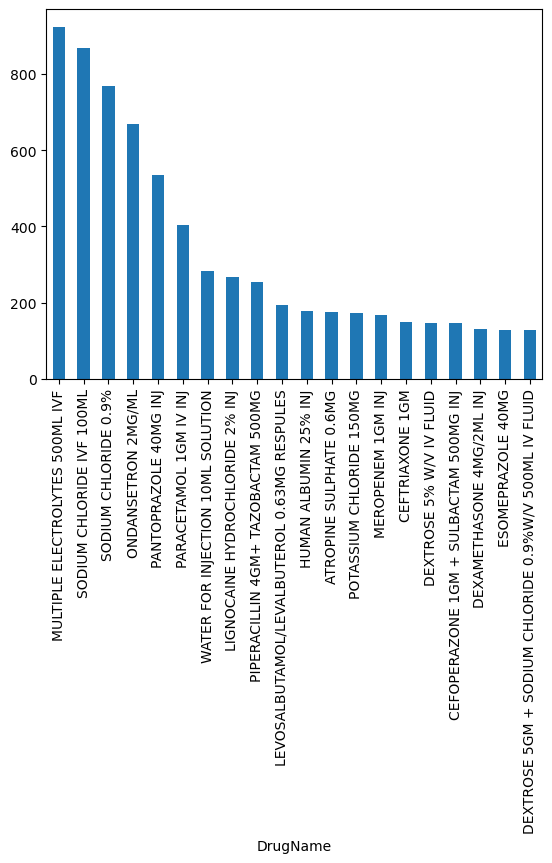

In [257]:
df['DrugName'].value_counts().head(20).plot(kind = 'bar')
df = df[["Dateofbill","Quantity", "DrugName"]]
df = df.set_index('Dateofbill')
df.index = pd.to_datetime(df.index)
grouped_df = df.groupby('DrugName')

In [258]:
A = grouped_df.get_group('MULTIPLE ELECTROLYTES 500ML IVF')
A1 = grouped_df.get_group('SODIUM CHLORIDE IVF 100ML')
A2 = grouped_df.get_group('SODIUM CHLORIDE 0.9%')
A3 = grouped_df.get_group('ONDANSETRON 2MG/ML')
A4 = grouped_df.get_group('PANTOPRAZOLE 40MG INJ')
A5 = grouped_df.get_group('PARACETAMOL 1GM IV INJ')
A6 = grouped_df.get_group('WATER FOR INJECTION 10ML SOLUTION')
A7 = grouped_df.get_group('LIGNOCAINE HYDROCHLORIDE 2% INJ')
A8 = grouped_df.get_group('PIPERACILLIN 4GM+ TAZOBACTAM 500MG')
A9 = grouped_df.get_group('LEVOSALBUTAMOL/LEVALBUTEROL 0.63MG RESPULES')

<Axes: xlabel='Dateofbill'>

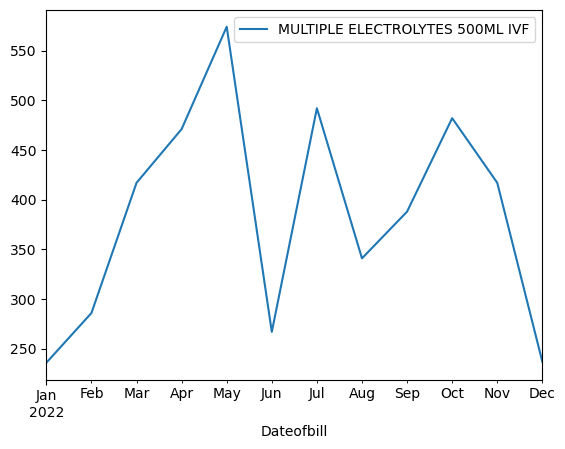

In [259]:
A = A[["Quantity"]]
A.rename(columns = {"Quantity" : "MULTIPLE ELECTROLYTES 500ML IVF"}, inplace=True)
A = A.resample('M').sum()
A.plot()

<Axes: xlabel='Dateofbill'>

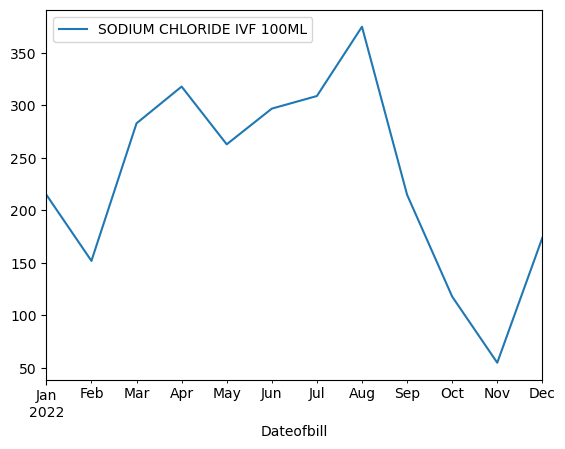

In [260]:
A1 = A1[["Quantity"]]
A1.rename(columns = {"Quantity" : "SODIUM CHLORIDE IVF 100ML"}, inplace=True)
A1 = A1.resample('M').sum()
A1.plot()

<Axes: xlabel='Dateofbill'>

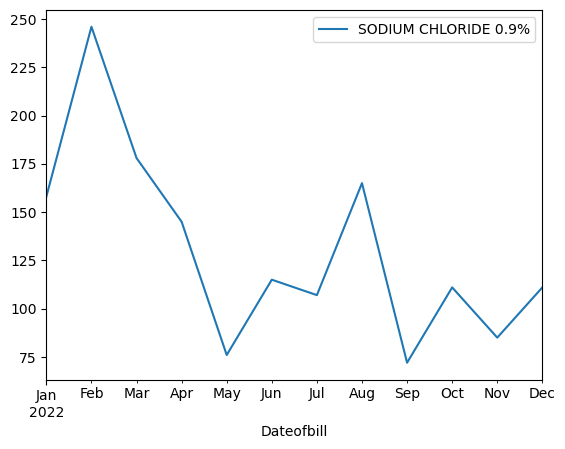

In [261]:
A2 = A2[["Quantity"]]
A2.rename(columns = {"Quantity" : "SODIUM CHLORIDE 0.9%"}, inplace=True)
A2 = A2.resample('M').sum()
A2.plot()

<Axes: xlabel='Dateofbill'>

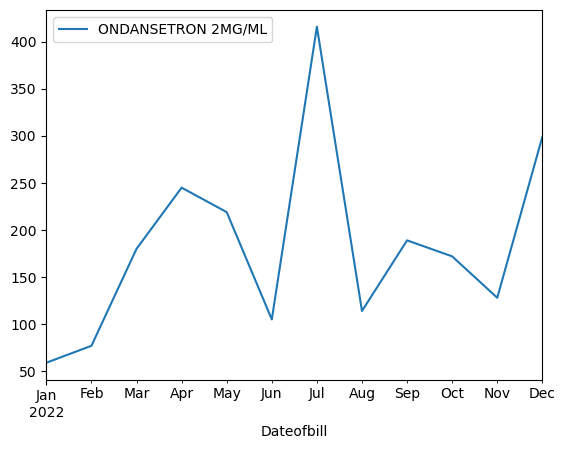

In [262]:
A3 = A3[["Quantity"]]
A3.rename(columns = {"Quantity" : "ONDANSETRON 2MG/ML"}, inplace=True)
A3 = A3.resample('M').sum()
A3.plot()

<Axes: xlabel='Dateofbill'>

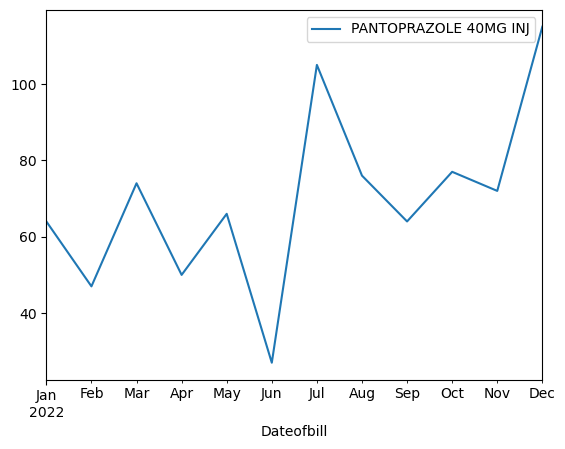

In [263]:
A4 = A4[["Quantity"]]
A4.rename(columns = {"Quantity" : "PANTOPRAZOLE 40MG INJ"}, inplace=True)
A4 = A4.resample('M').sum()
A4.plot()

<Axes: xlabel='Dateofbill'>

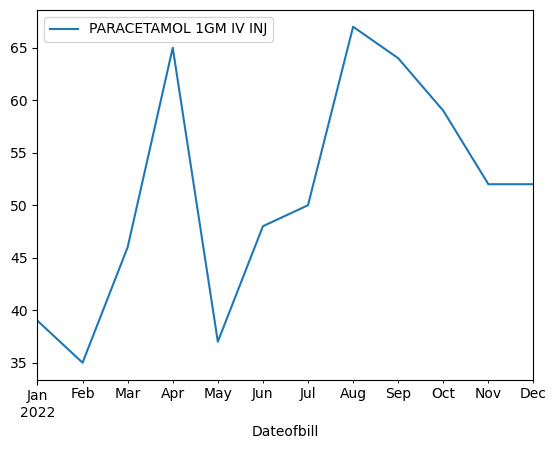

In [264]:
A5 = A5[["Quantity"]]
A5.rename(columns = {"Quantity" : "PARACETAMOL 1GM IV INJ"}, inplace=True)
A5 = A5.resample('M').sum()
A5.plot()

<Axes: xlabel='Dateofbill'>

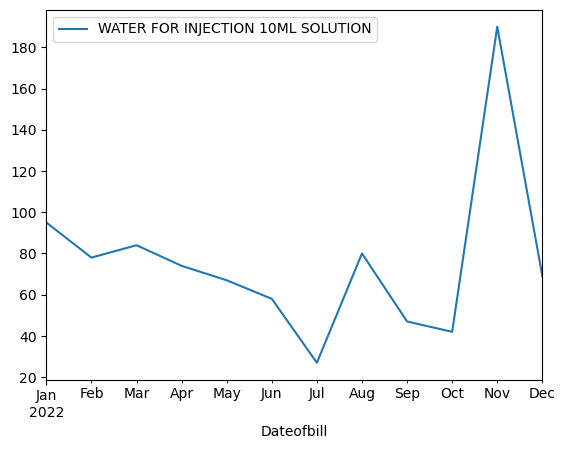

In [265]:
A6 = A6[["Quantity"]]
A6.rename(columns = {"Quantity" : "WATER FOR INJECTION 10ML SOLUTION"}, inplace=True)
A6 = A6.resample('M').sum()
A6.plot()

<Axes: xlabel='Dateofbill'>

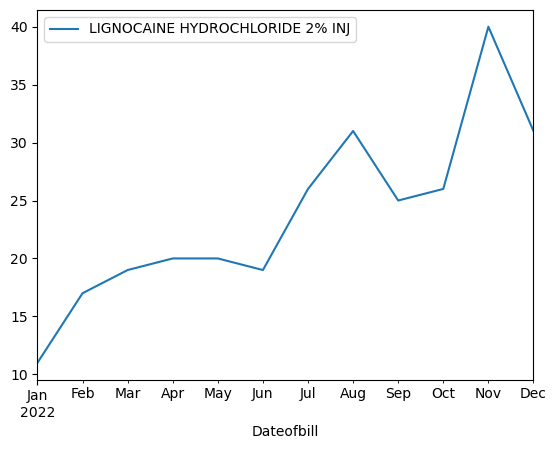

In [266]:
A7 = A7[["Quantity"]]
A7.rename(columns = {"Quantity" : "LIGNOCAINE HYDROCHLORIDE 2% INJ"}, inplace=True)
A7 = A7.resample('M').sum()
A7.plot()

<Axes: xlabel='Dateofbill'>

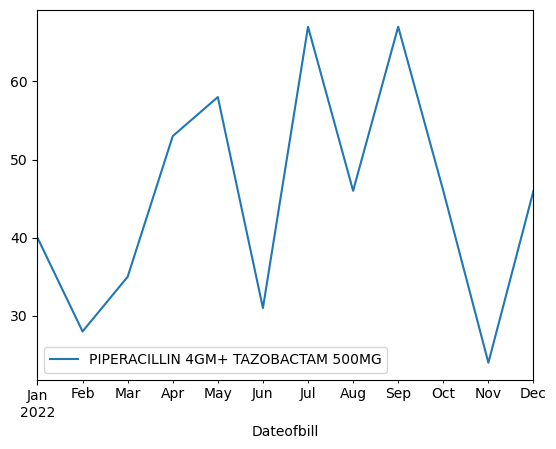

In [267]:
A8 = A8[["Quantity"]]
A8.rename(columns = {"Quantity" : "PIPERACILLIN 4GM+ TAZOBACTAM 500MG"}, inplace=True)
A8 = A8.resample('M').sum()
A8.plot()

<Axes: xlabel='Dateofbill'>

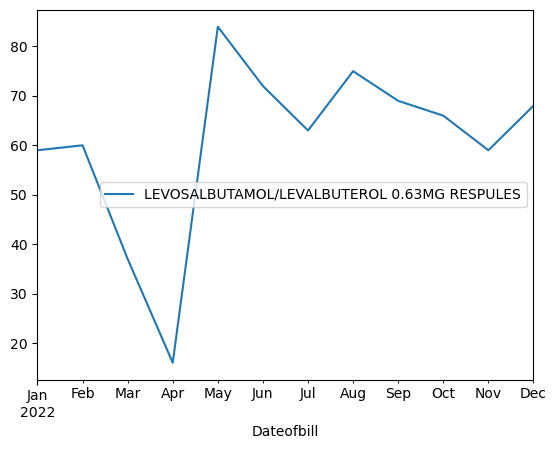

In [268]:
A9 = A9[["Quantity"]]
A9.rename(columns = {"Quantity" : "LEVOSALBUTAMOL/LEVALBUTEROL 0.63MG RESPULES"}, inplace=True)
A9 = A9.resample('M').sum()
A9.plot()

In [269]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. df has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [270]:
adf_test(A)
adf_test(A1)
adf_test(A2)
adf_test(A3)
adf_test(A4)
adf_test(A5)
adf_test(A6)
adf_test(A7)
adf_test(A8)
adf_test(A9)

ADF Statistics: -3.0898112000662836
p- value: 0.027316451508229523
Strong evidence against the null hypothesis, reject the null hypothesis. df has no unit root and is stationary
ADF Statistics: -1.4436213962661102
p- value: 0.5611941780277977
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
ADF Statistics: -2.0693574752677066
p- value: 0.25701323922903646
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
ADF Statistics: -4.000015738286697
p- value: 0.0014104288449969195
Strong evidence against the null hypothesis, reject the null hypothesis. df has no unit root and is stationary
ADF Statistics: -3.1043641476264163
p- value: 0.026231903262447006
Strong evidence against the null hypothesis, reject the null hypothesis. df has no unit root and is stationary
ADF Statistics: -6.874573731030614
p- value: 1.485869693102377e-09
Strong evidence against the null hypothesis, reject the null hypot

In [274]:
def decompose(df):
    result_add = seasonal_decompose(df, model = 'additive', extrapolate_trend='freq',  period=1)

    plt.rcParams.update({'figure.figsize': (20, 10)})
    result_add.plot().suptitle('Additive Decompose', fontsize=30)
    plt.show()
    
    return  result_add

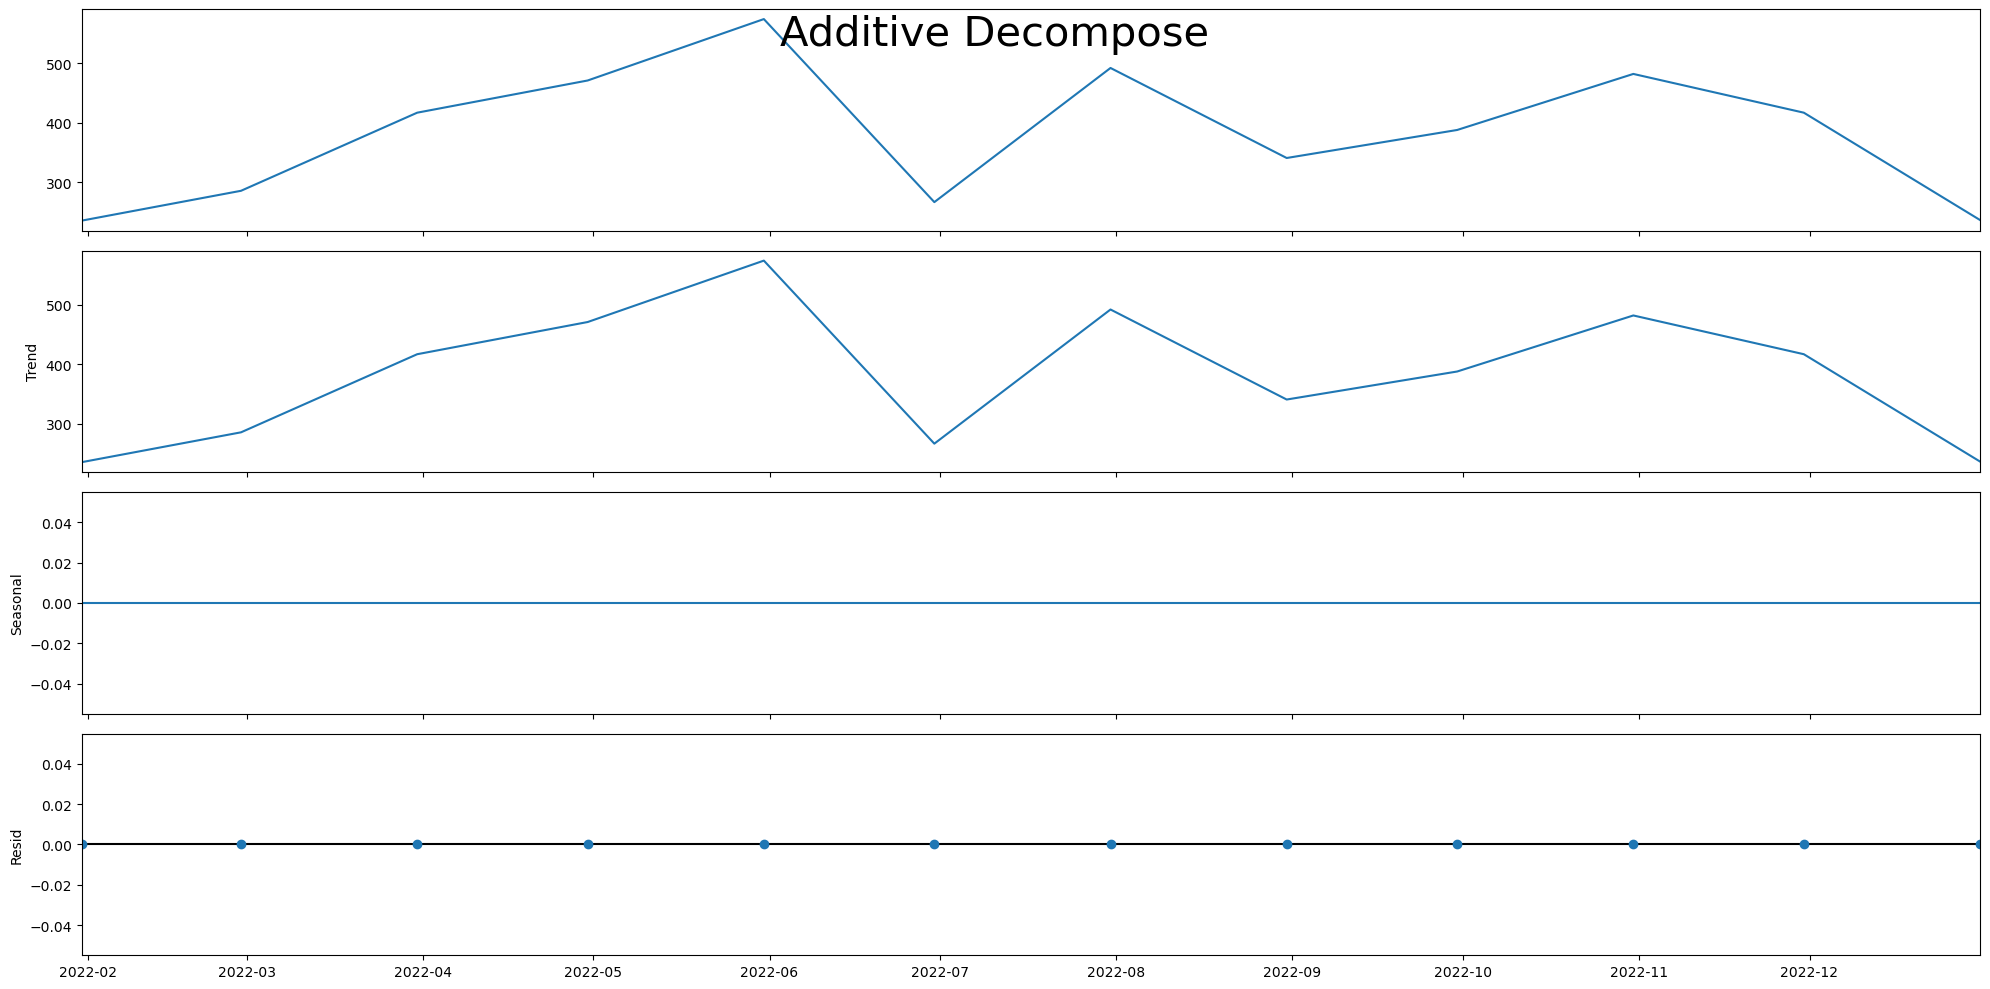

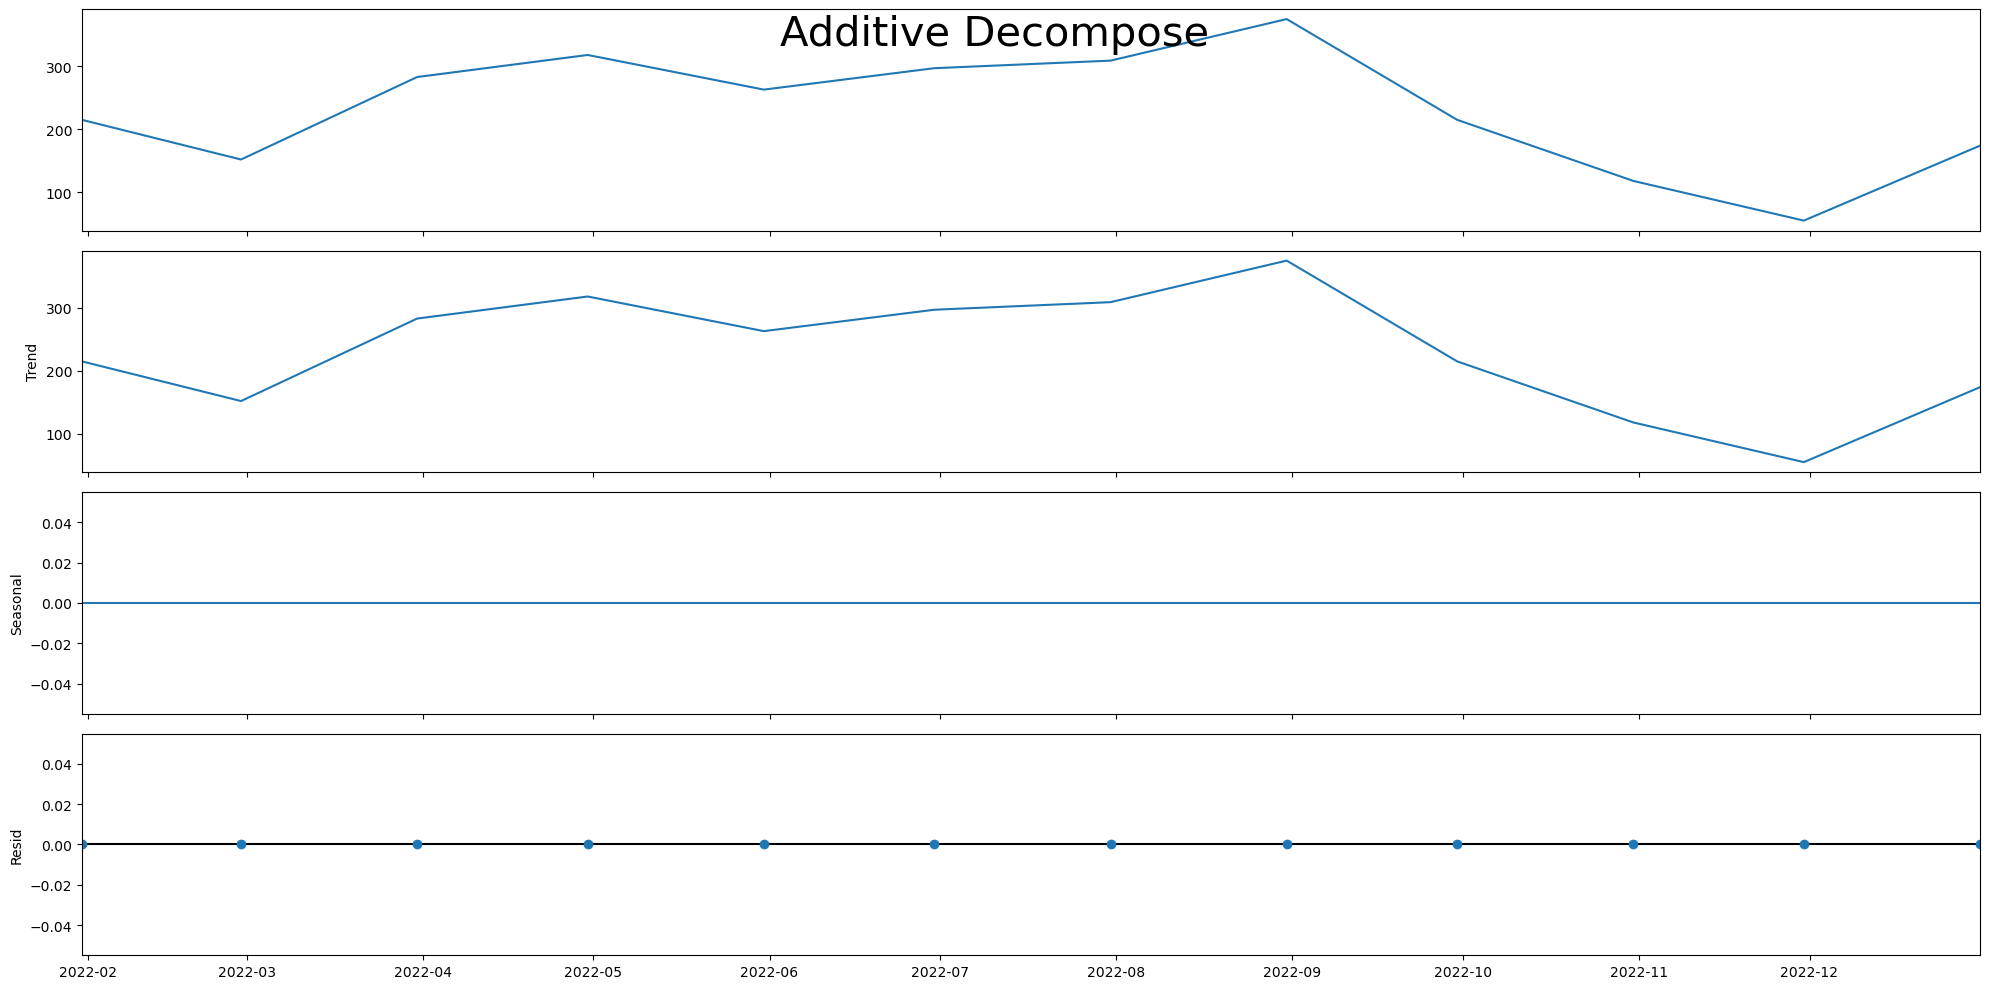

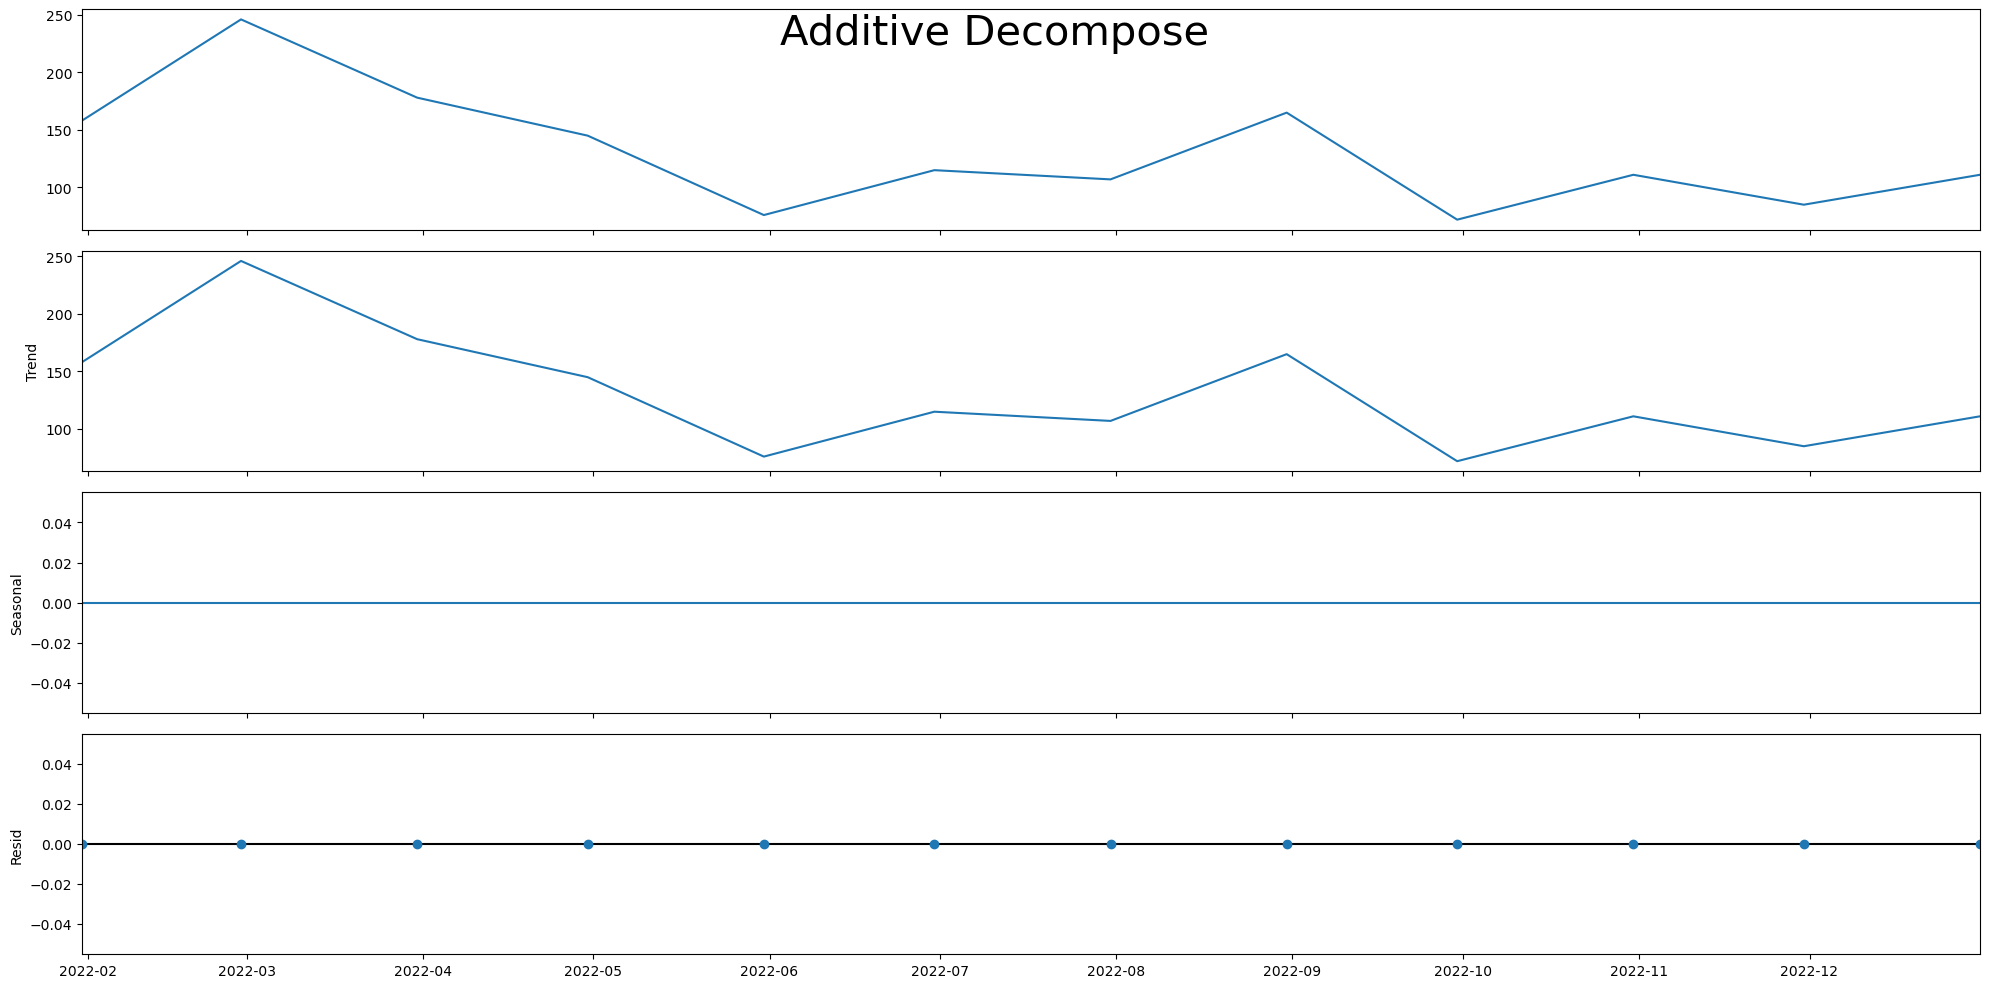

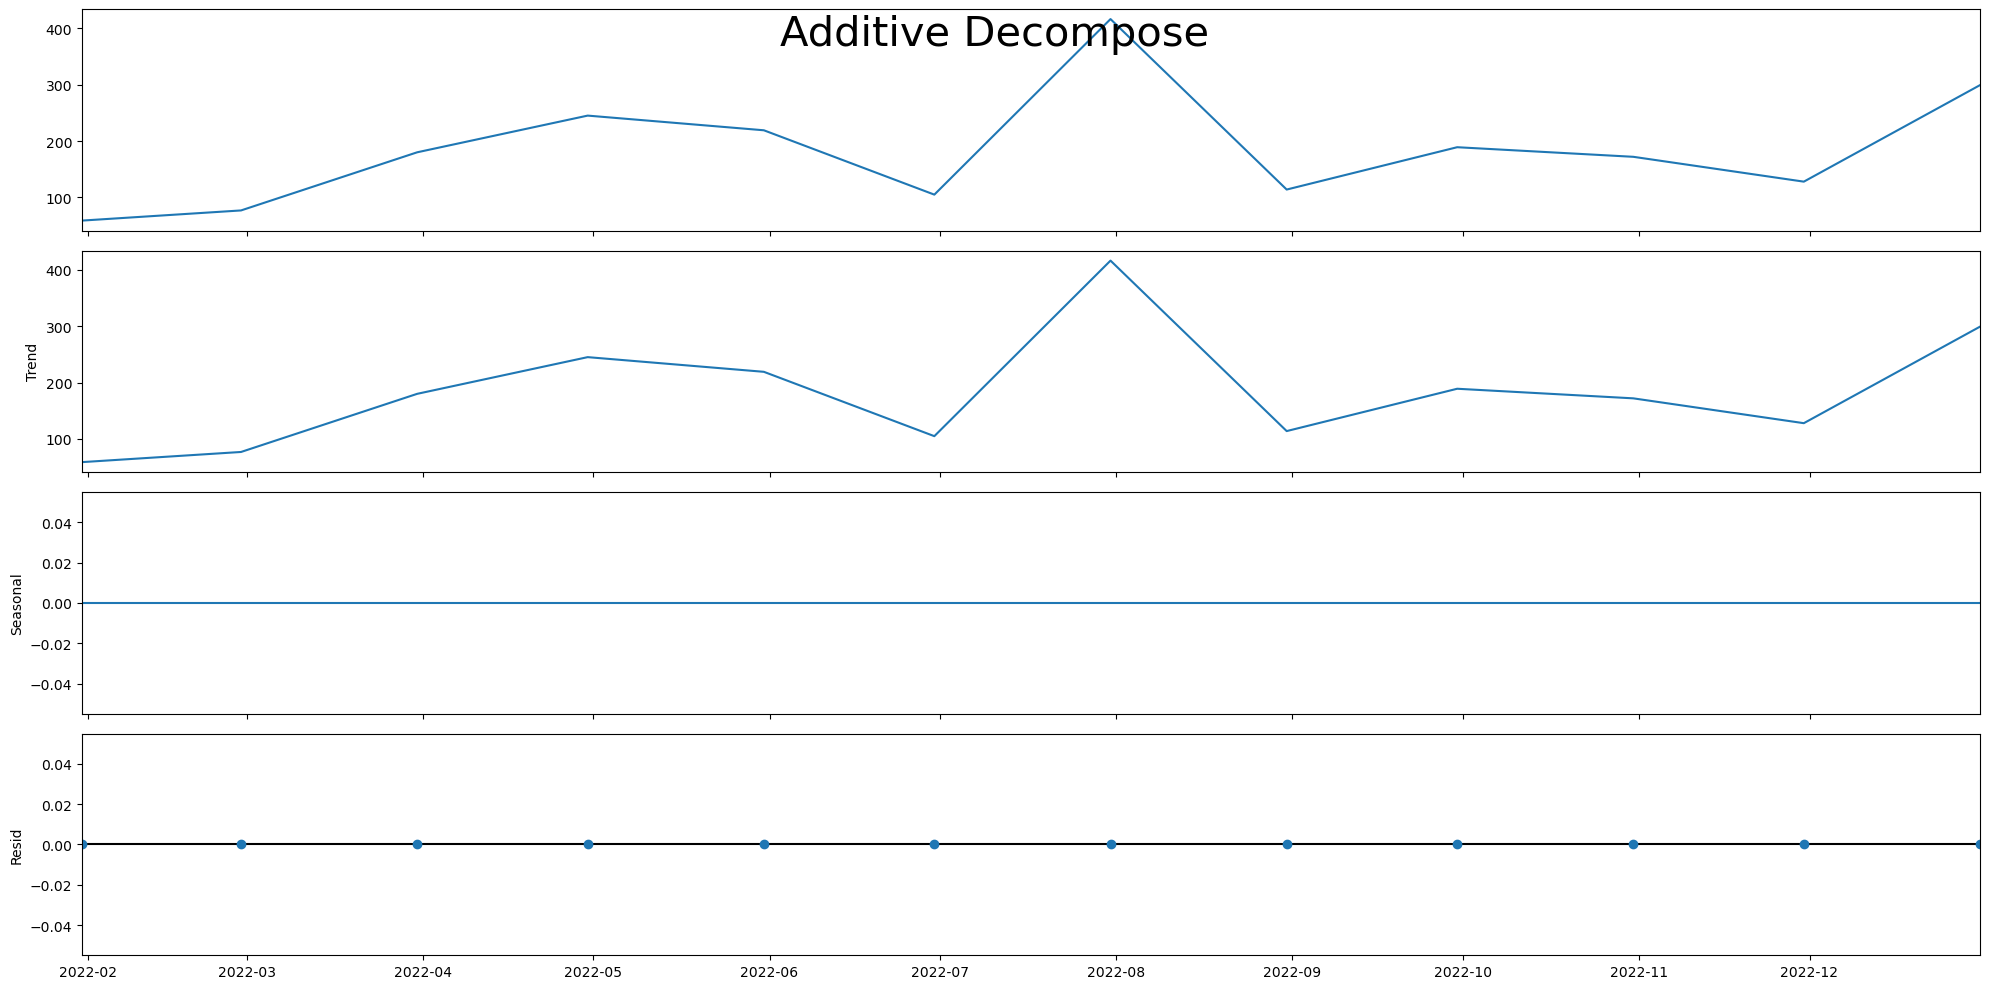

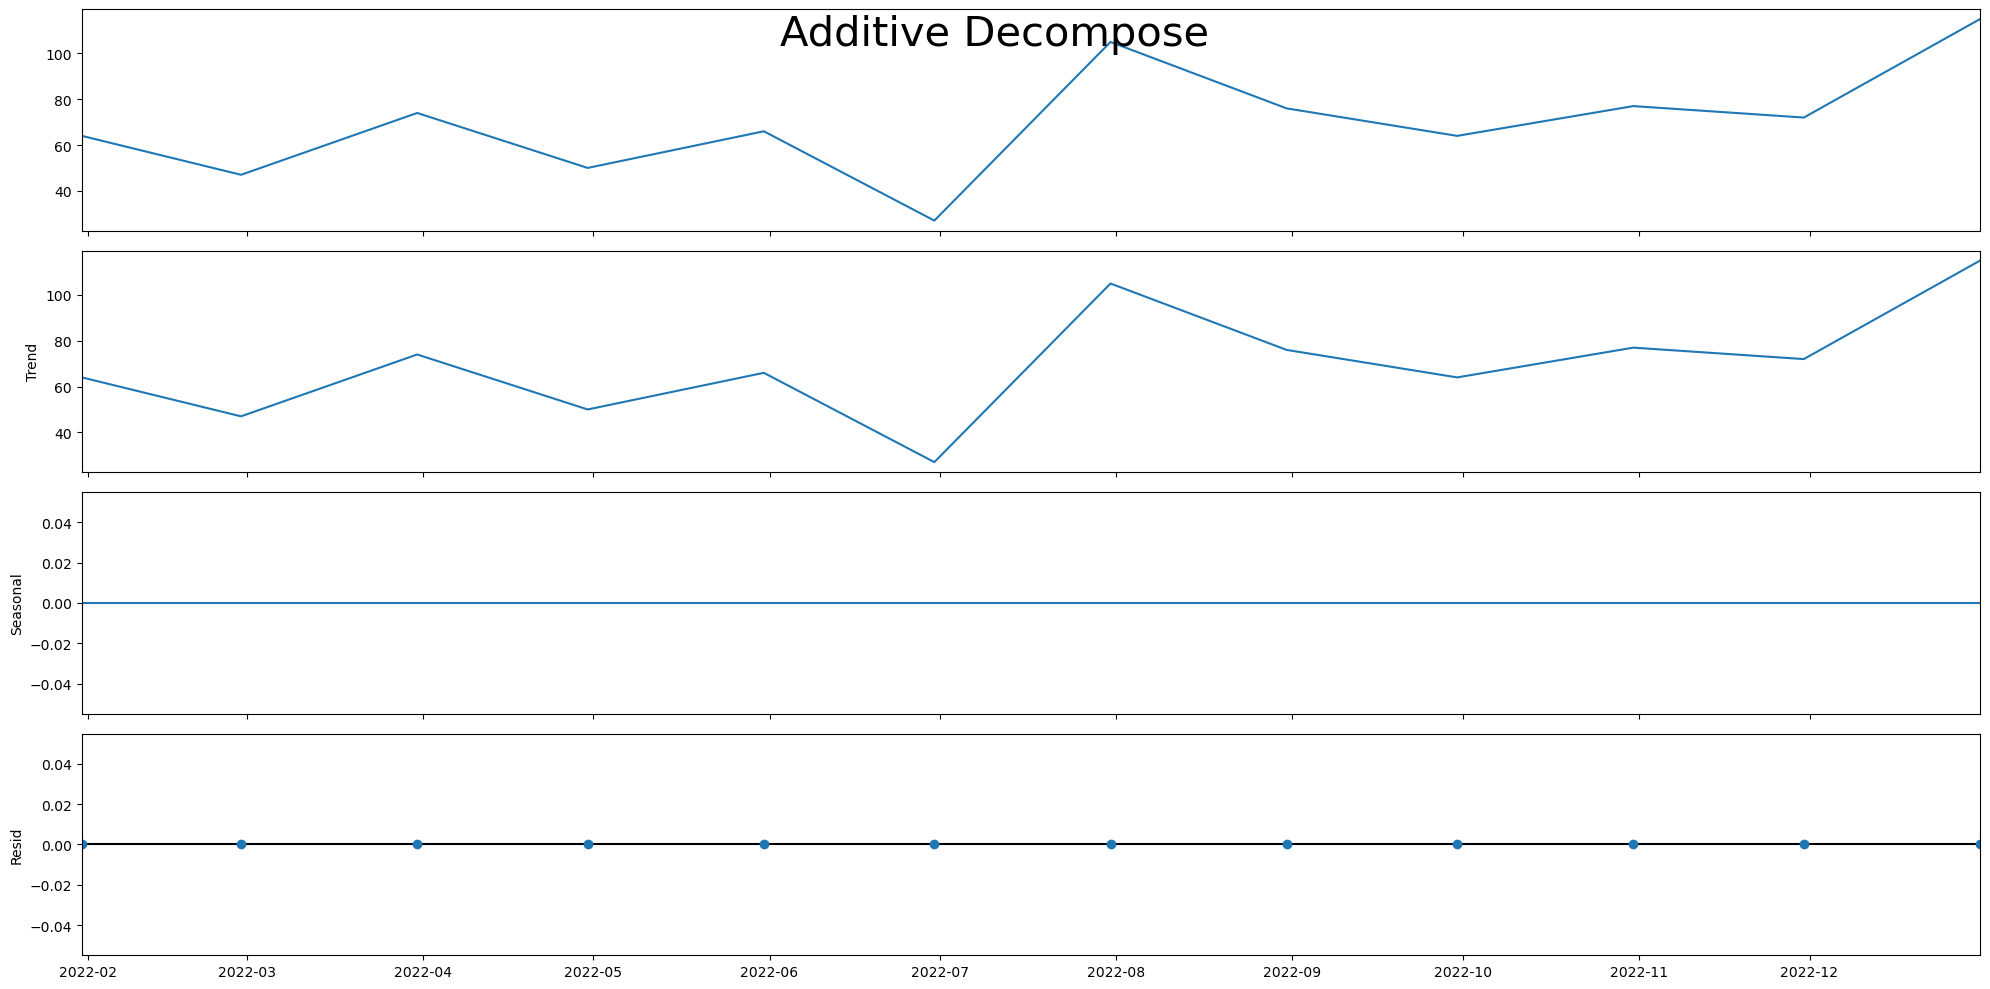

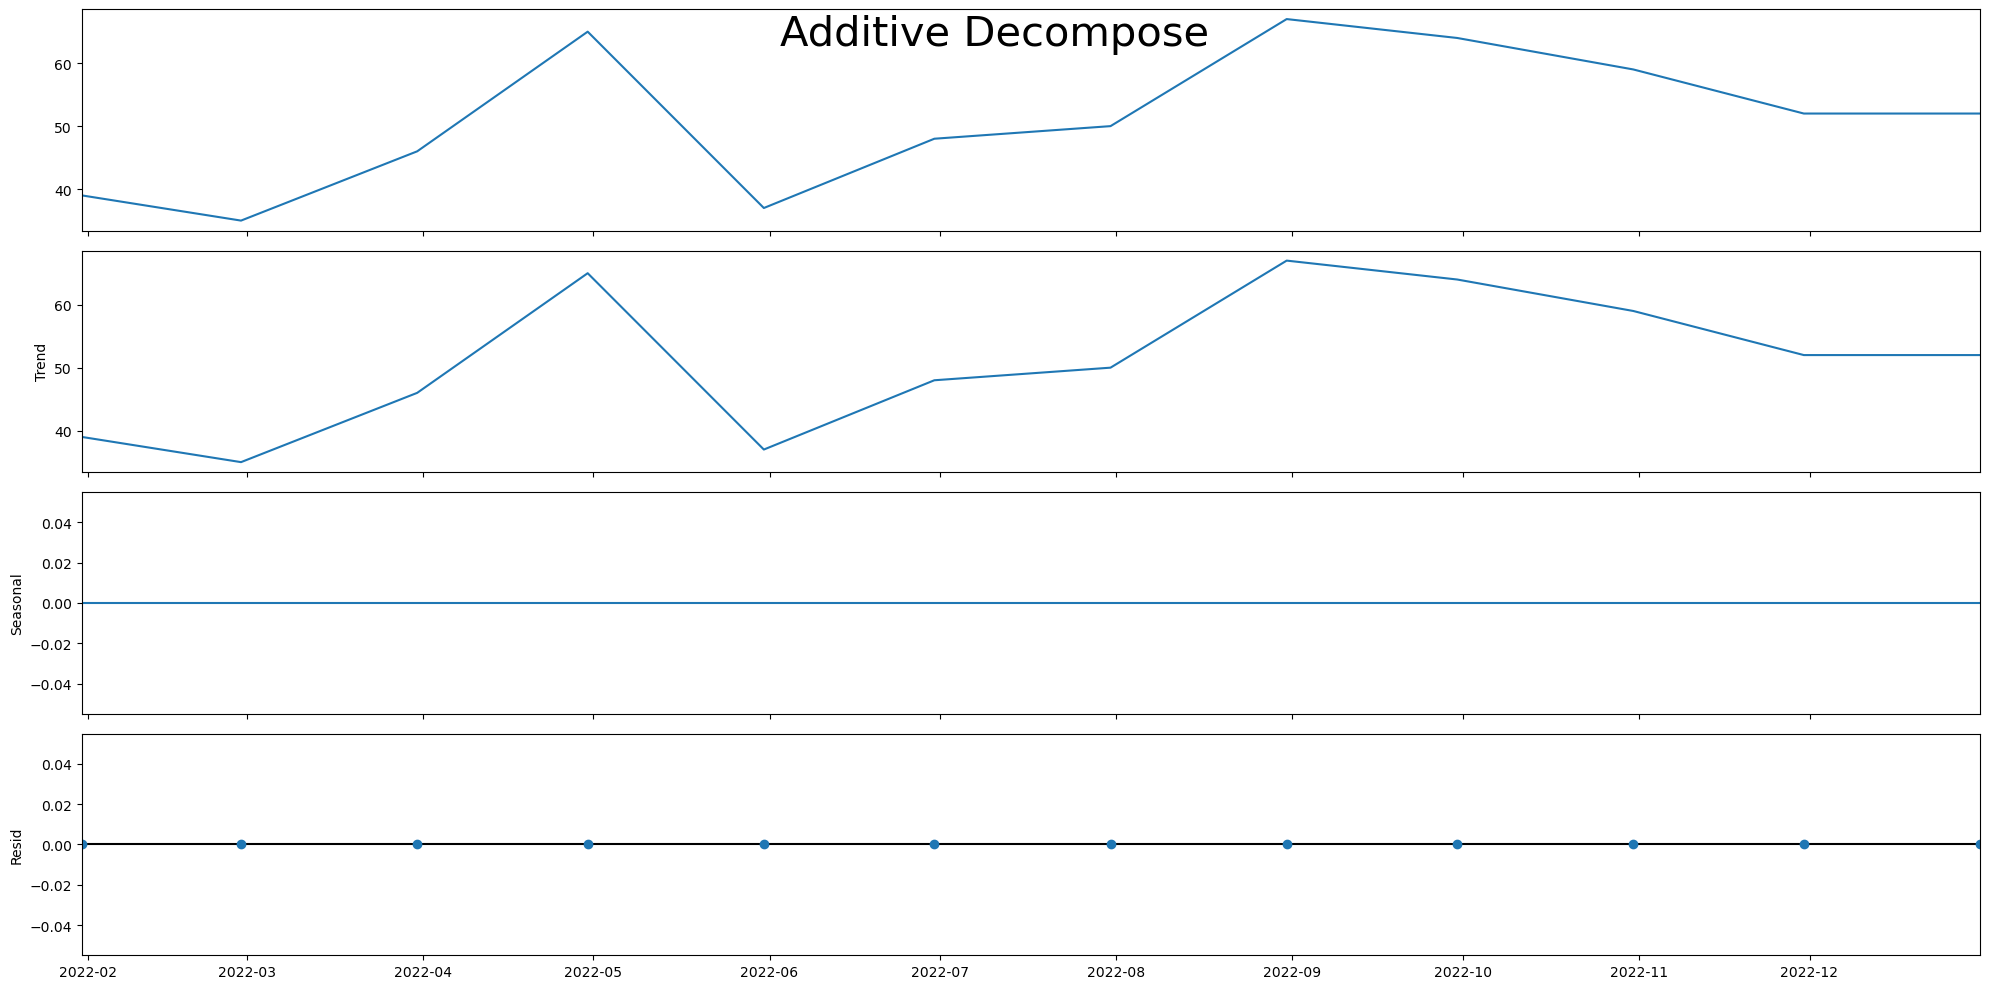

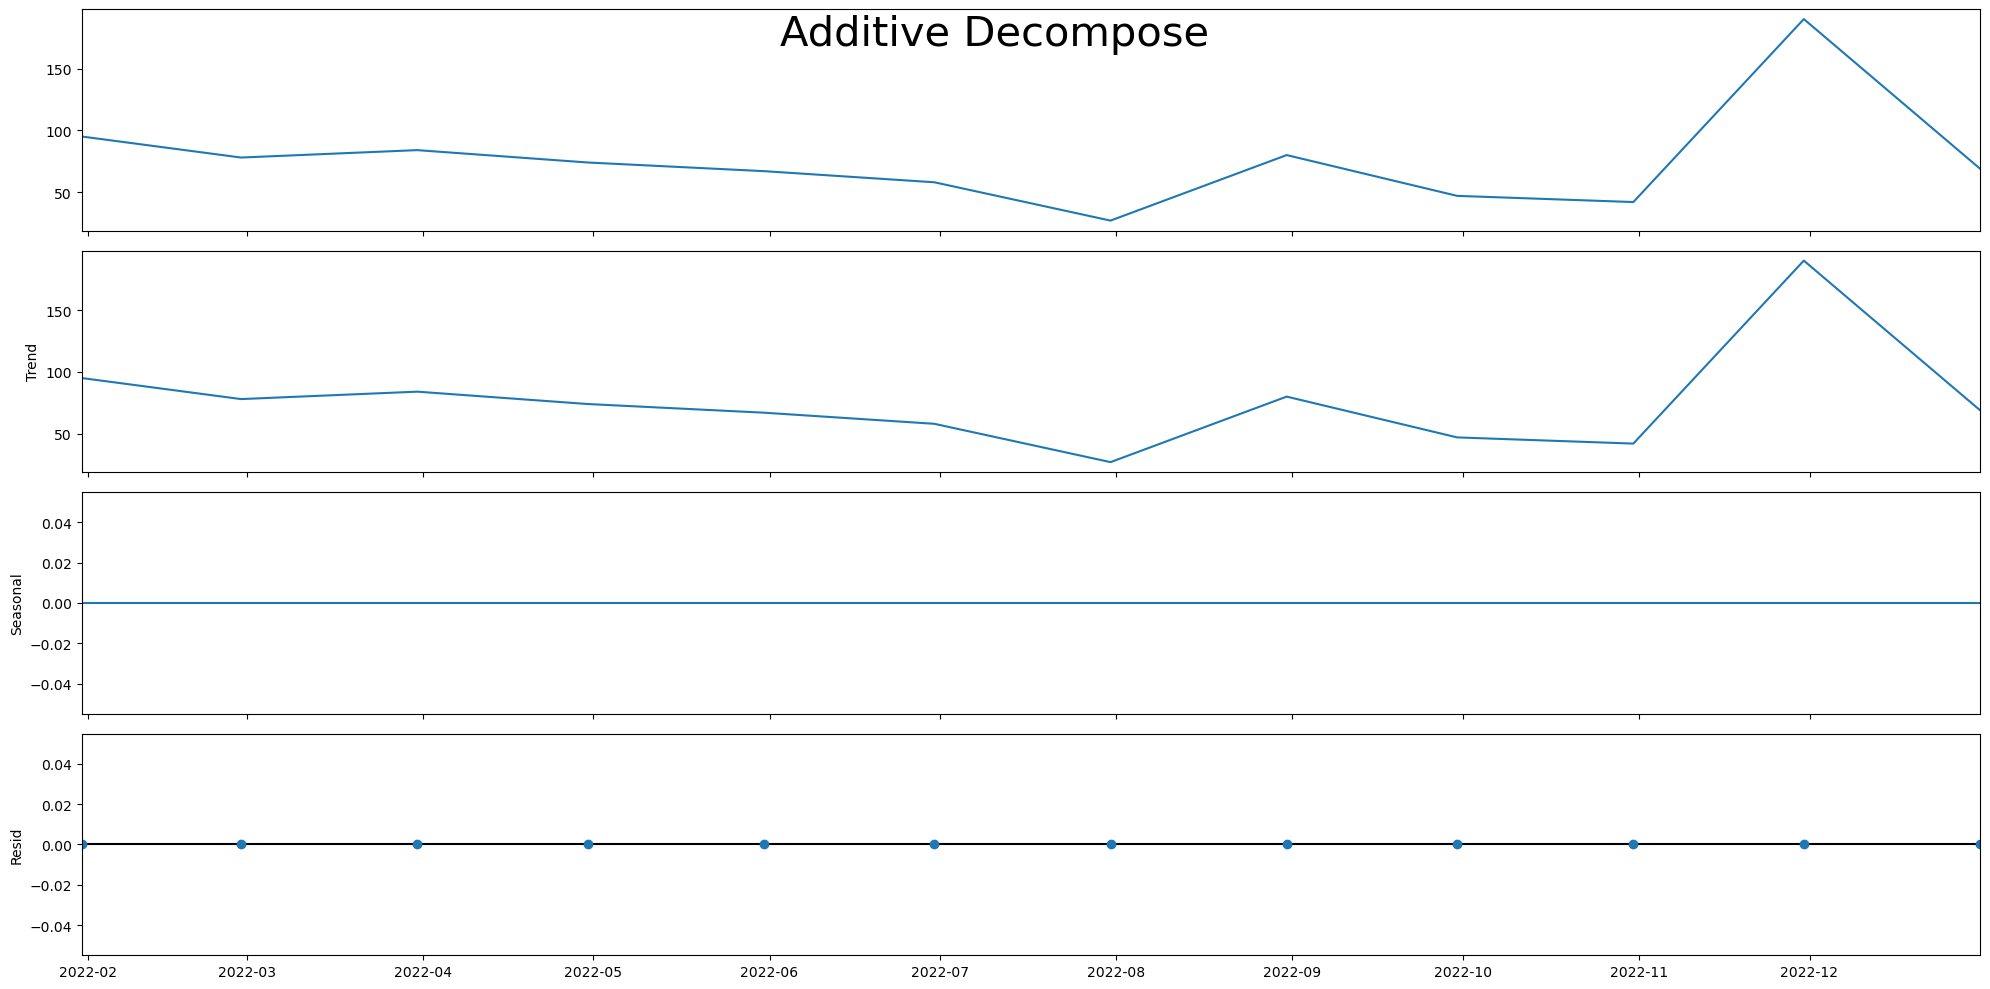

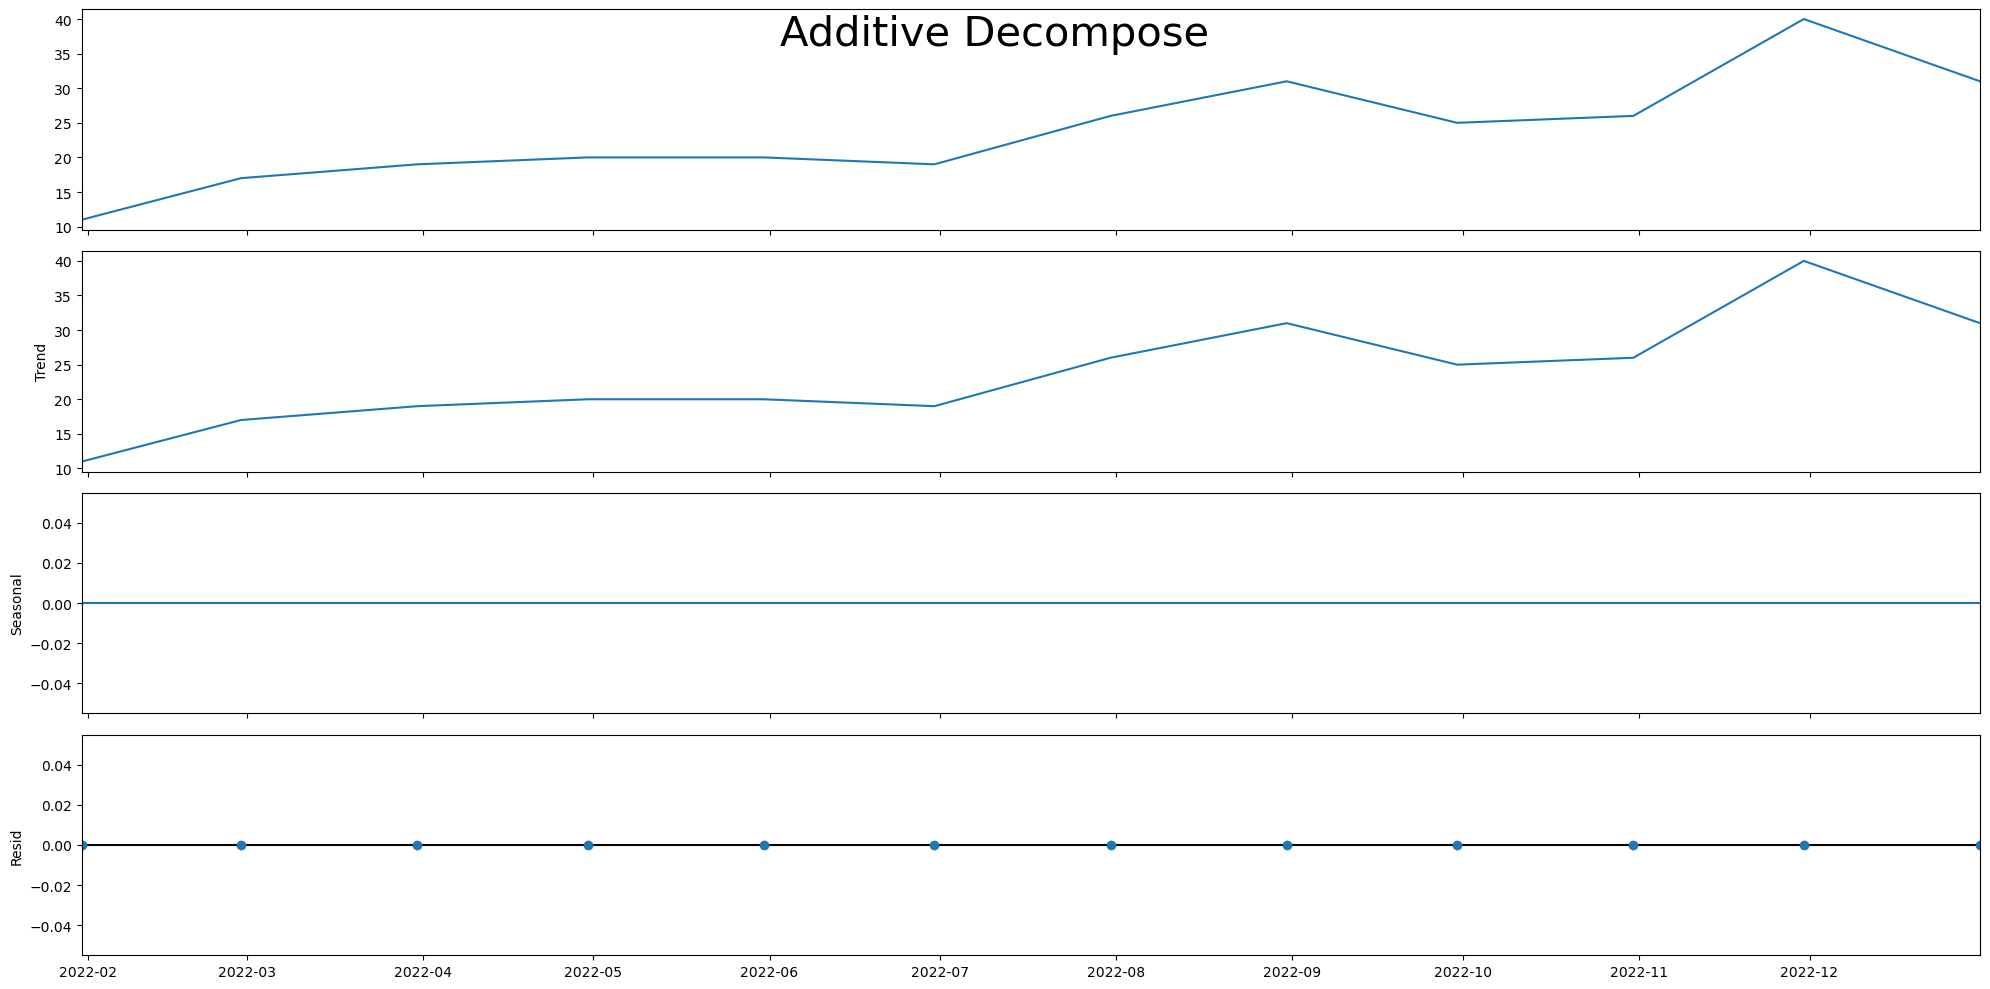

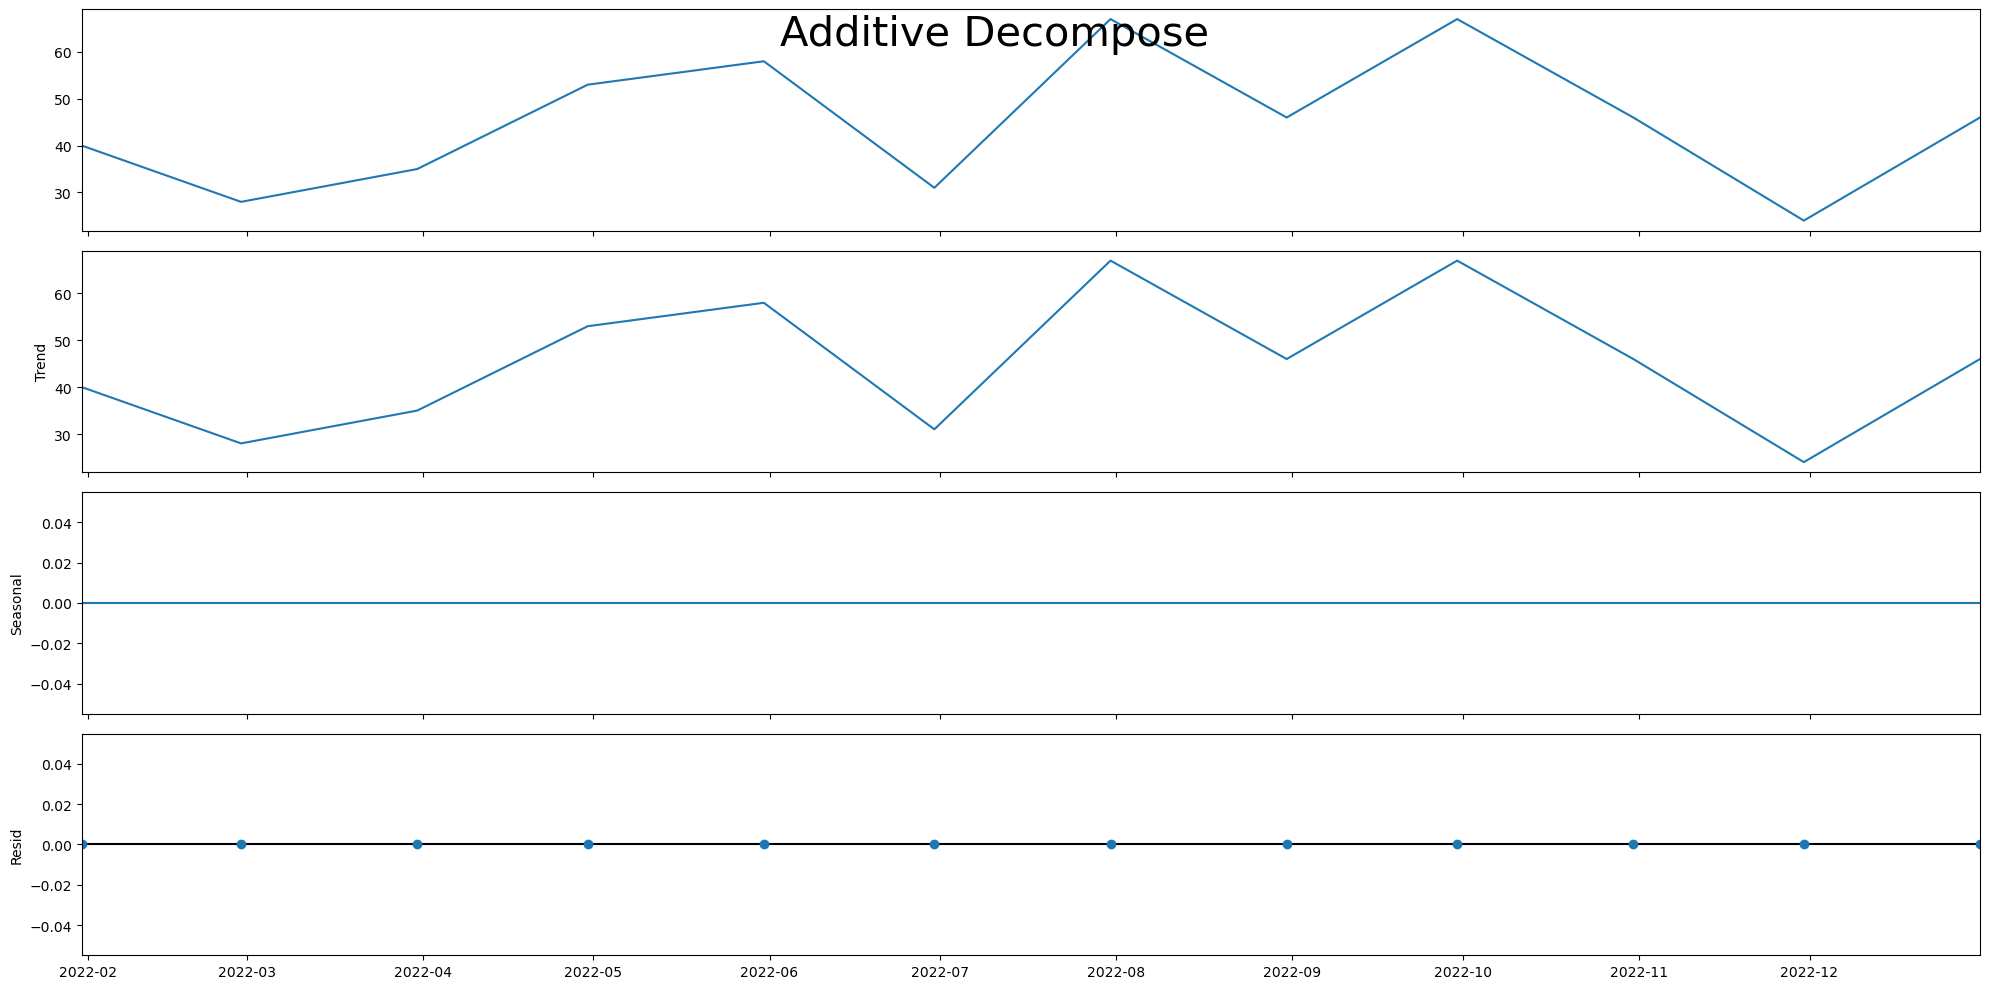

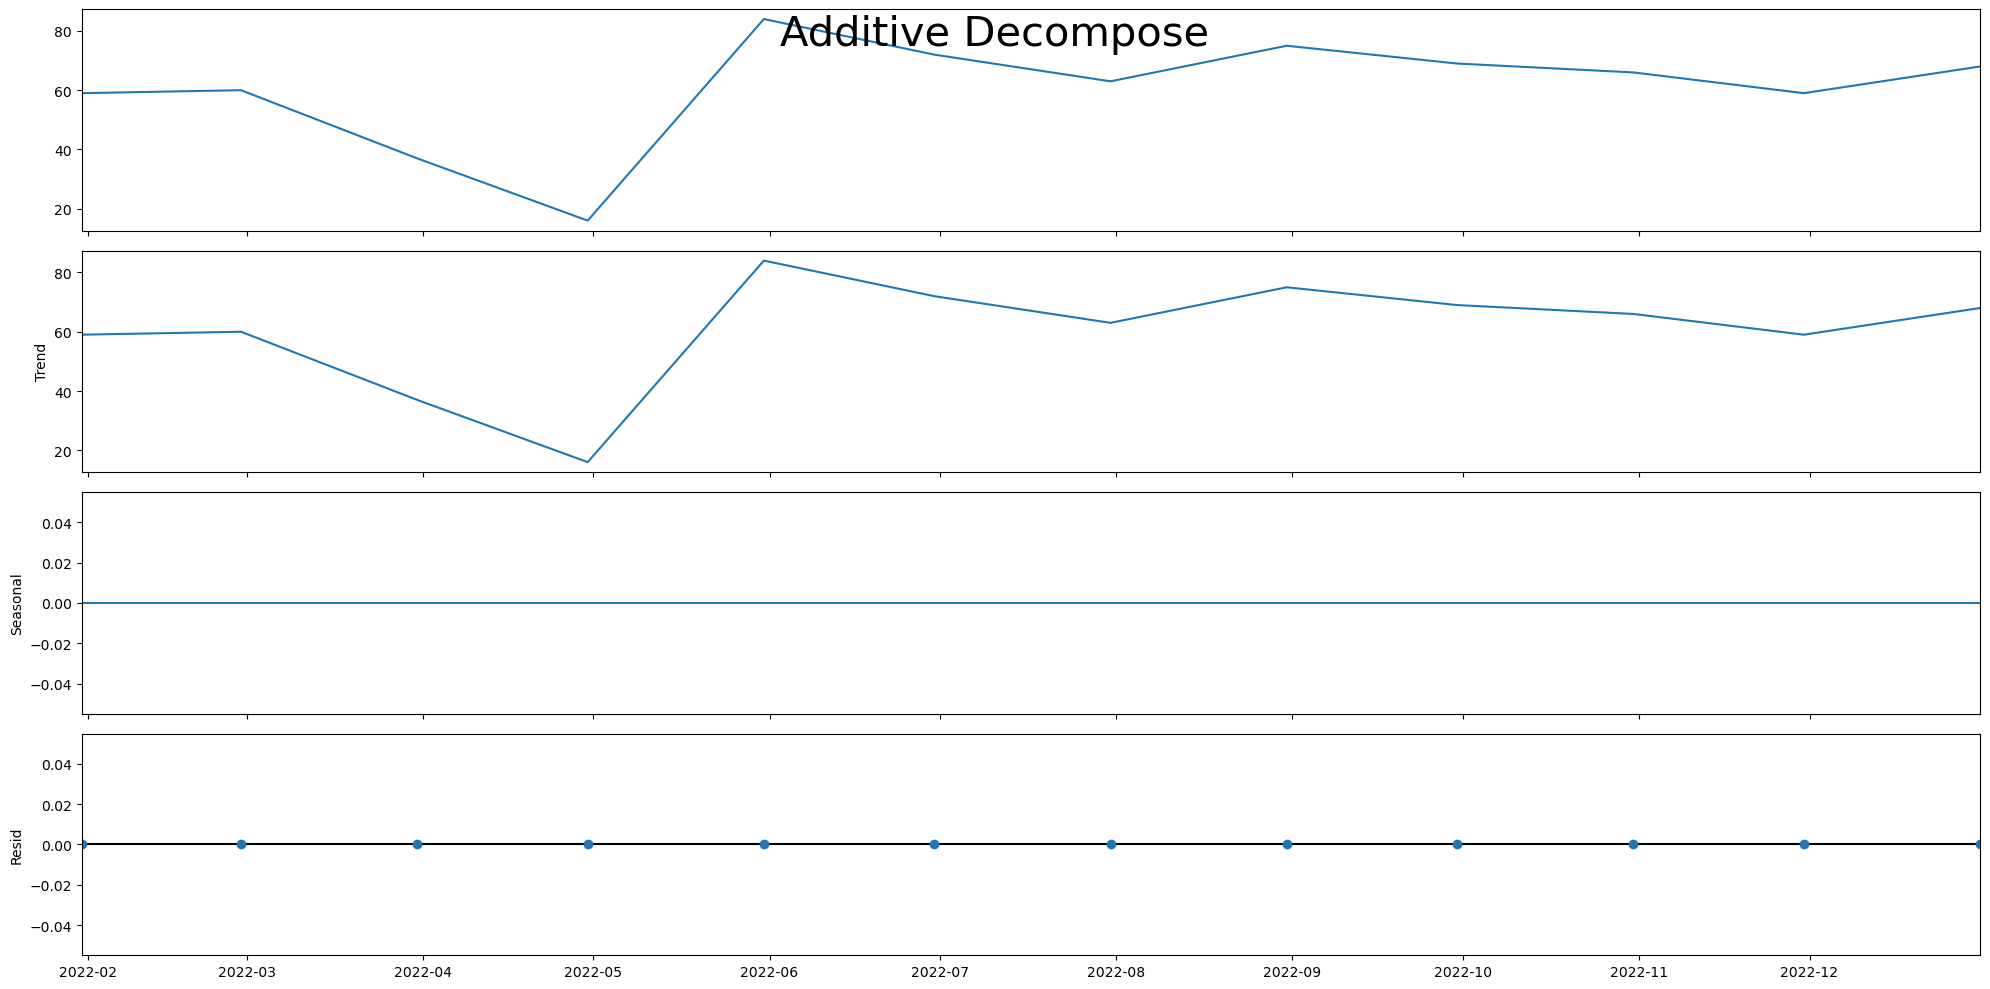

In [275]:
decompose(A)
decompose(A1)
decompose(A2)
decompose(A3)
decompose(A4)
decompose(A5)
decompose(A6)
decompose(A7)
decompose(A8)
decompose(A9)

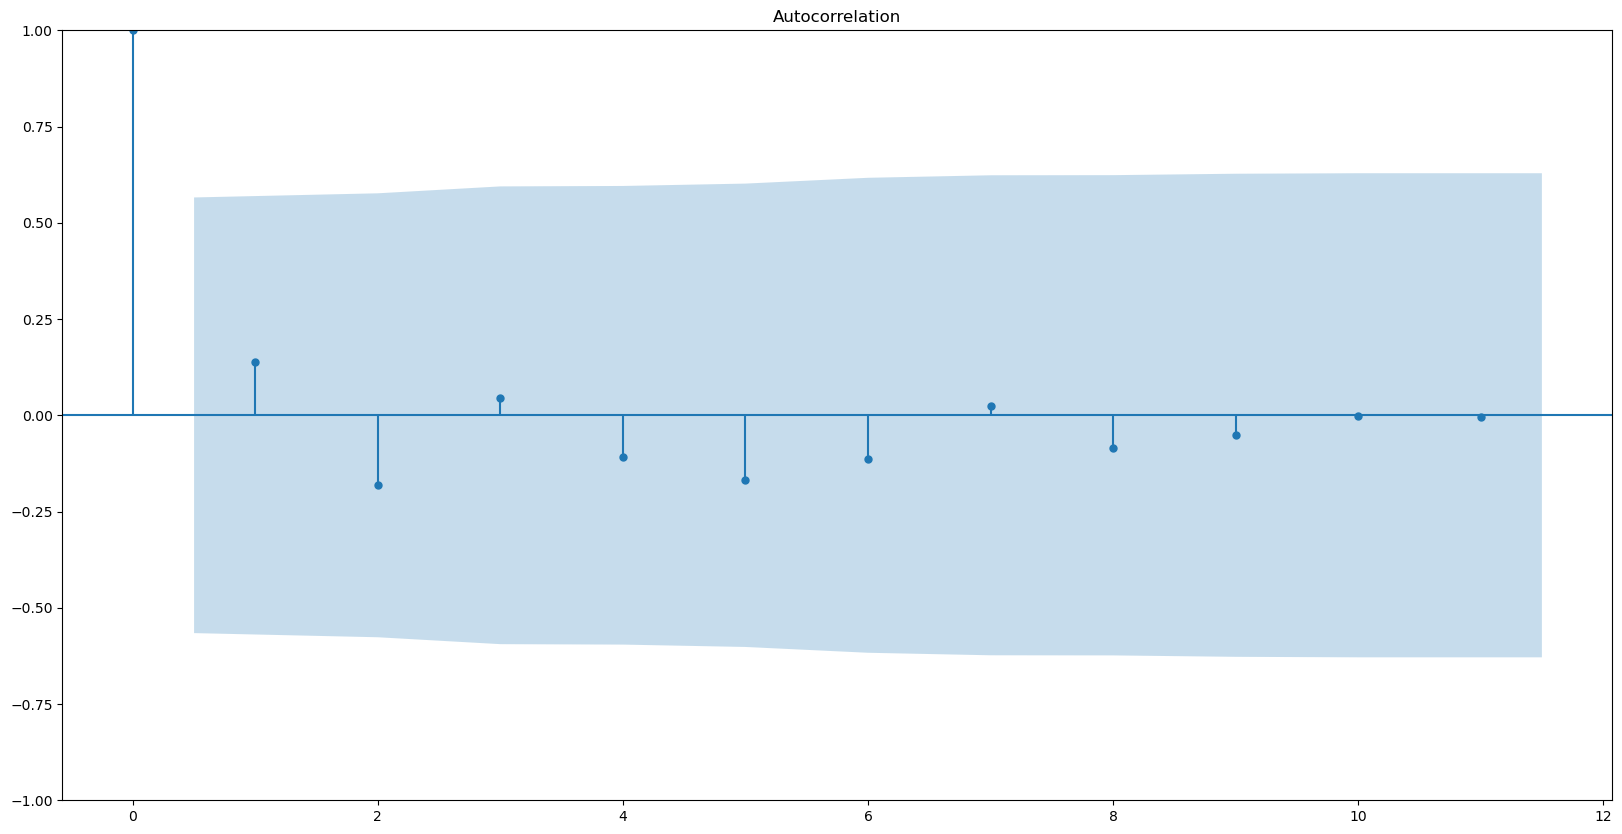

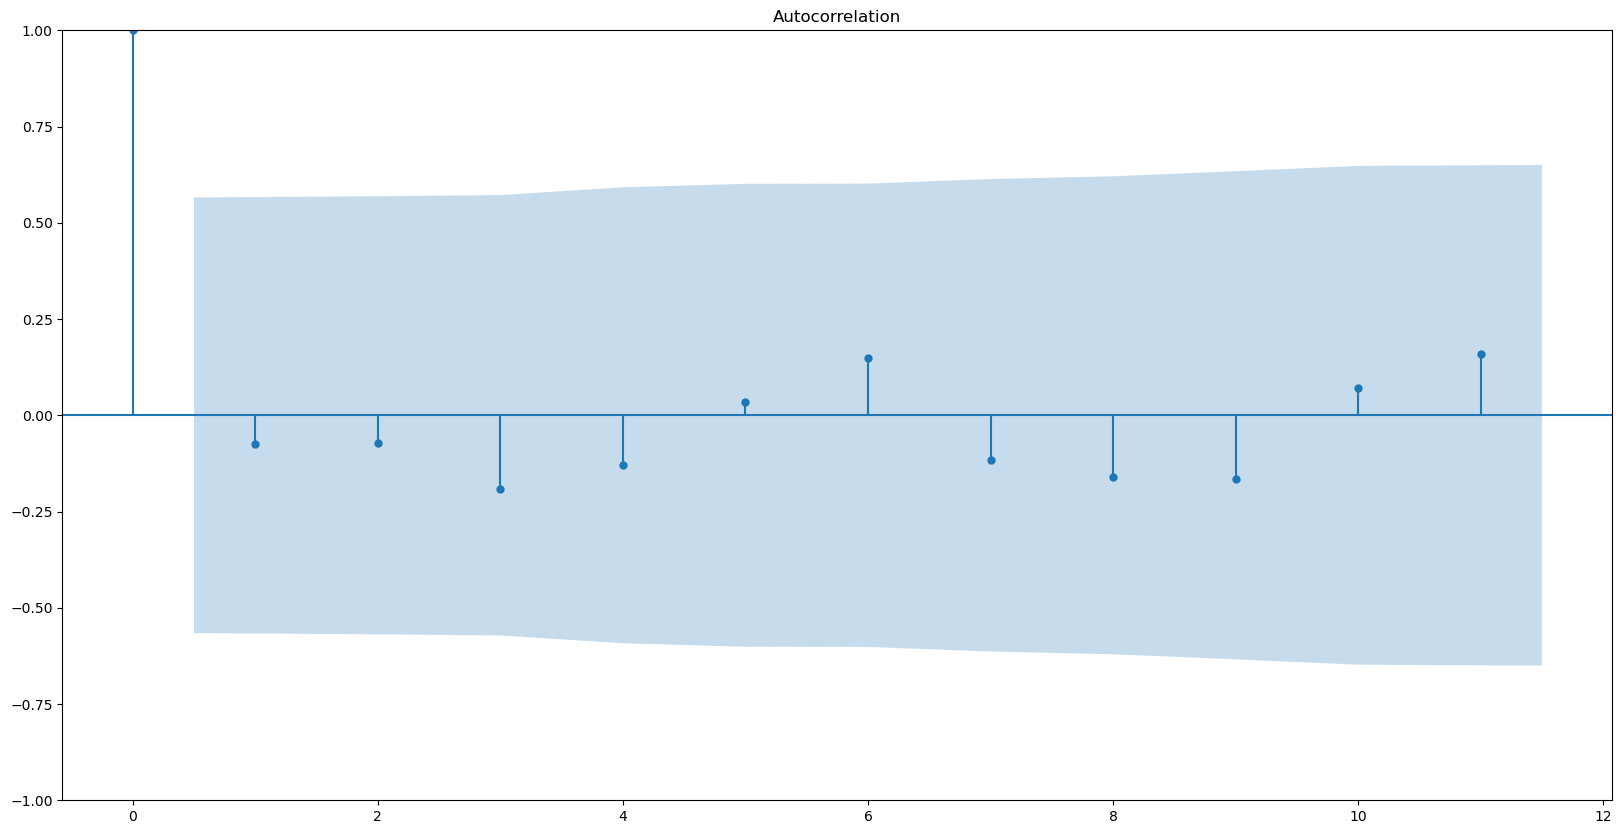

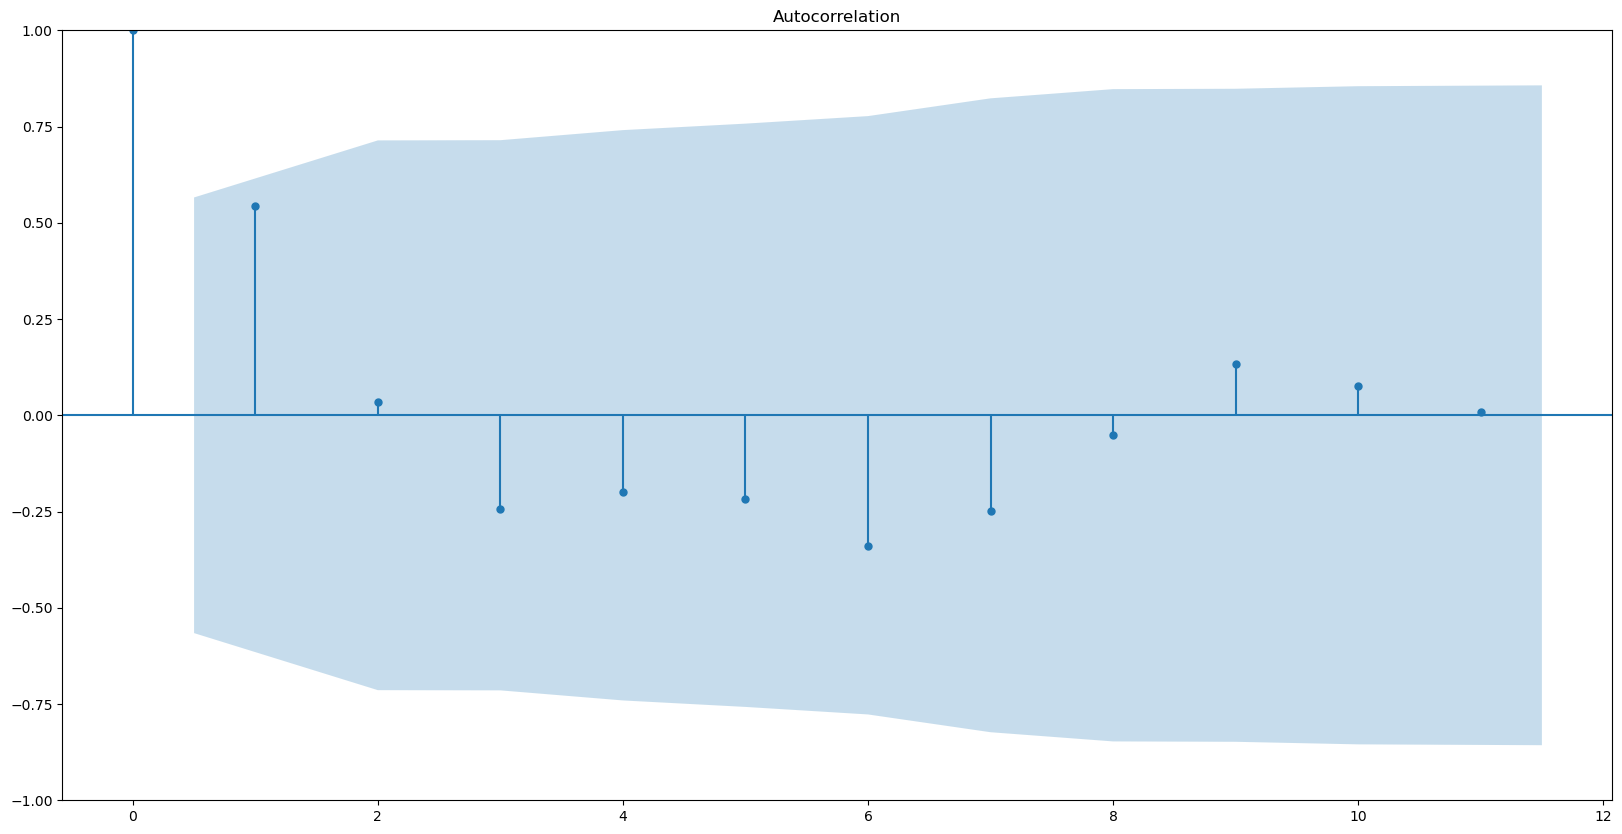

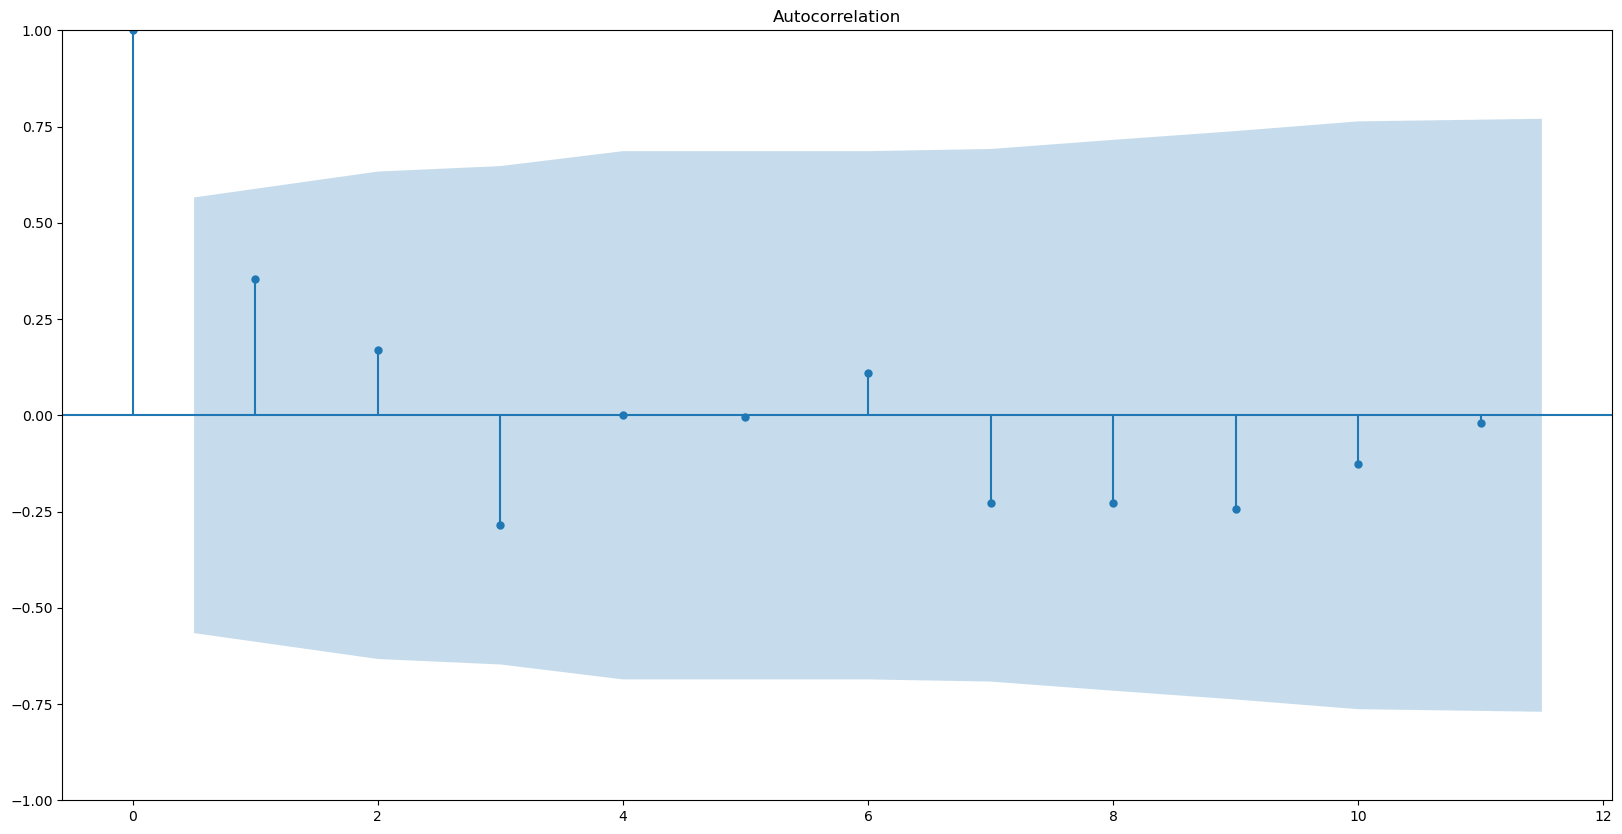

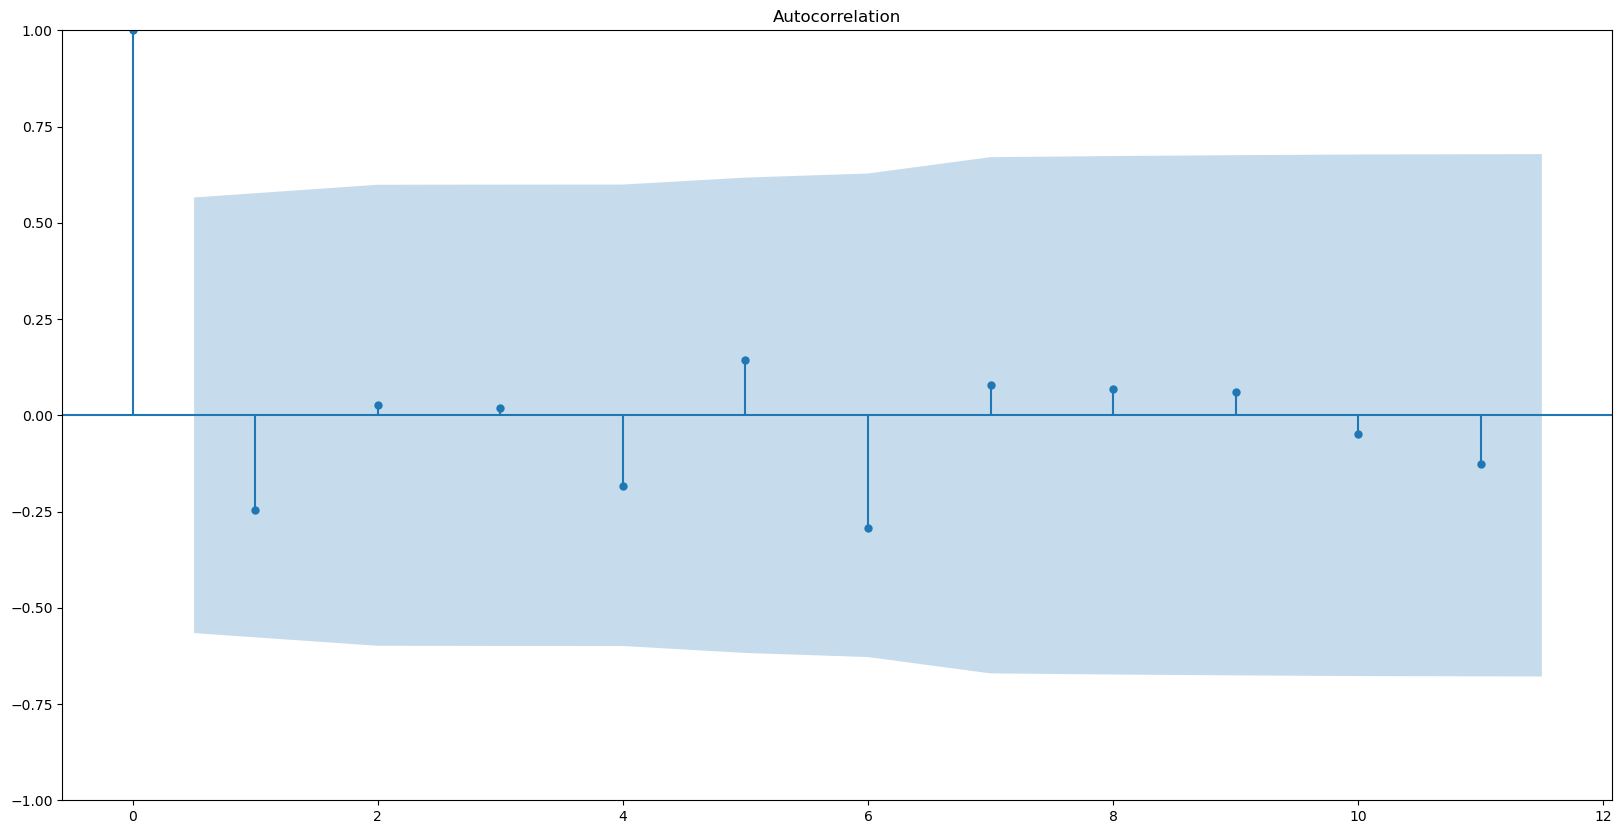

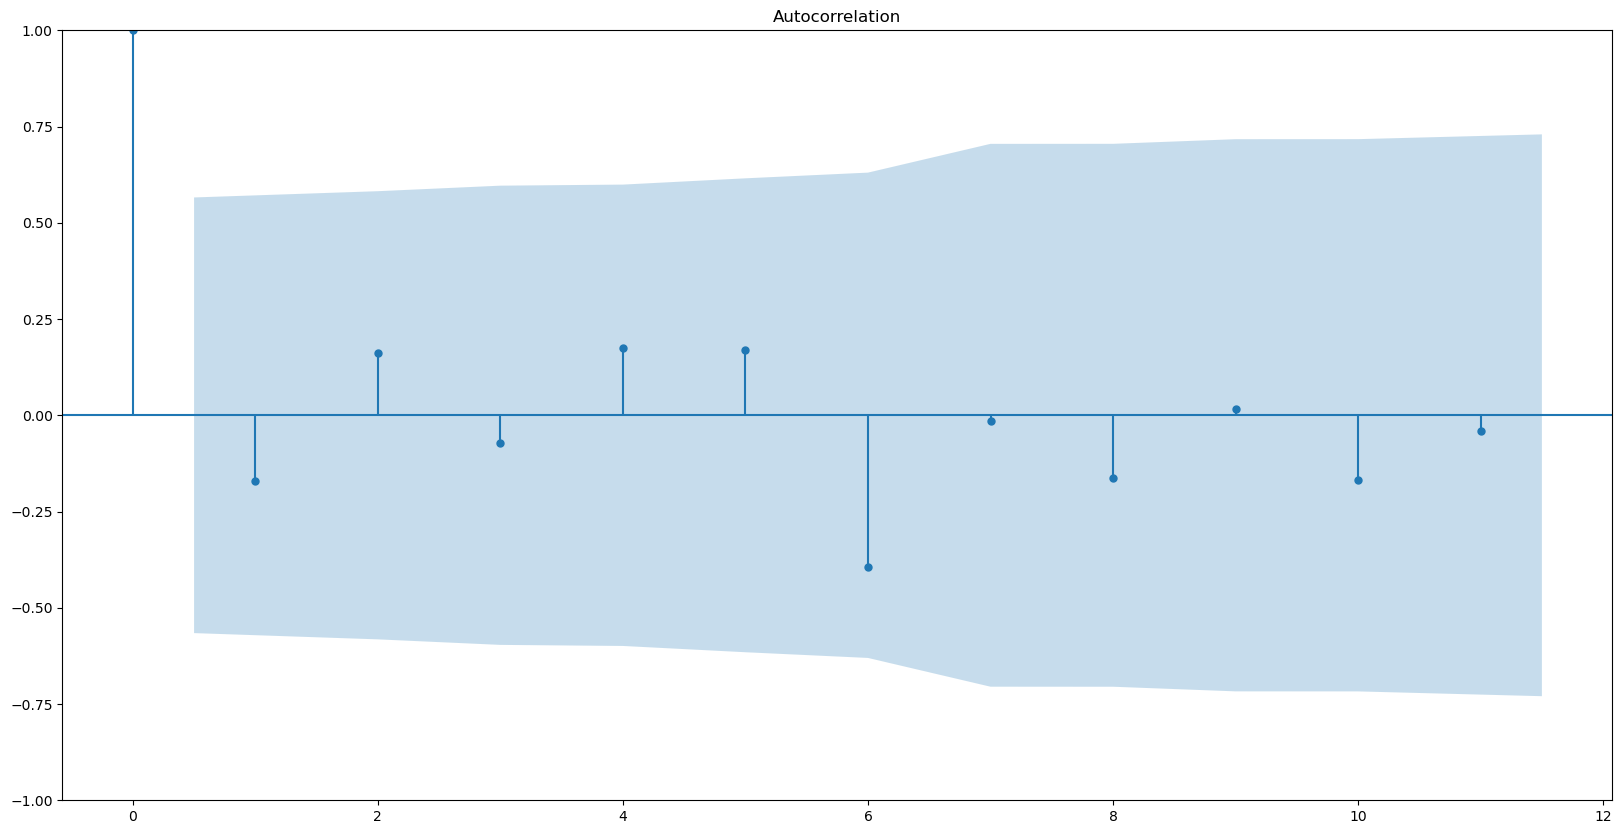

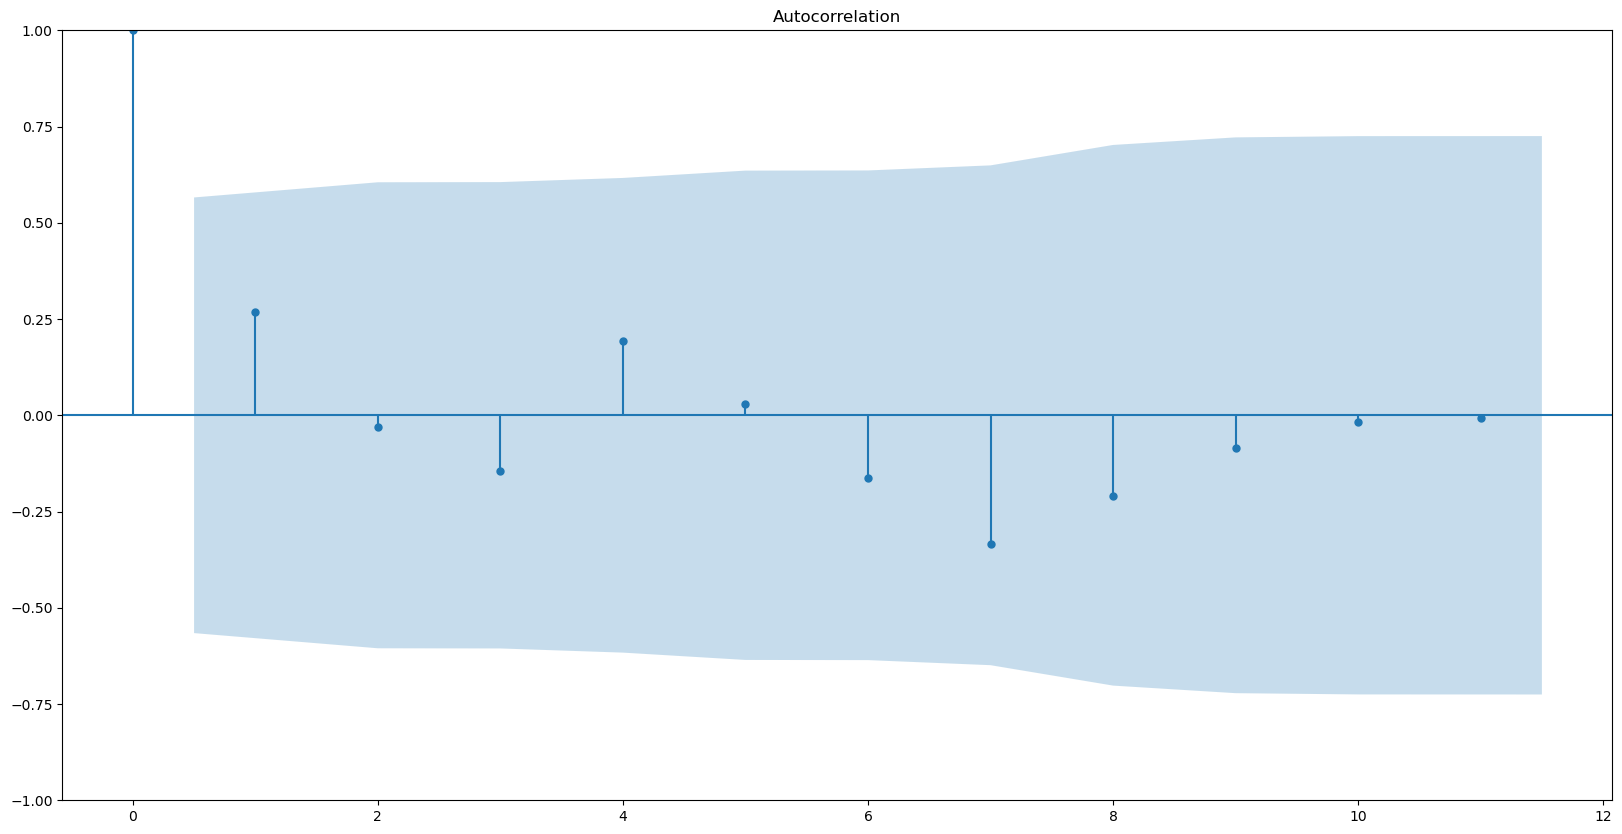

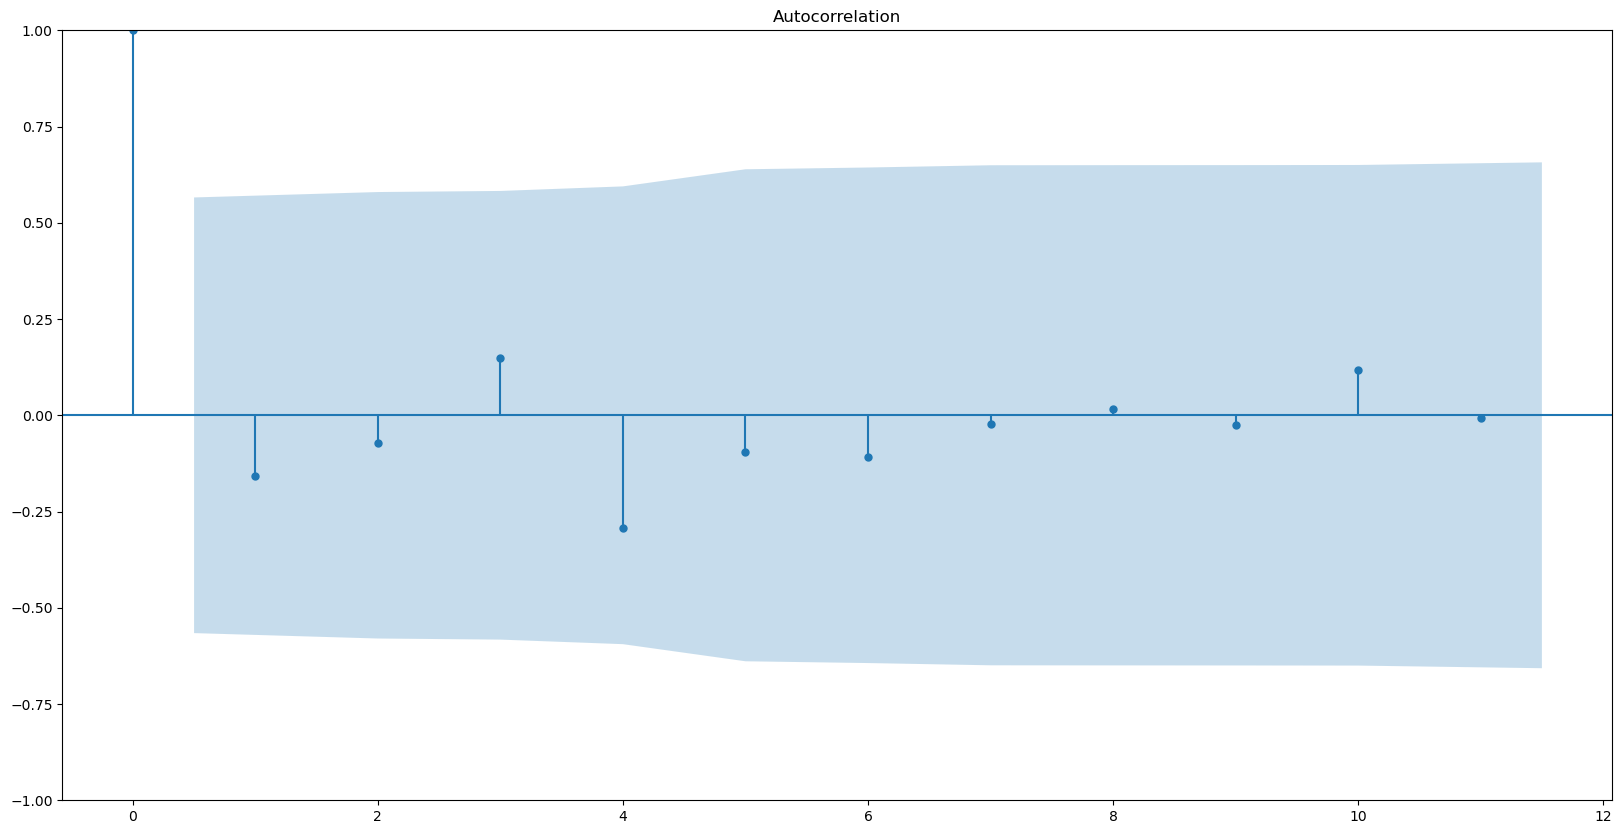

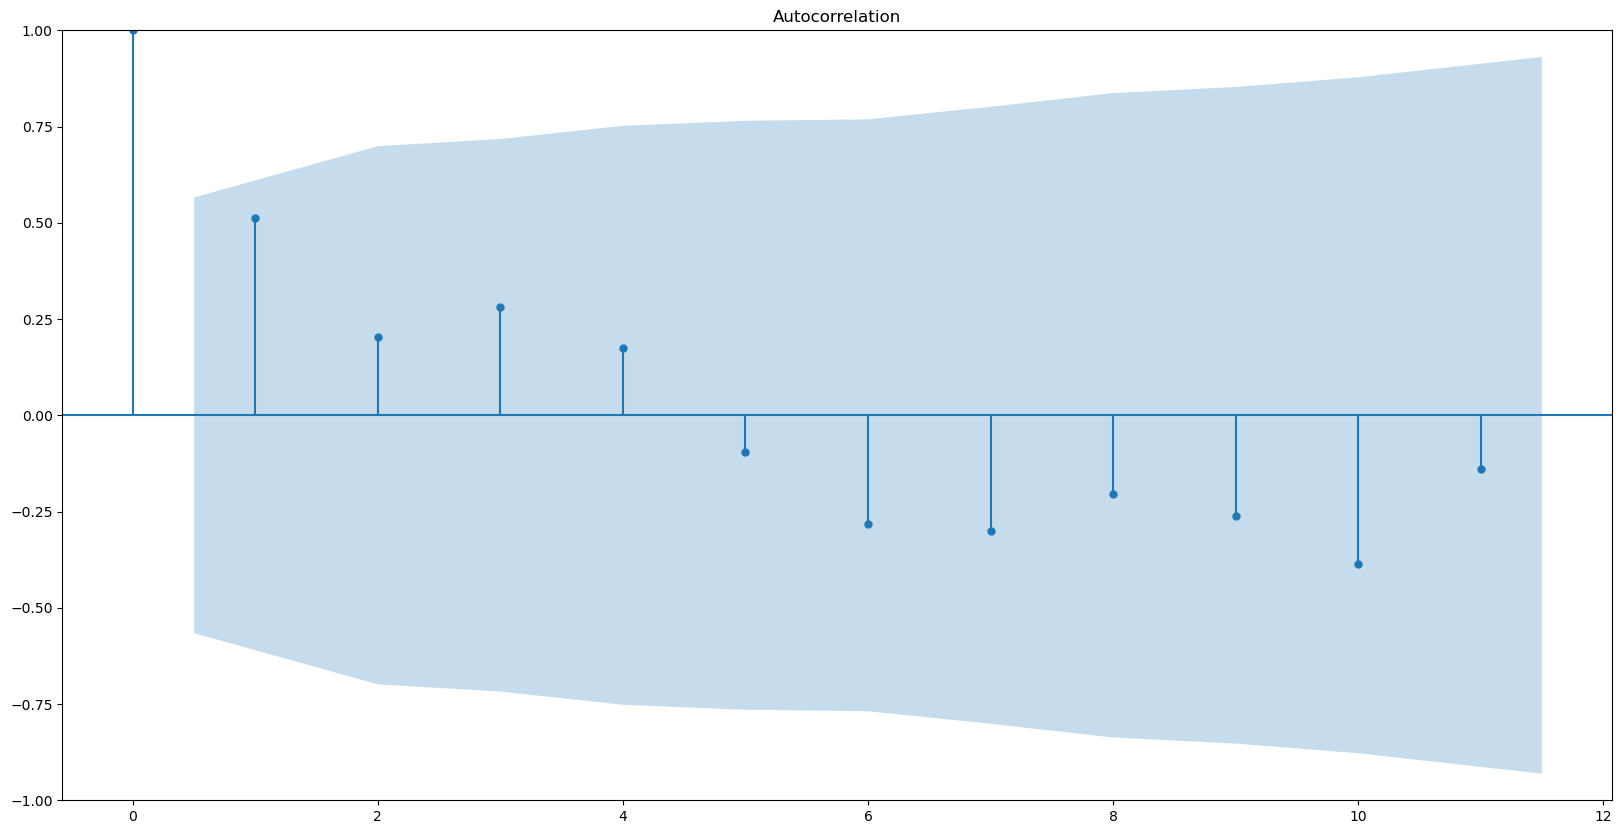

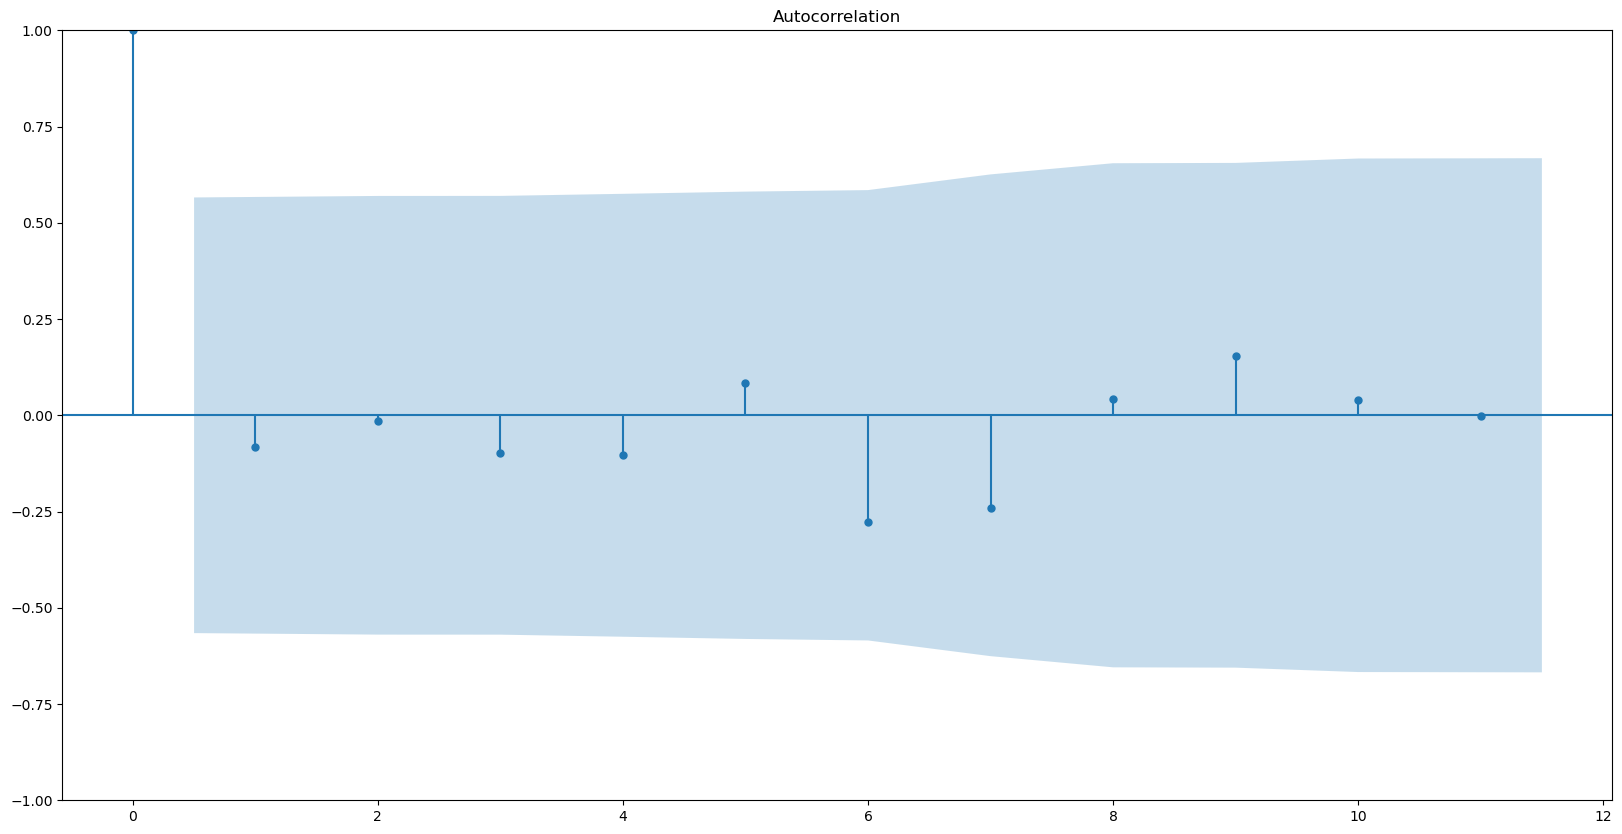

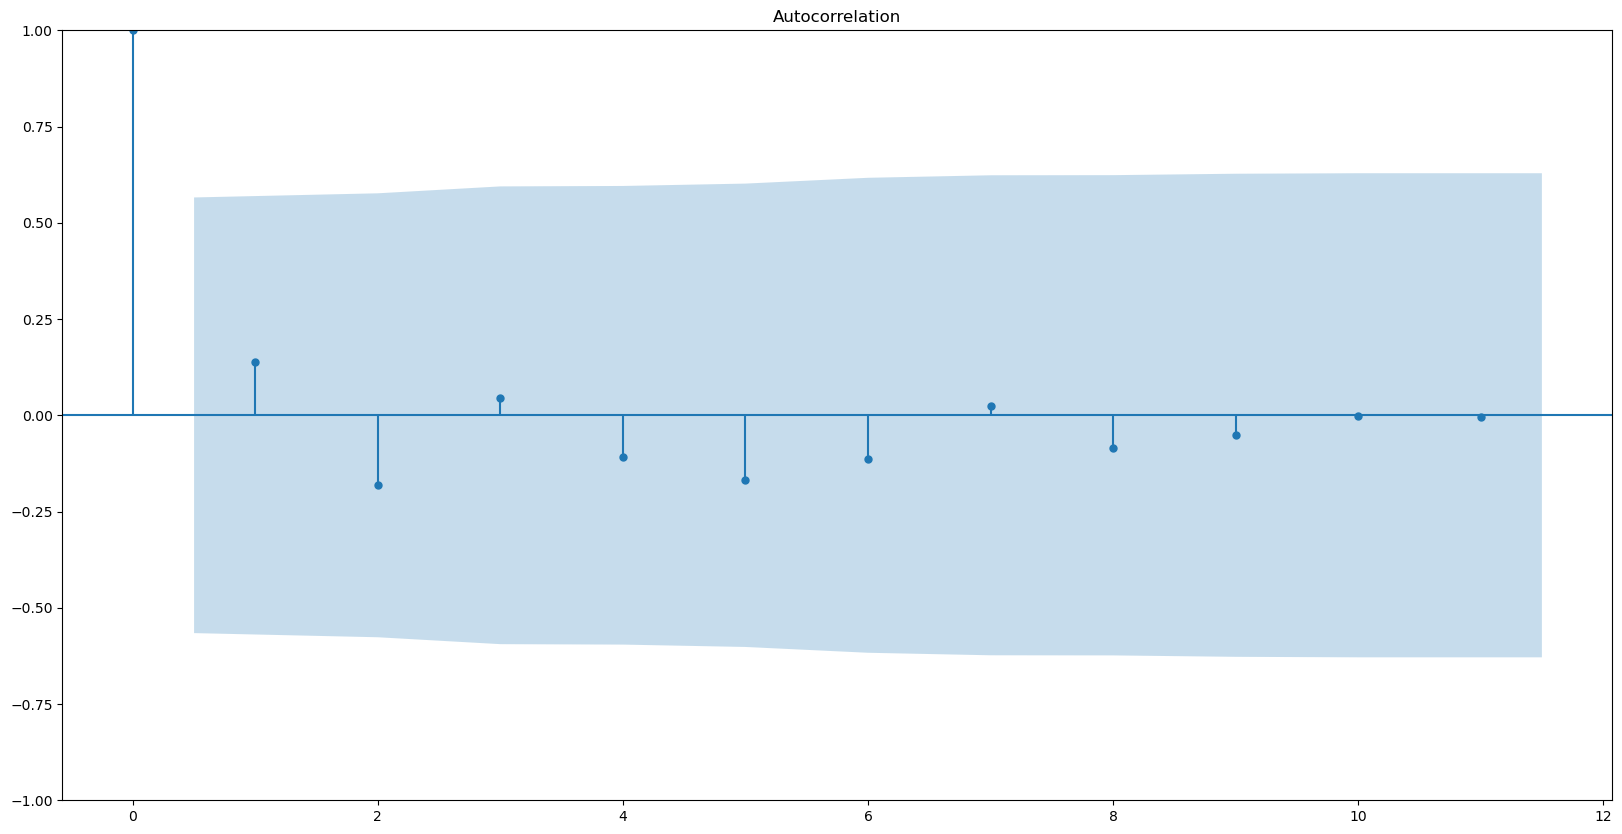

In [276]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(A)  
plot_acf(A1) 
plot_acf(A2) 
plot_acf(A3) 
plot_acf(A4)
plot_acf(A5)  
plot_acf(A6) 
plot_acf(A7) 
plot_acf(A8) 
plot_acf(A9)

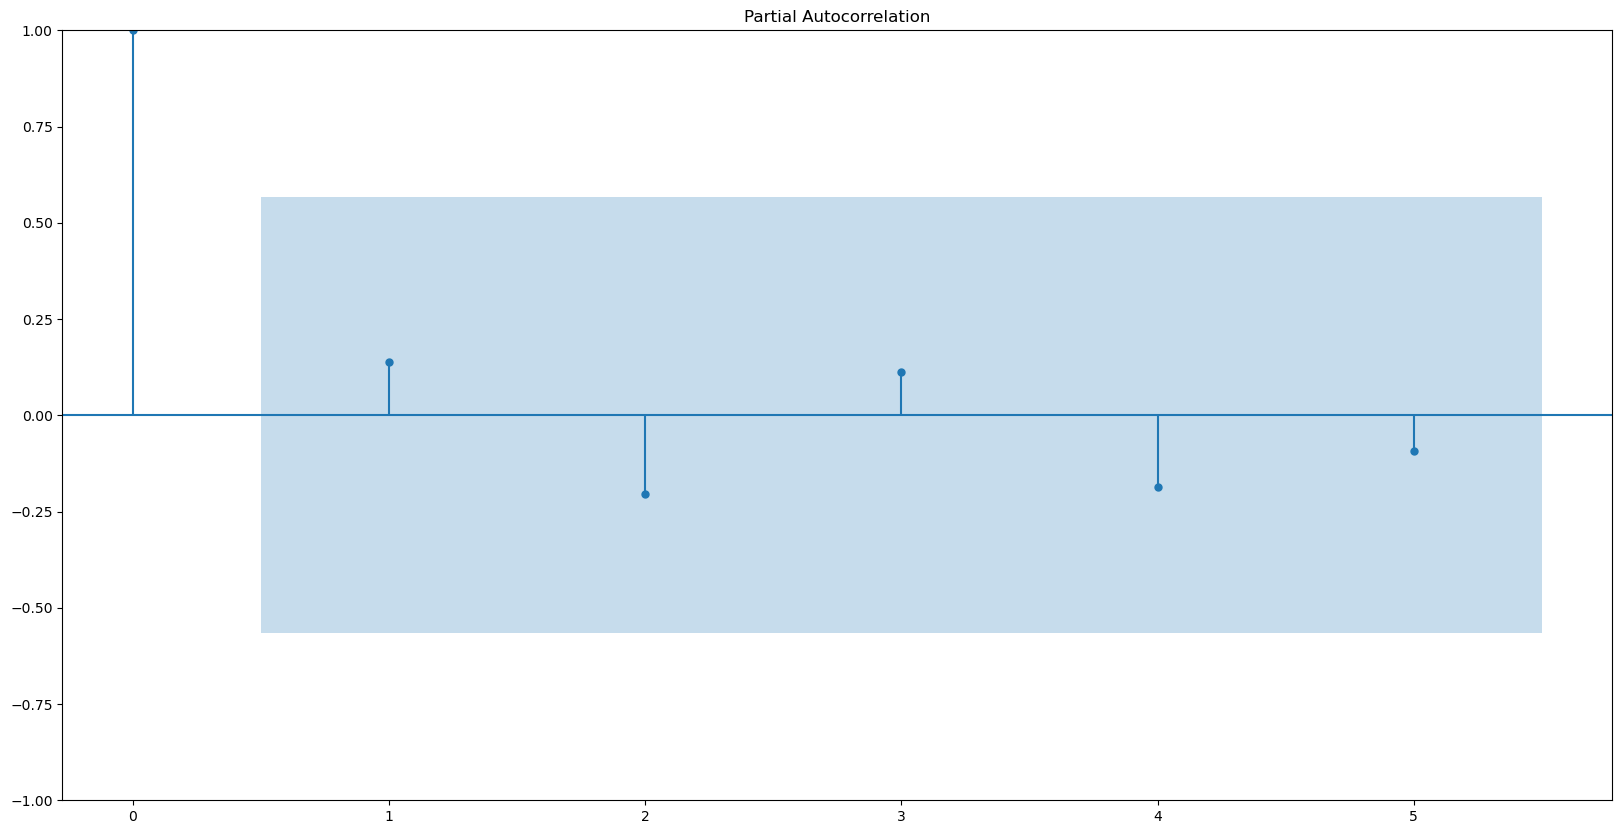

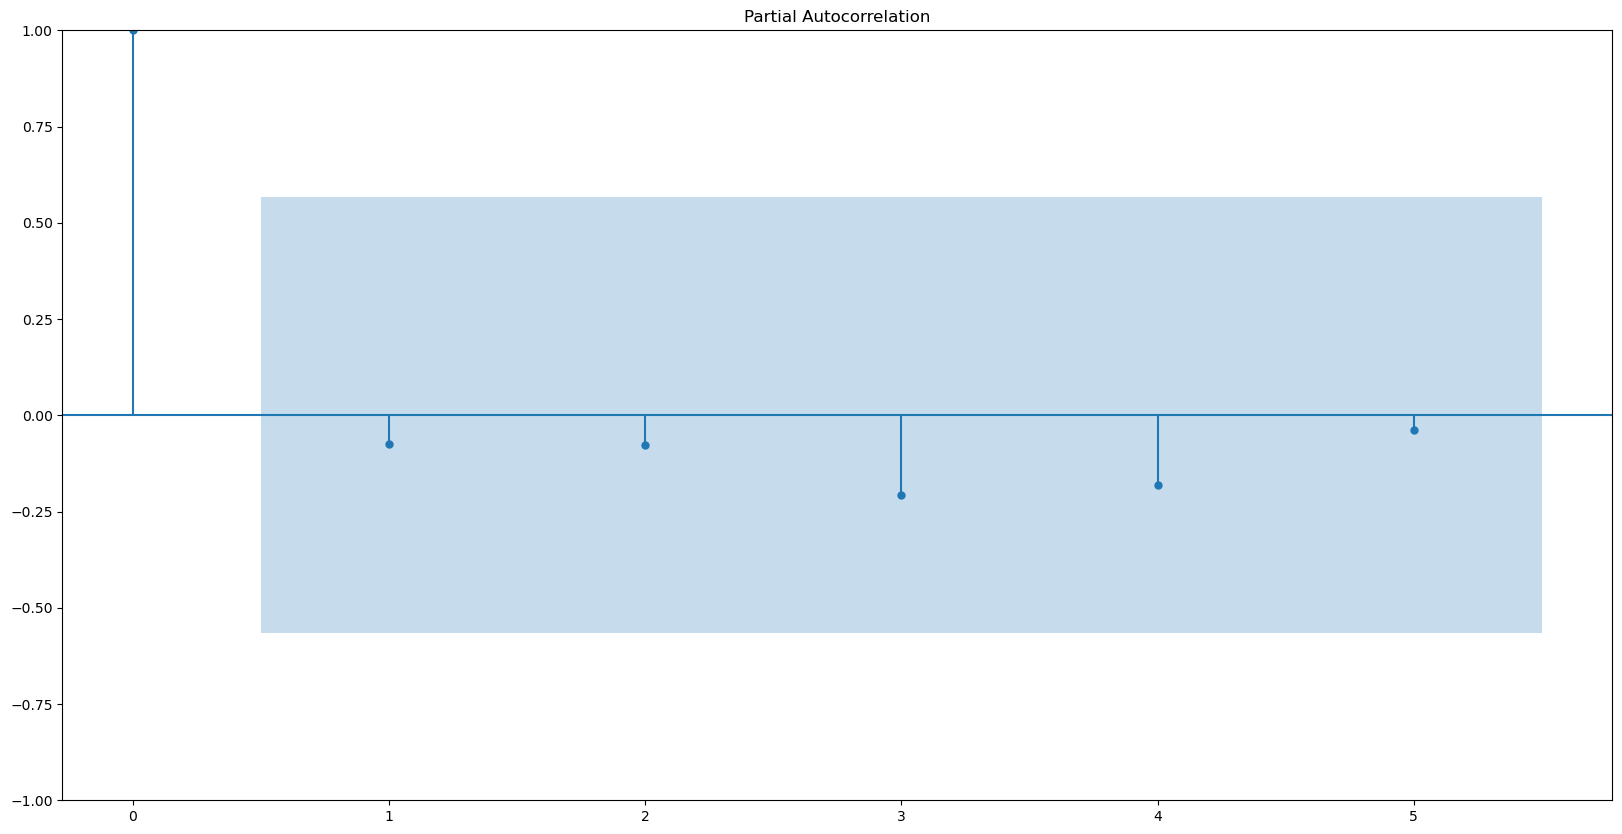

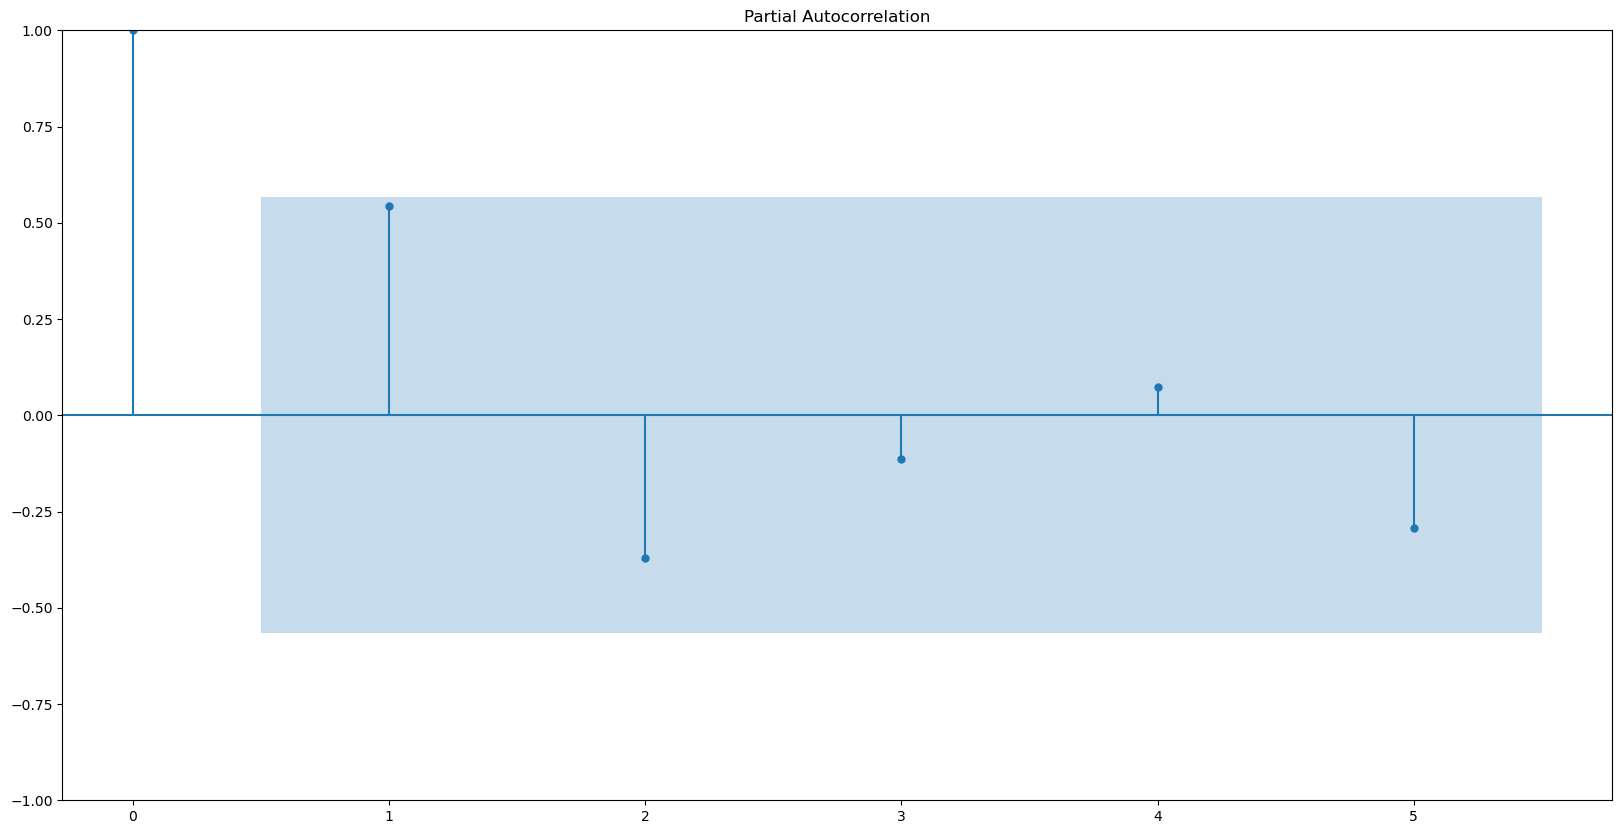

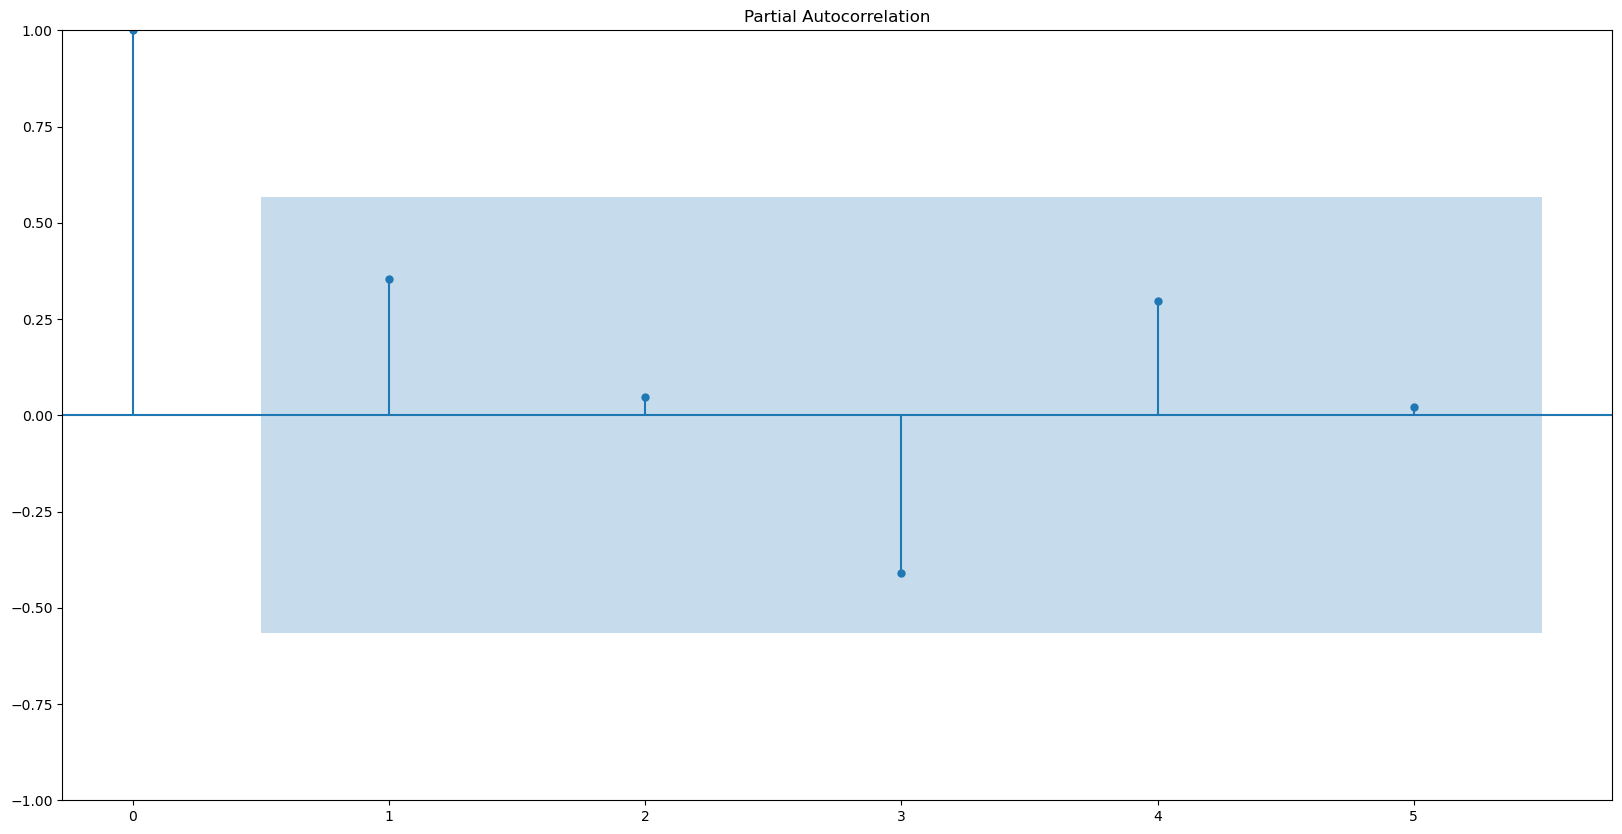

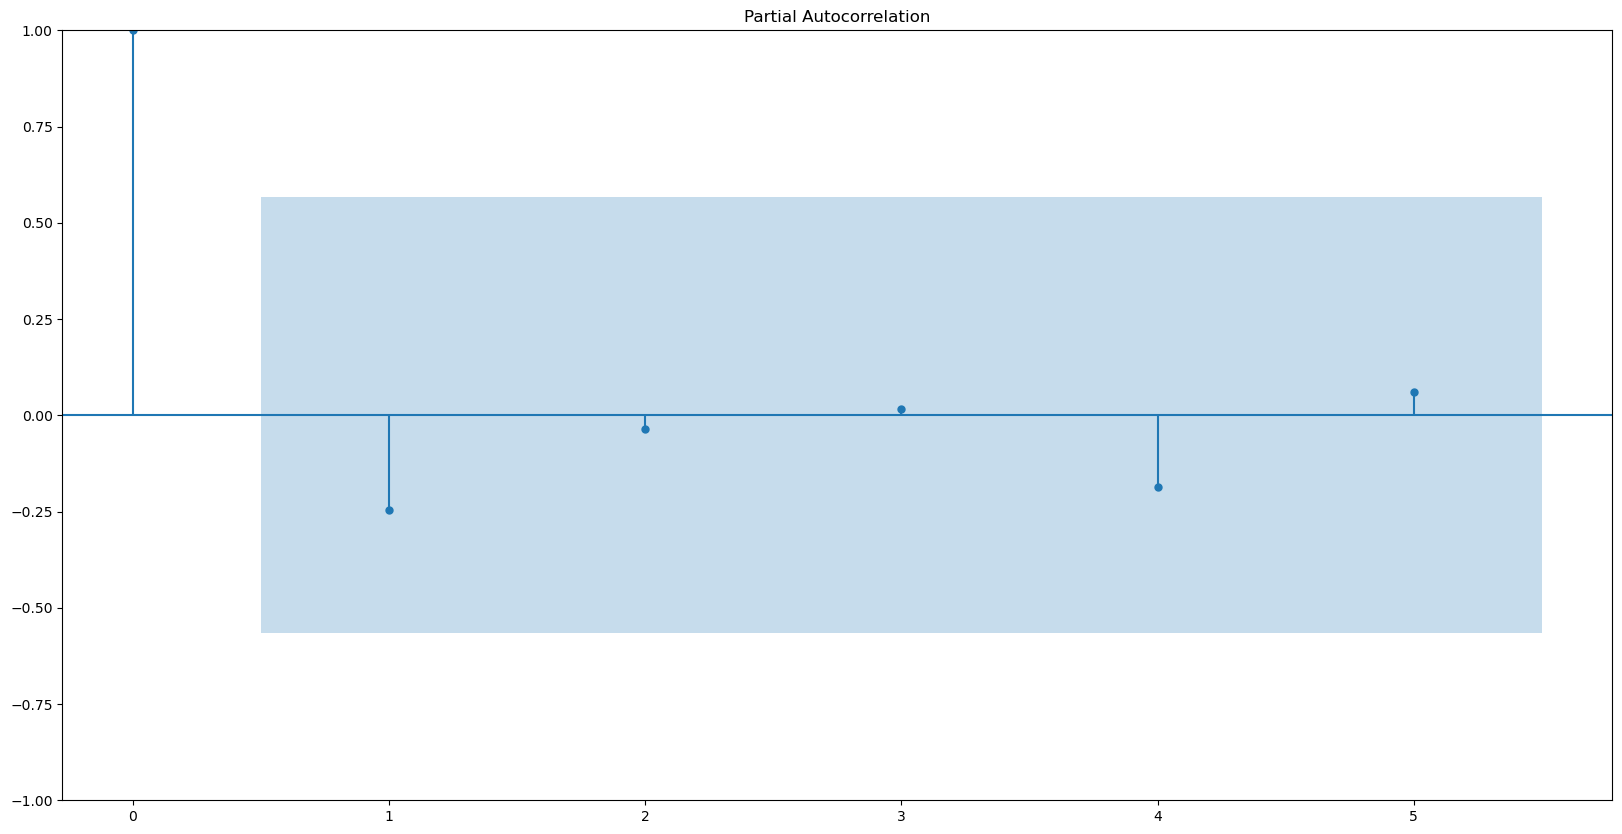

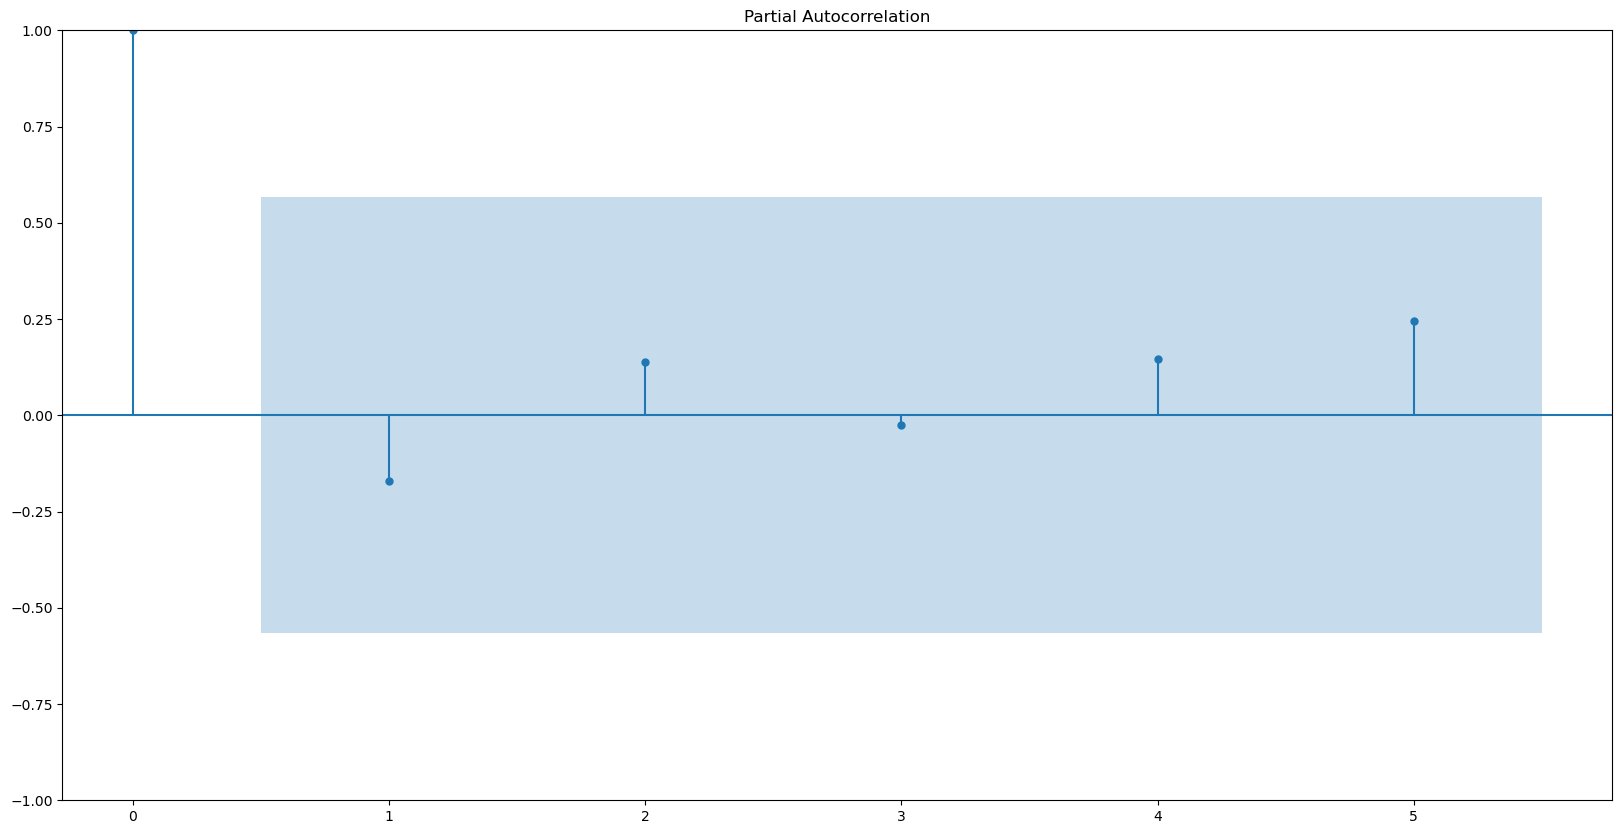

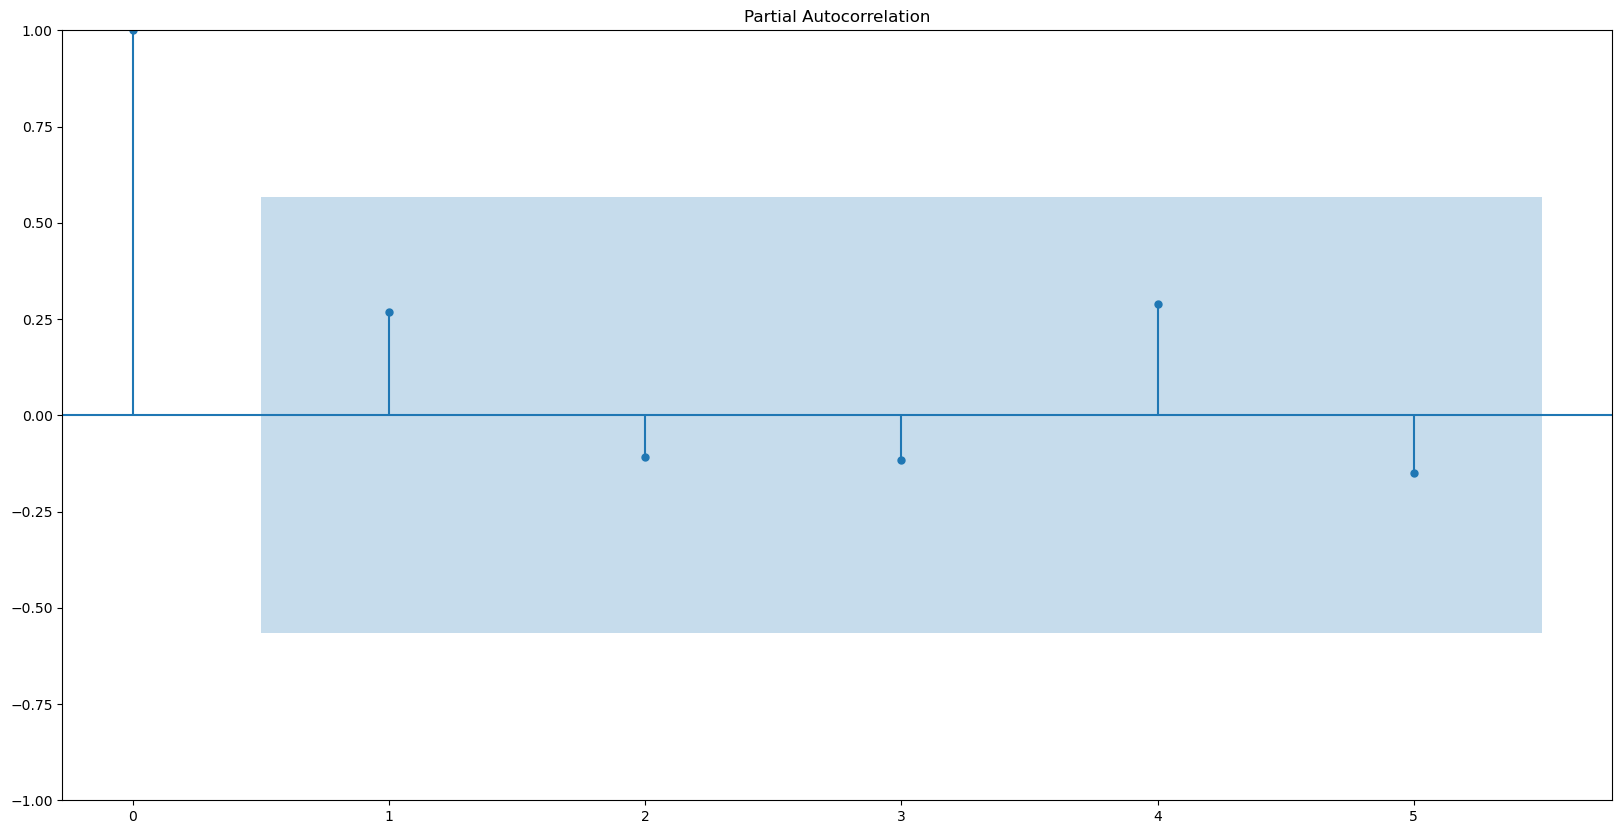

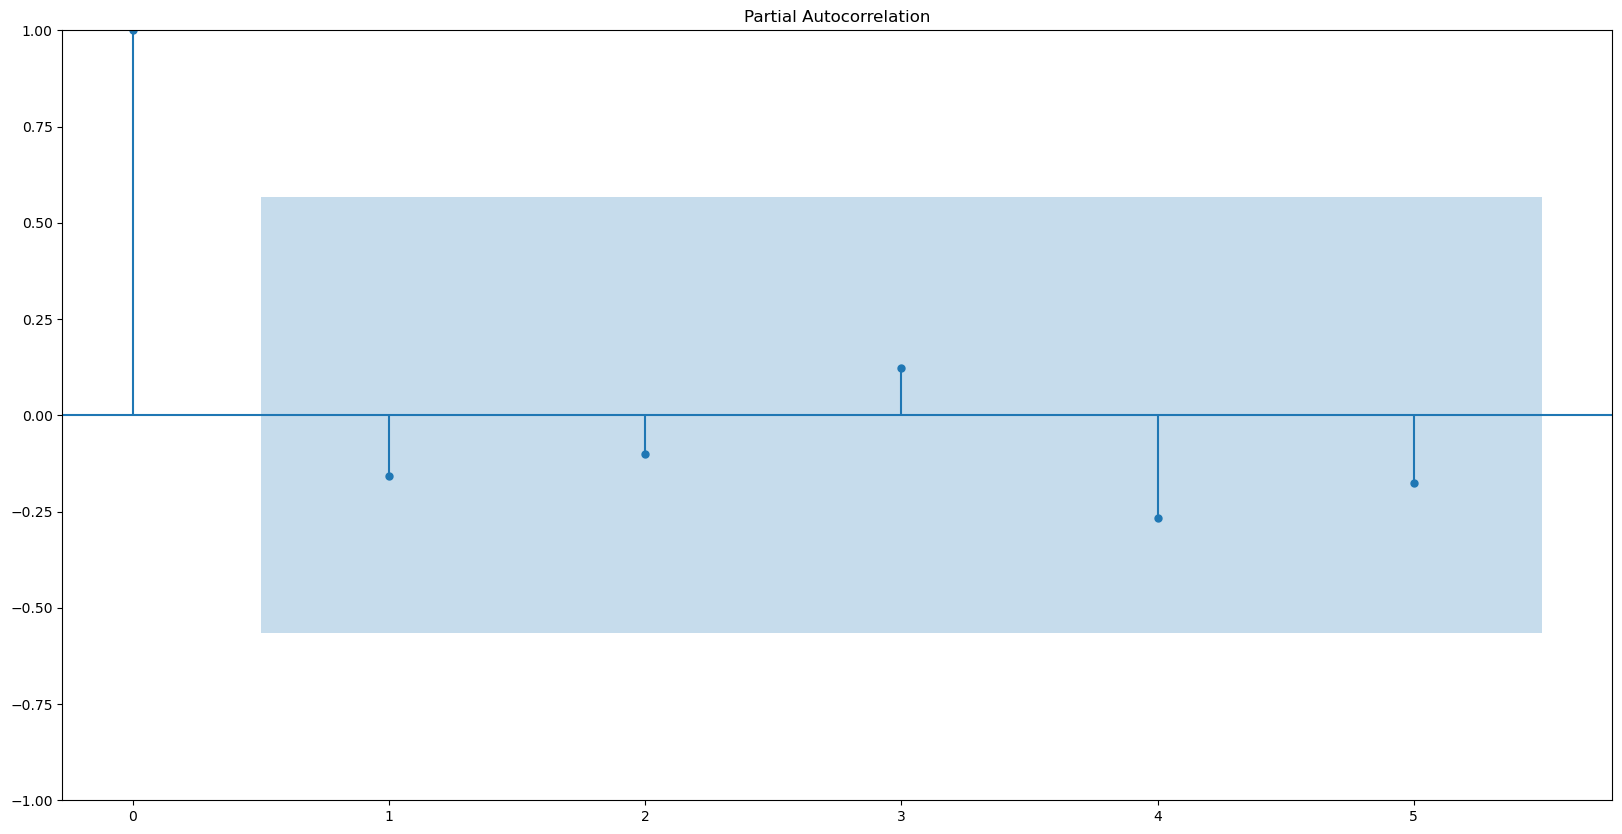

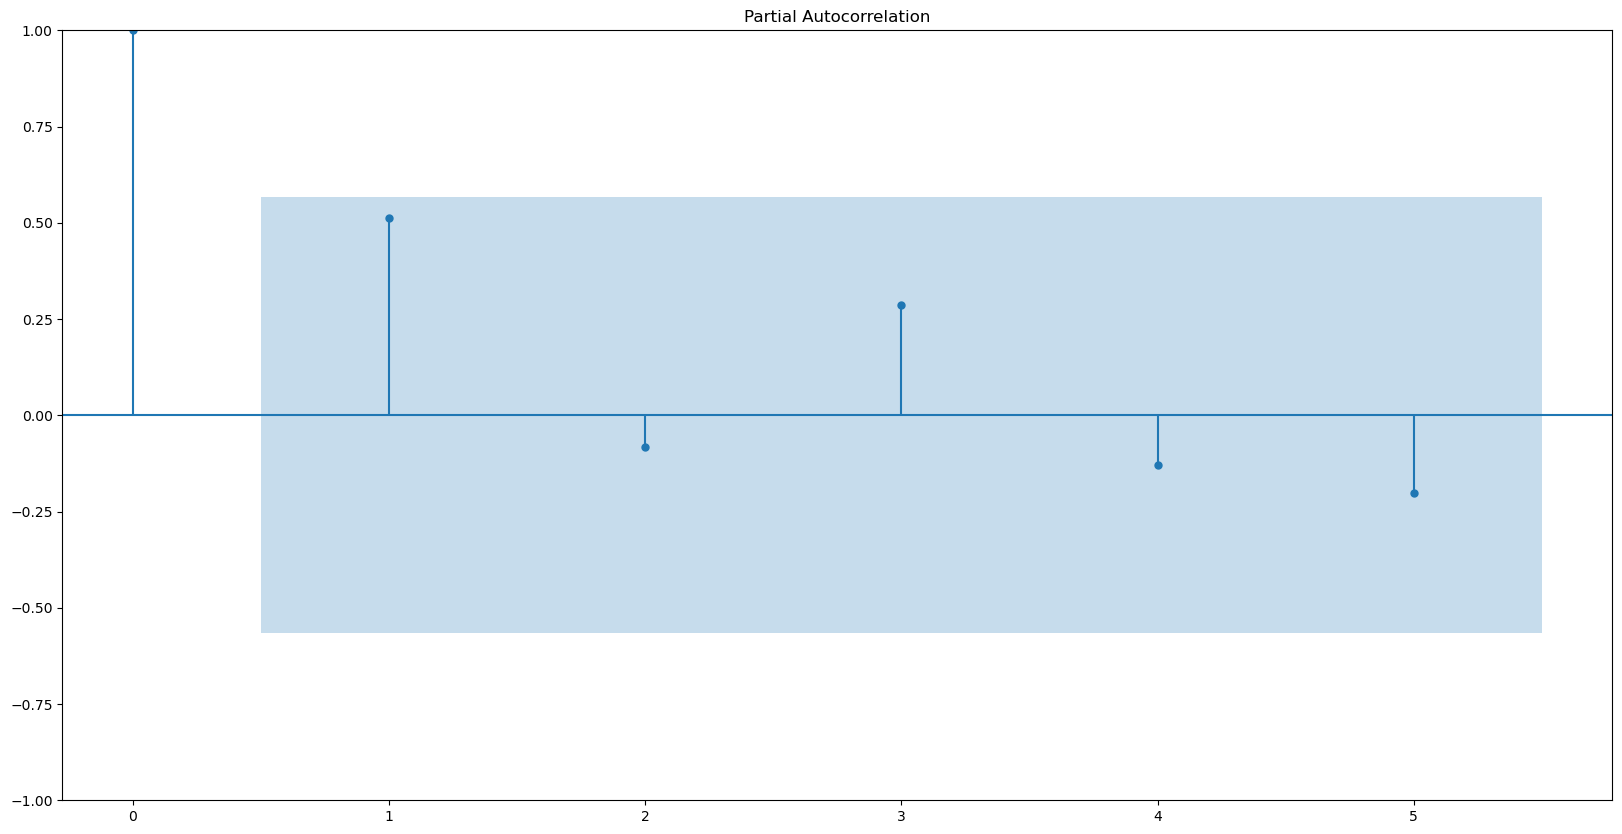

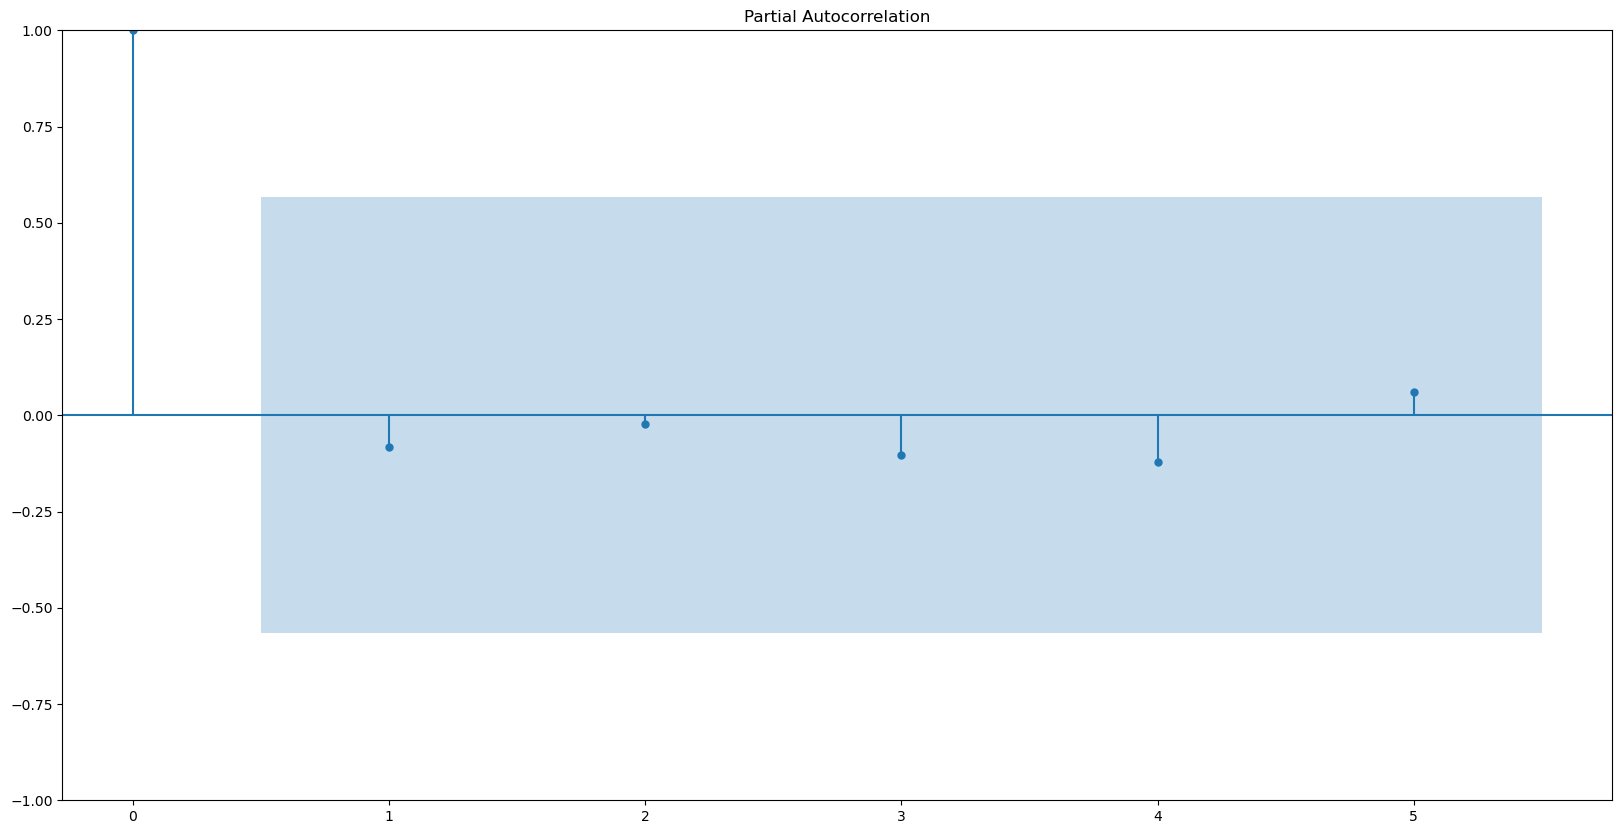

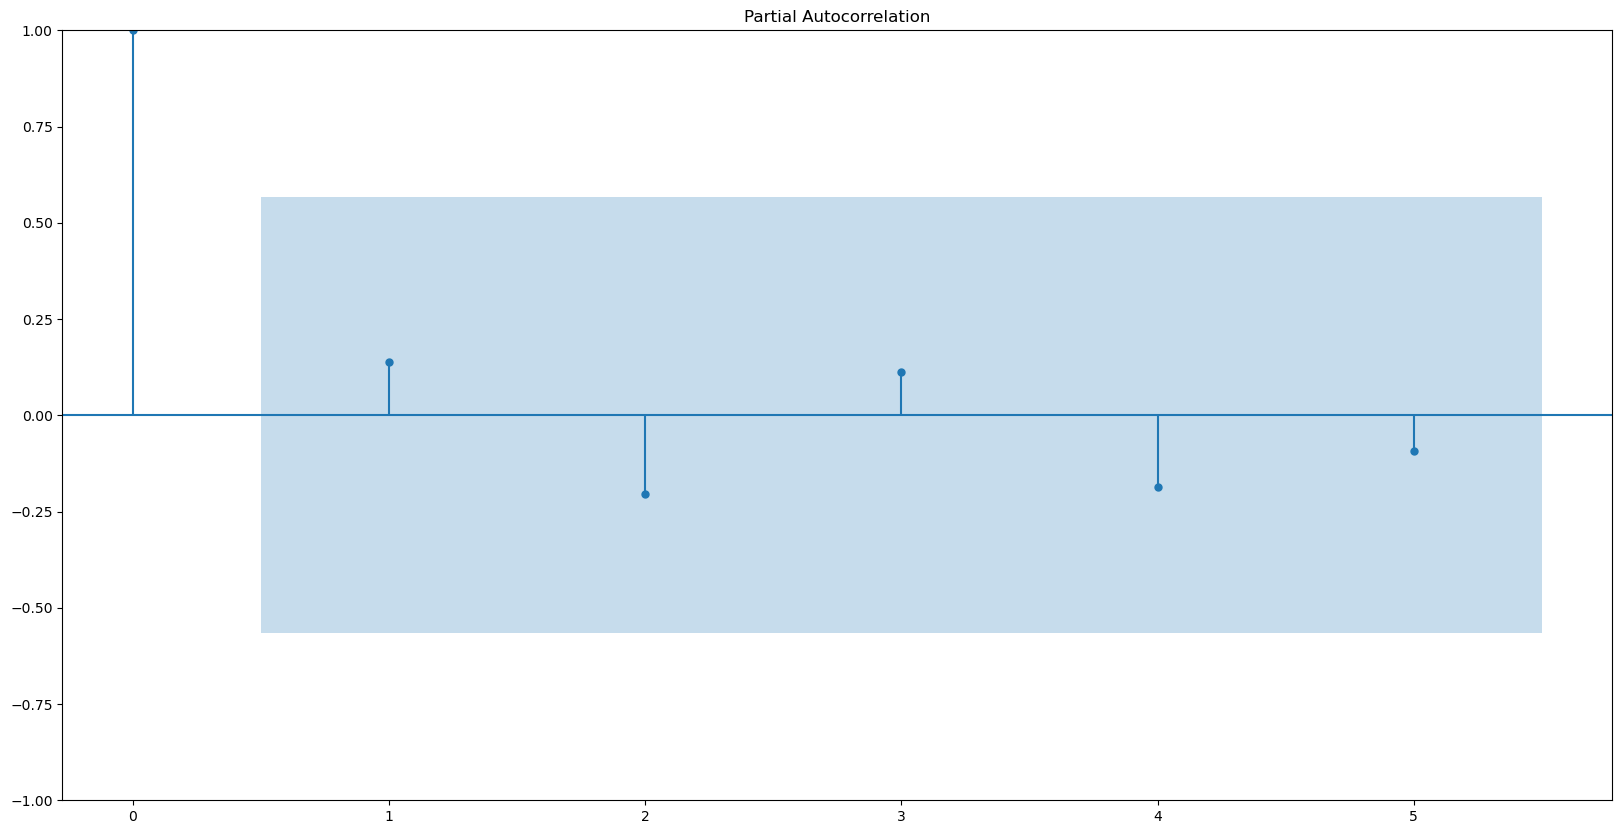

In [277]:
plot_pacf(A , lags = 5)  
plot_pacf(A1 , lags = 5) 
plot_pacf(A2 , lags = 5) 
plot_pacf(A3 , lags = 5) 
plot_pacf(A4 , lags = 5)
plot_pacf(A5 , lags = 5)  
plot_pacf(A6 , lags = 5) 
plot_pacf(A7 , lags = 5) 
plot_pacf(A8 , lags = 5) 
plot_pacf(A9 , lags = 5)

In [278]:
def MAPE(pred, org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [280]:
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

Am = auto_arima(A, suppress_warnings=True)
Am.summary()

Am1 = auto_arima(A1, suppress_warnings=True)
Am1.summary()

Am2 = auto_arima(A2, suppress_warnings=True)
Am2.summary()

Am3 = auto_arima(A3, suppress_warnings=True)
Am3.summary()

Am4 = auto_arima(A4, suppress_warnings=True)
Am4.summary()

Am = auto_arima(A5, suppress_warnings=True)
Am.summary()

Am1 = auto_arima(A6, suppress_warnings=True)
Am1.summary()

Am2 = auto_arima(A7, suppress_warnings=True)
Am2.summary()

Am3 = auto_arima(A8, suppress_warnings=True)
Am3.summary()

Am4 = auto_arima(A9, suppress_warnings=True)
Am4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:                        SARIMAX   Log Likelihood                 -51.244
Date:                Thu, 23 May 2024   AIC                            106.489
Time:                        22:13:54   BIC                            107.459
Sample:                    01-31-2022   HQIC                           106.130
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     60.6667      7.449      8.145      0.000      46.068      75.266
sigma2       299.7222    141.528      2.118      0.034      22.332     577.112
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 4.52
Prob(Q):                              0.59   Prob(JB):                         0.10
Heteroskedasticity (H):               0.06   Skew:                            -1.35
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

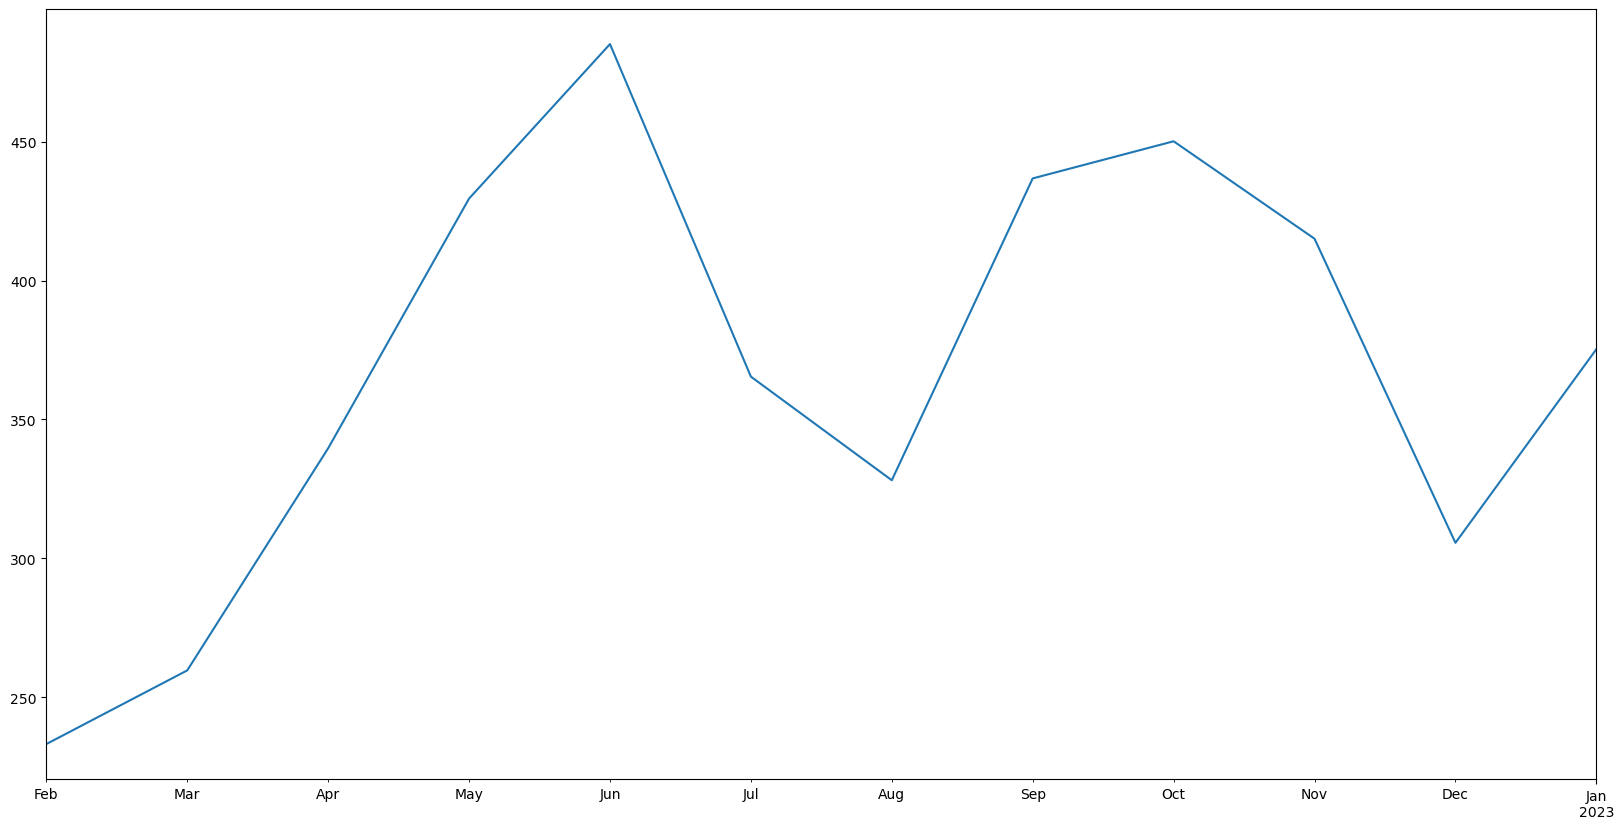

In [314]:
Drug=ARIMA(A,order=(1, 1, 12))
Drug=Drug.fit()
Drug.summary()

pred=Drug.predict(start=1,end=12, typ='levels').rename('ARIMA predictions')
pred.plot()

In [315]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(A['MULTIPLE ELECTROLYTES 500ML IVF'], pred)

predf=Drug.predict(start=12,end=24,typ='levels').rename('ARIMA predictions')
predf
Drug.save('drug_1.pkl')

<Axes: xlabel='Dateofbill'>

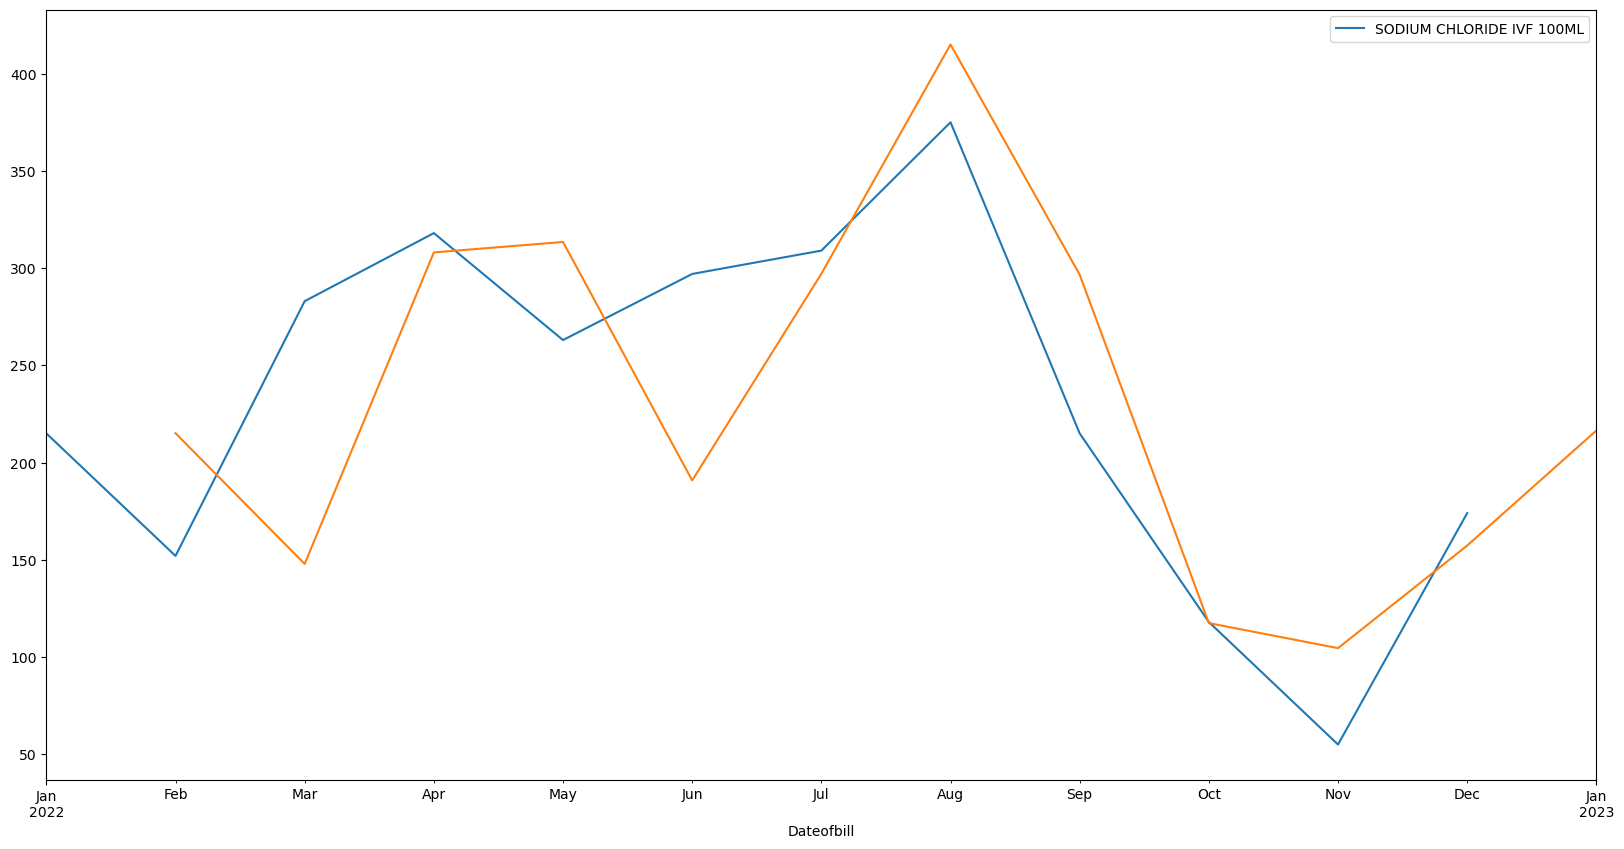

In [316]:
Drug1 = ARIMA(A1,order=(4, 1, 12))
Drug1 = Drug1.fit()
Drug1.summary()
A1.plot()
pred=Drug1.predict(start=1,end=12, typ='levels').rename('ARIMA predictions')
pred.plot()

In [317]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(A1['SODIUM CHLORIDE IVF 100ML'], pred)

predf=Drug1.predict(start=12,end=24,typ='levels').rename('ARIMA predictions')
predf
Drug1.save('drug_2.pkl')

<Axes: xlabel='Dateofbill'>

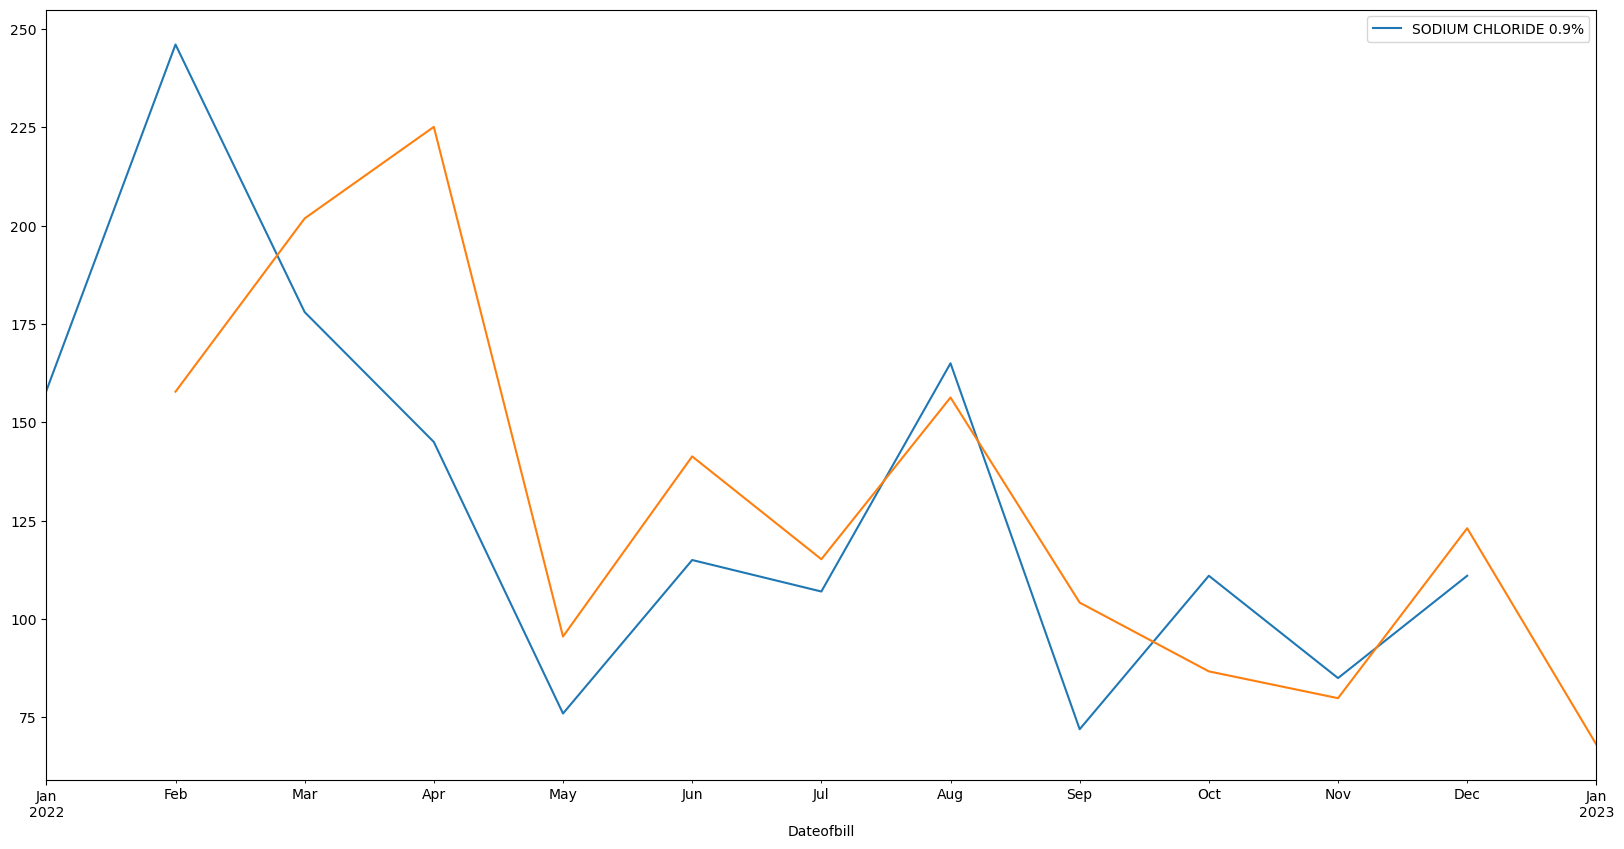

In [318]:
Drug2 = ARIMA(A2,order=(4, 1, 12))
Drug2 = Drug2.fit()
Drug2.summary()
A2.plot()
pred=Drug2.predict(start=1,end=12, typ='levels').rename('ARIMA predictions')
pred.plot()

In [319]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(A2['SODIUM CHLORIDE 0.9%'], pred)

predf=Drug2.predict(start=12,end=24,typ='levels').rename('ARIMA predictions')
predf
Drug2.save('drug_3.pkl')

<Axes: xlabel='Dateofbill'>

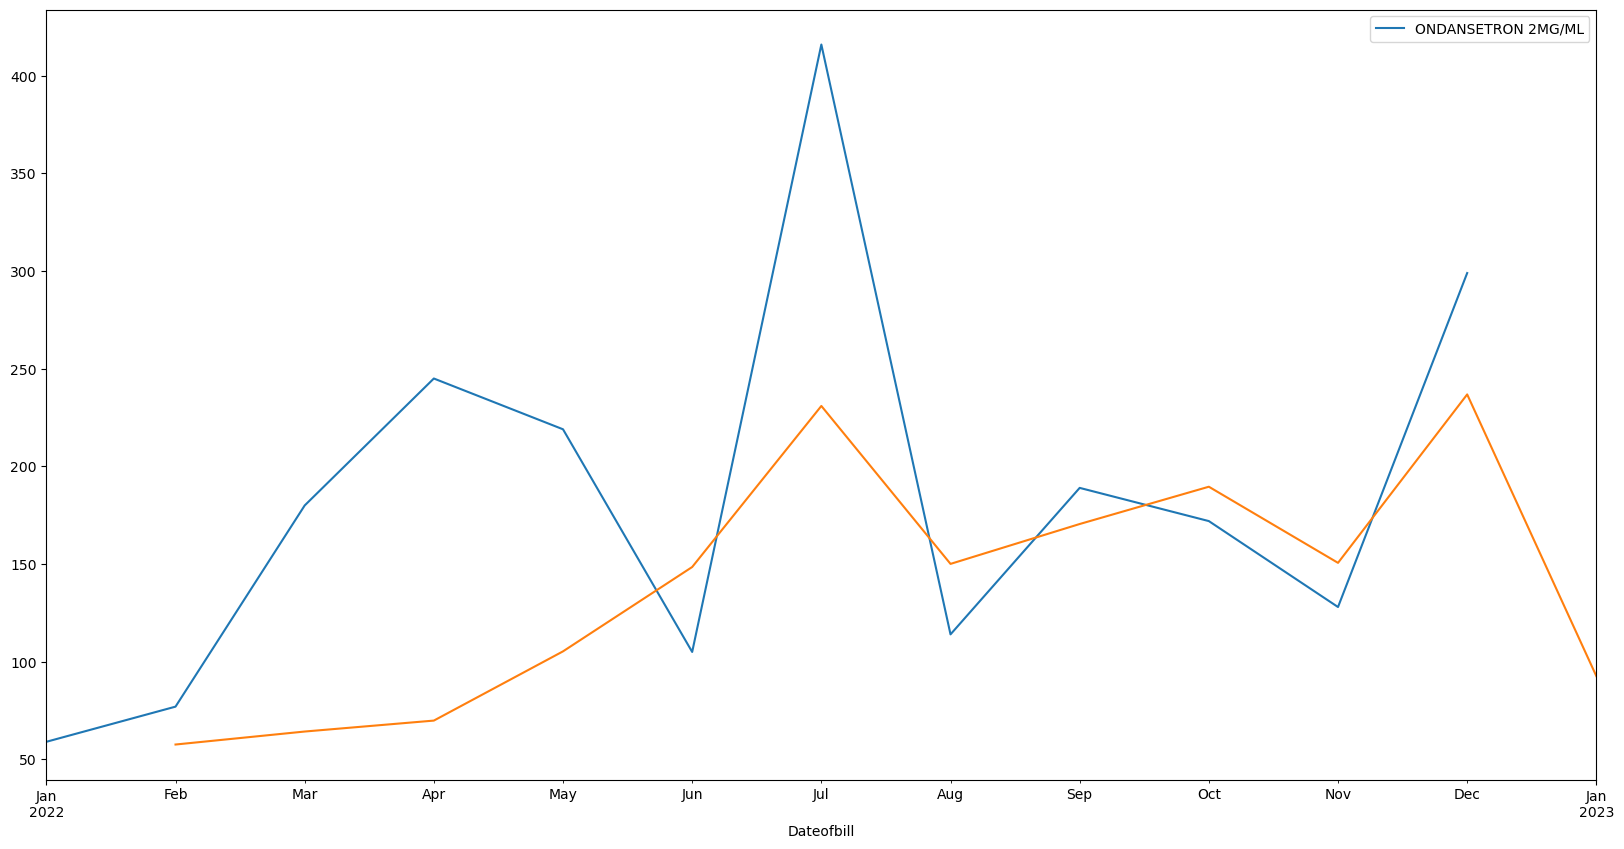

In [320]:
Drug3 = ARIMA(A3,order=(4, 1, 12))
Drug3 = Drug3.fit()
Drug3.summary()
A3.plot()
pred=Drug3.predict(start=1,end=12, typ='levels').rename('ARIMA predictions')
pred.plot()

In [322]:
mean_absolute_percentage_error(A3['ONDANSETRON 2MG/ML'], pred)

predf=Drug3.predict(start=12,end=24,typ='levels').rename('ARIMA predictions')
predf
Drug3.save('drug_4.pkl')

<Axes: xlabel='Dateofbill'>

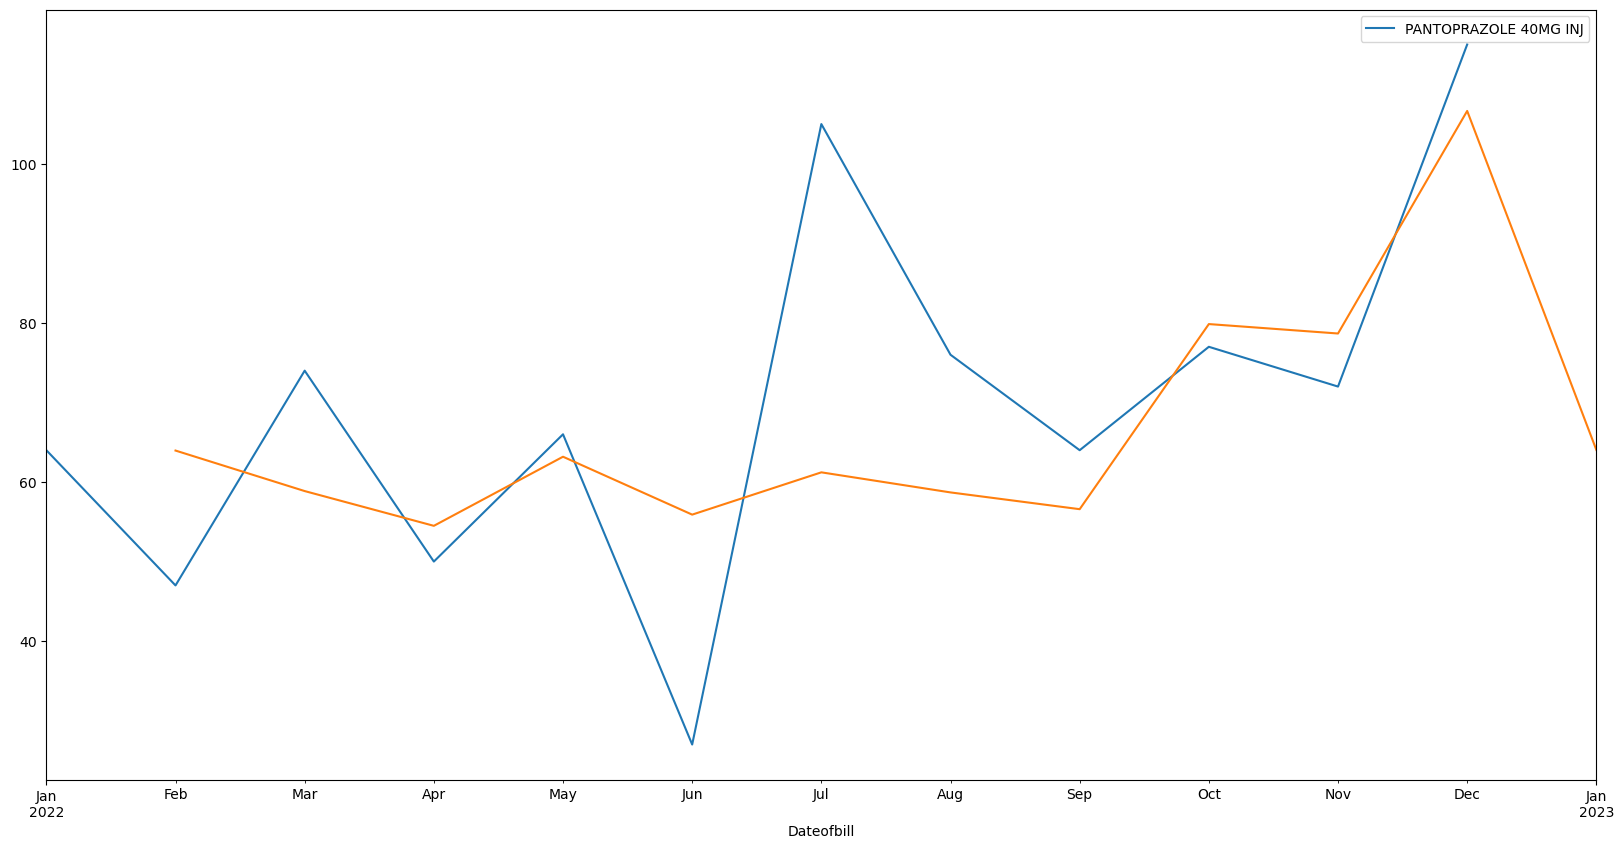

In [323]:
Drug4 = ARIMA(A4,order=(4, 1, 12))
Drug4 = Drug4.fit()
Drug4.summary()
A4.plot()
pred=Drug4.predict(start=1,end=12, typ='levels').rename('ARIMA predictions')
pred.plot()

In [324]:
mean_absolute_percentage_error(A4['PANTOPRAZOLE 40MG INJ'], pred)

predf=Drug4.predict(start=12,end=24,typ='levels').rename('ARIMA predictions')
predf
Drug4.save('drug_5.pkl')

<Axes: xlabel='Dateofbill'>

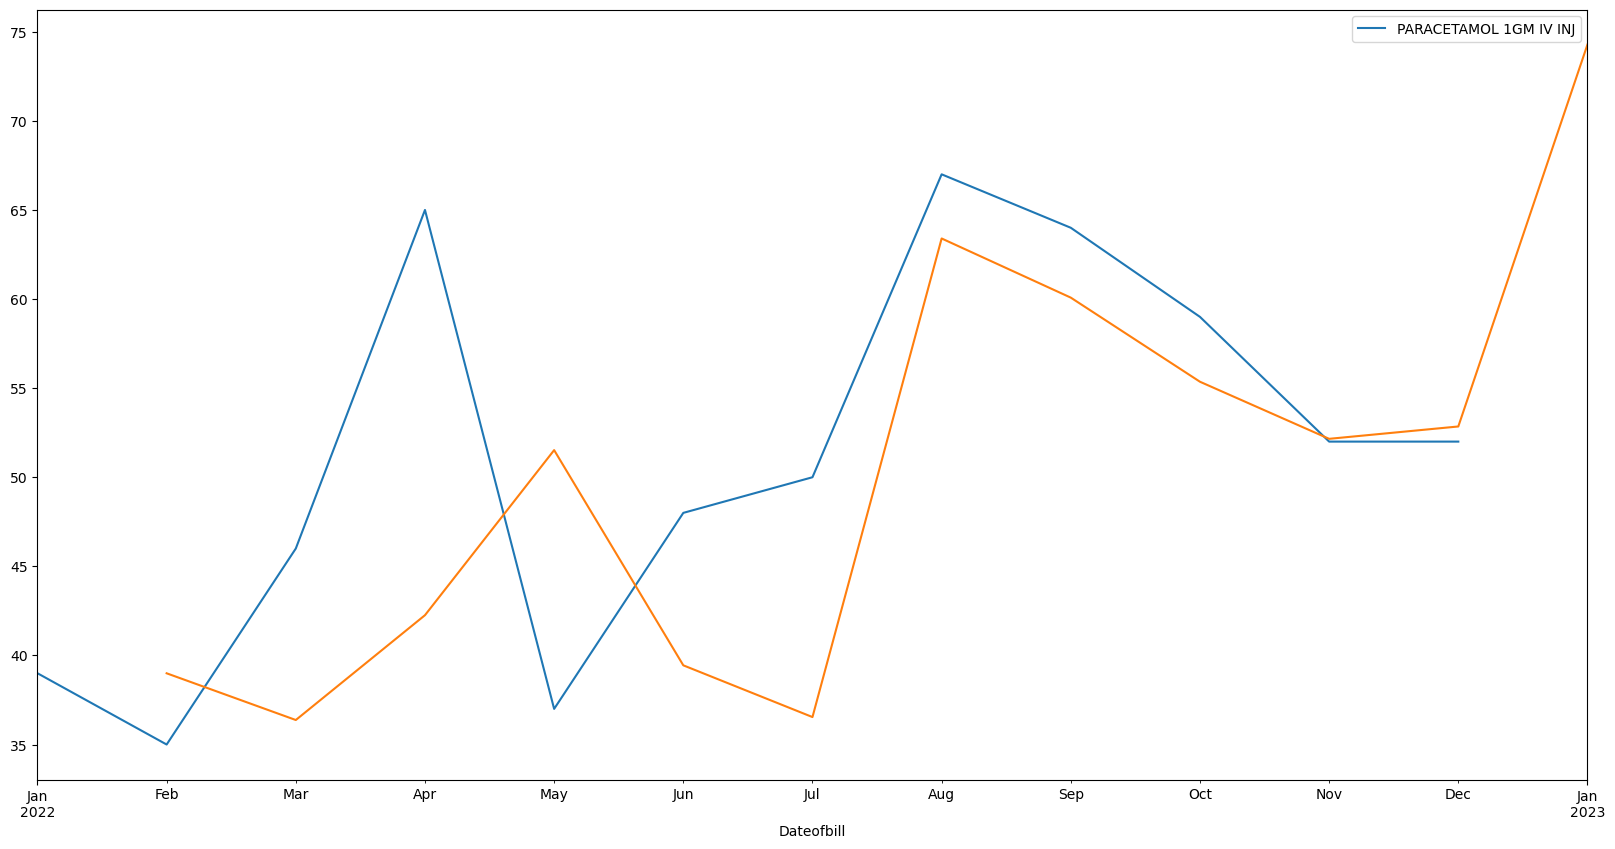

In [325]:
Drug5 = ARIMA(A5,order=(4, 1, 12))
Drug5 = Drug5.fit()
Drug5.summary()
A5.plot()
pred=Drug5.predict(start=1,end=12, typ='levels').rename('ARIMA predictions')
pred.plot()

In [326]:
mean_absolute_percentage_error(A5['PARACETAMOL 1GM IV INJ'], pred)
predf=Drug5.predict(start=12,end=24,typ='levels').rename('ARIMA predictions')
predf
Drug5.save('drug_6.pkl')

<Axes: xlabel='Dateofbill'>

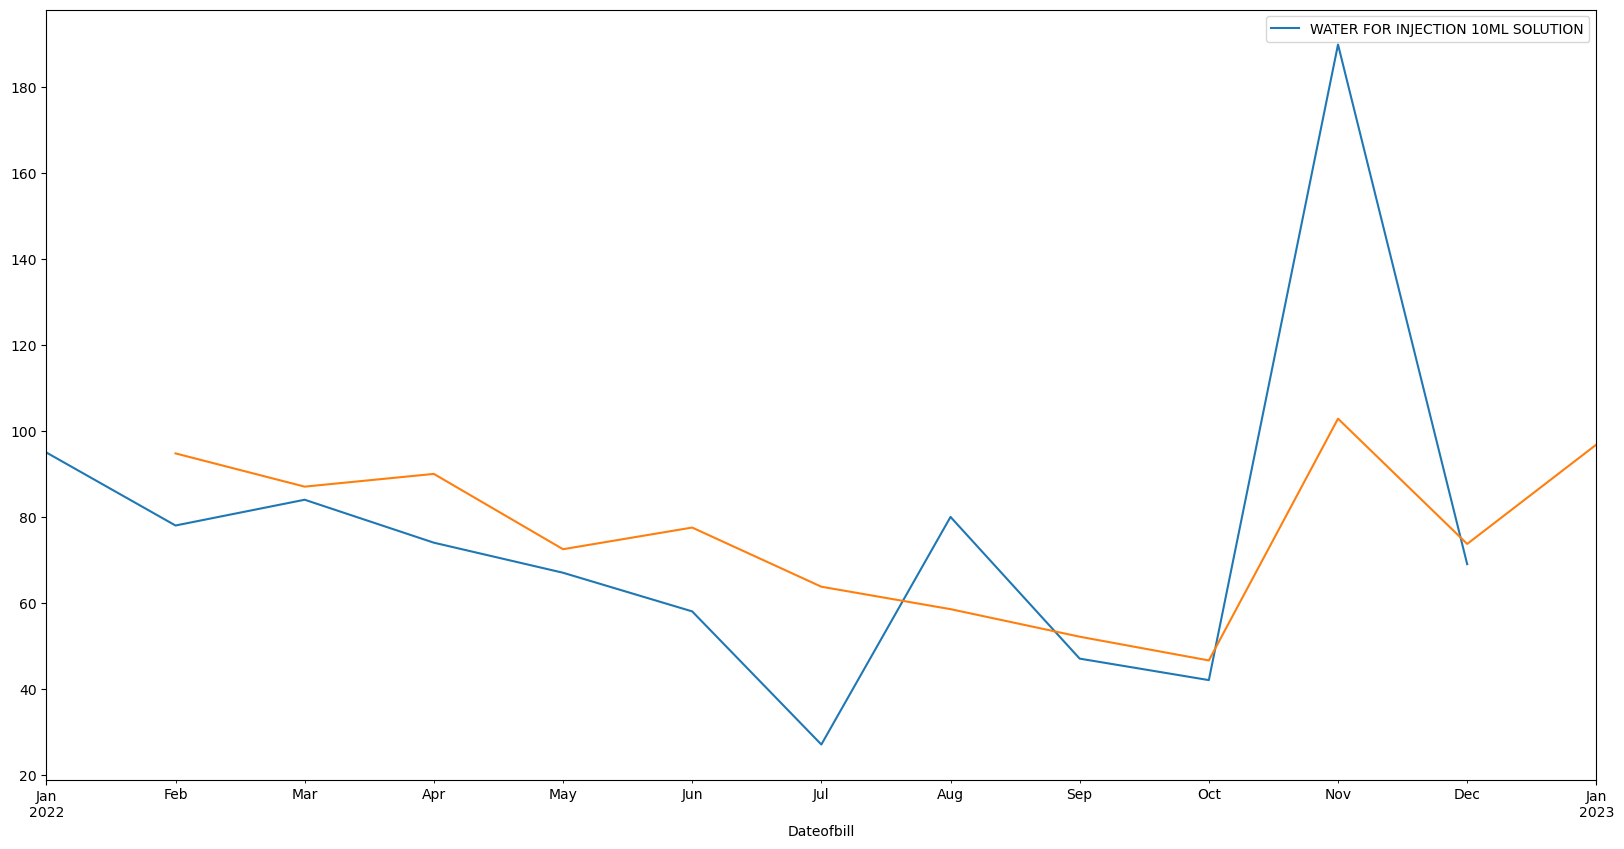

In [327]:
Drug6 = ARIMA(A6,order=(4, 1, 12))
Drug6 = Drug6.fit()
Drug6.summary()
A6.plot()
pred=Drug6.predict(start=1,end=12, typ='levels').rename('ARIMA predictions')
pred.plot()

In [328]:
mean_absolute_percentage_error(A6['WATER FOR INJECTION 10ML SOLUTION'], pred)
predf=Drug6.predict(start=12,end=24,typ='levels').rename('ARIMA predictions')
predf
Drug6.save('drug_7.pkl')

<Axes: xlabel='Dateofbill'>

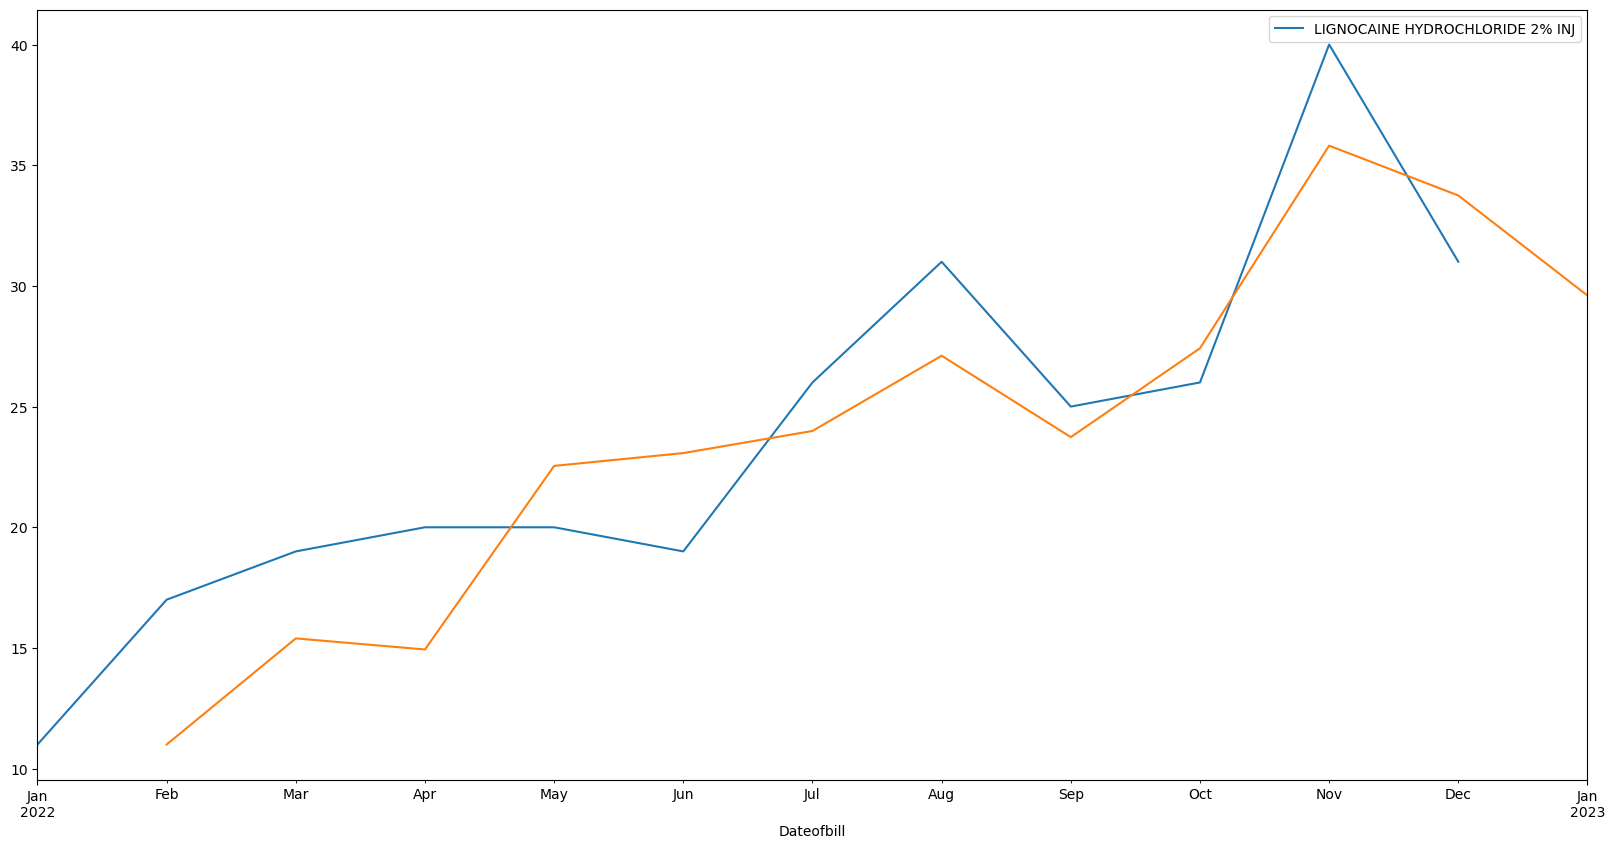

In [329]:
Drug7 = ARIMA(A7,order=(4, 1, 12))
Drug7 = Drug7.fit()
Drug7.summary()
A7.plot()
pred=Drug7.predict(start=1,end=12, typ='levels').rename('ARIMA predictions')
pred.plot()

In [330]:
mean_absolute_percentage_error(A7['LIGNOCAINE HYDROCHLORIDE 2% INJ'], pred)
predf=Drug7.predict(start=12,end=24,typ='levels').rename('ARIMA predictions')
predf
Drug7.save('drug_8.pkl')

<Axes: xlabel='Dateofbill'>

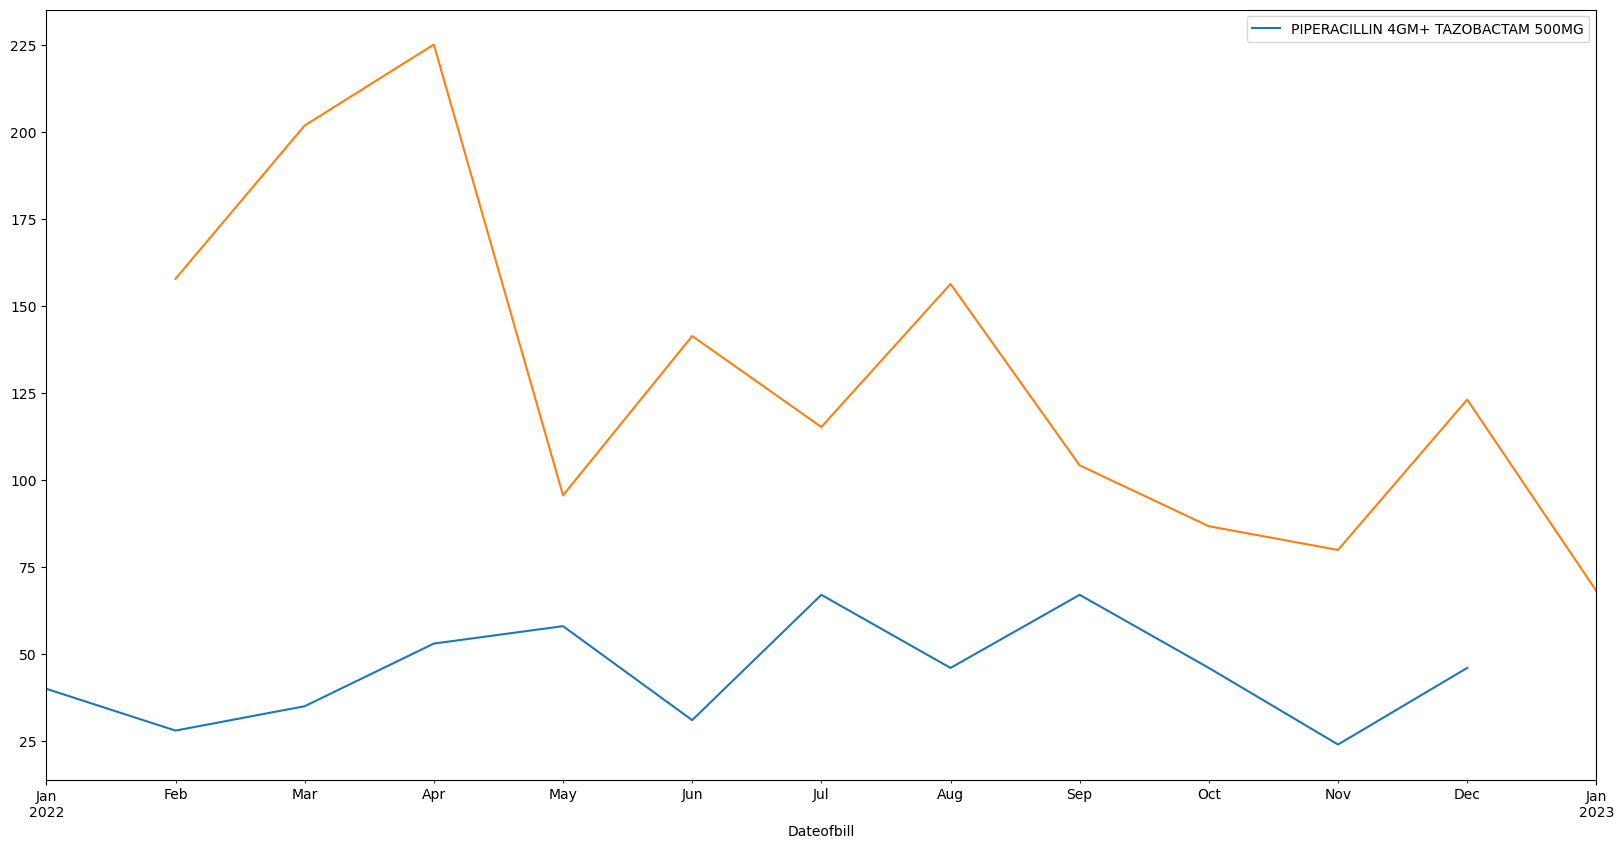

In [332]:
Drug8 = ARIMA(A8,order=(4, 1, 12))
Drug8 = Drug8.fit()
Drug8.summary()
A8.plot()
pred=Drug2.predict(start=1,end=12, typ='levels').rename('ARIMA predictions')
pred.plot()

In [333]:
mean_absolute_percentage_error(A8['PIPERACILLIN 4GM+ TAZOBACTAM 500MG'], pred)
predf=Drug8.predict(start=12,end=24,typ='levels').rename('ARIMA predictions')
predf
Drug8.save('drug_9.pkl')

<Axes: xlabel='Dateofbill'>

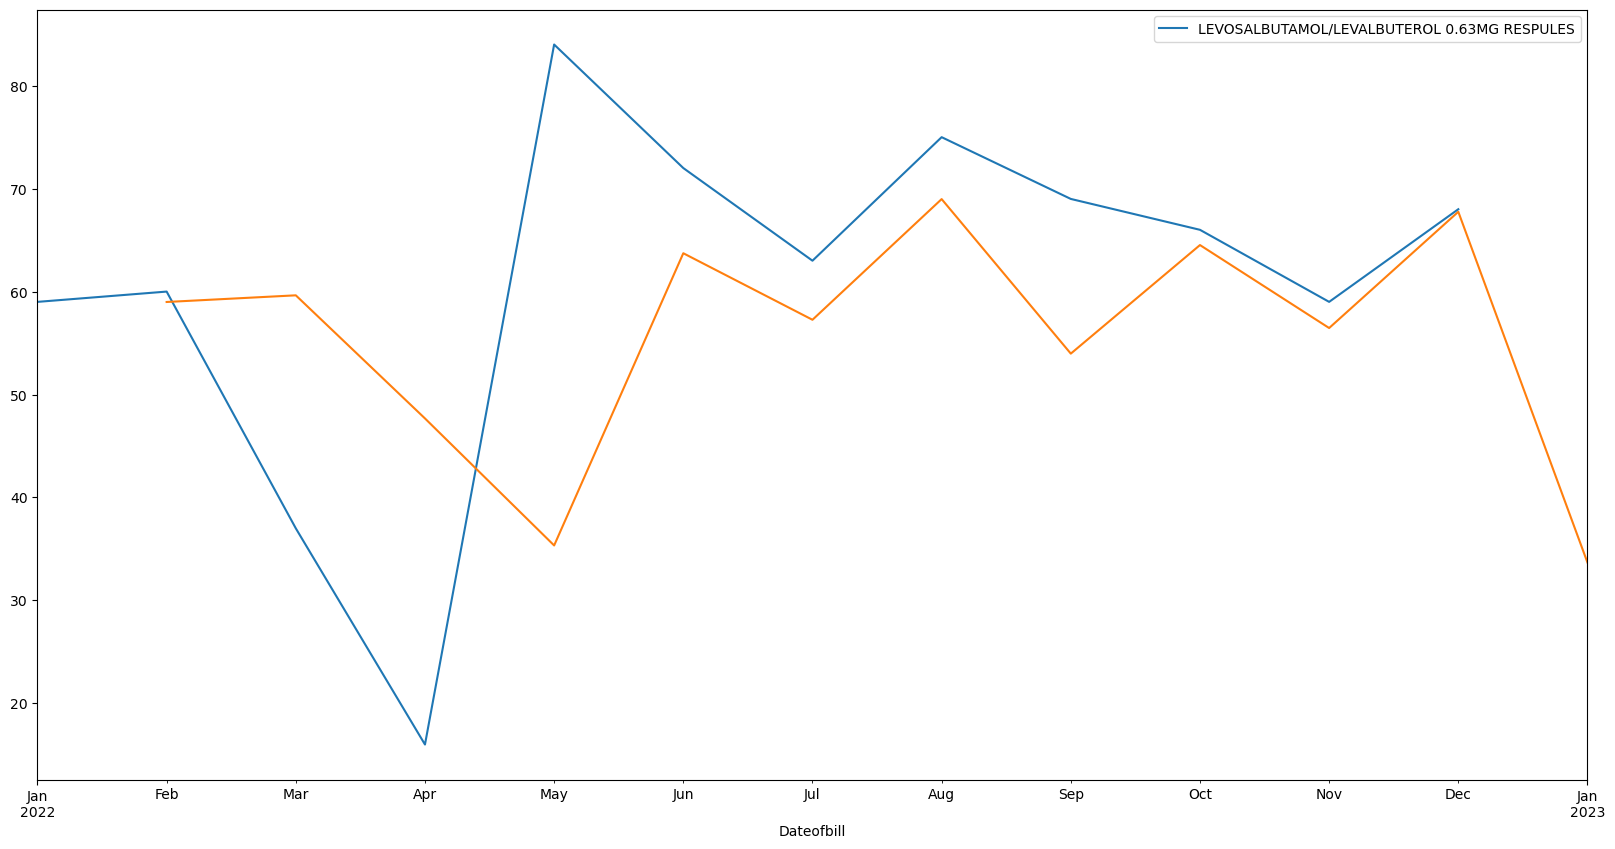

In [334]:
Drug9 = ARIMA(A9,order=(4, 1, 12))
Drug9 = Drug9.fit()
Drug9.summary()
A9.plot()
pred=Drug9.predict(start=1,end=12, typ='levels').rename('ARIMA predictions')
pred.plot()

In [335]:
mean_absolute_percentage_error(A9['LEVOSALBUTAMOL/LEVALBUTEROL 0.63MG RESPULES'], pred)
predf=Drug9.predict(start=12,end=24,typ='levels').rename('ARIMA predictions')
predf
Drug9.save('drug_9.pkl')

In [343]:
# Save DataFrame to CSV file
weekly_sales.to_csv('weekly_sales_with_clusters.csv')